<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Hugo/Hugo_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "boss.de"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  17.25  17.60  16.32  17.50      10.91    3068
2009-01-05  17.10  17.50  16.66  17.45      10.88    1264
2009-01-06  18.28  18.28  17.32  17.49      10.90     239
2009-01-07  17.10  17.40  16.31  16.60      10.35    2715
2009-01-08  16.80  16.80  15.71  16.25      10.13     632
...           ...    ...    ...    ...        ...     ...
2018-12-19  53.64  54.86  53.40  53.86      51.34  491075
2018-12-20  53.00  53.76  52.54  52.96      50.48  361401
2018-12-21  52.62  54.00  52.60  53.32      50.82  543987
2018-12-27  53.72  54.28  52.90  53.22      50.73  273132
2018-12-28  53.50  53.94  53.16  53.92      51.40  166701

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean     66.895108    67.639890    66.066187    66.880815    53.937420  1.727018e+05
std      27.741709    27.890531    27.549726    27.717598    23.490188  2.052188e+05
min       8.880000     9.200000     8.570000     8.820000     5.500000  0.000000e+00
25%      52.965000    53.720000    52.240000    53.135000    42.120000  1.160300e+04
50%      69.540000    70.280000    68.600000    69.490000    58.870000  1.288260e+05
75%      87.415000    88.100000    86.580000    87.325000    71.295000  2.585780e+05
max     119.900000   120.400000   118.900000   120.000000    96.260000  2.408300e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  10.40  10.40   9.55   9.55       5.95     692   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   9.513133  10.047039   8.764959   9.885378   9.883428   9.893521       9.735       9.675   8.999520   9.65625  10.145879   9.6625   9.868611   9.65625  10.283333  10.140030               10.966209                  9.65625                8.346291               11.621189                  9.65625                7.691311               12.276169                  9.65625                7.036331               12.931149                  9.65625                6.381351   9.883428   9.960114   9.999194               11.193388                 9.883428                8.573469               11.848367                 9.883428                7.918489               12.503347                 9.883428                7.263509               13.158327                 9.883428   
2009-03-16  10.09  10.40  10.09  10.37       6.46     292   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   9.555976  10.034763   8.840361  10.077171   9.991555   9.914139       9.735       9.675   9.131558   9.78375  10.344856   9.9020  10.027222   9.78375   9.960000  10.088010               11.147126                  9.78375                8.420374               11.828814                  9.78375                7.738686               12.510502                  9.78375                7.056998               13.192190                  9.78375                6.375310   9.991555  10.206771   9.967903               11.354931                 9.991555                8.628179               12.036619                 9.991555                7.946492               12.718307                 9.991555                7.264804               13.399995                 9.991555   
2009-03-17  10.30  10.80  10.00  10.75       6.70

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     67.981193    68.737654    67.144914    67.970478    54.862716  1.761123e+05    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    67.958243    67.837505    -0.063471    67.972884    67.907936    67.958365    67.885579    67.808174    67.648258    67.909205    67.970914    67.909402    67.929816    67.909205    67.958785    67.776070               70.335157                67.909205               65.483253               71.548132                67.909205               64.270278               72.761108                67.909205               63.057302               73.974084                67.909205               61.844326    67.907936    67.957791    67.796506               70.333888                67.907936               65.481985               71.546864                67.907936               64.269009               72.759840   
std      26.926316    27.058812    26.739742    26.893716    22.789027  2.058398e+05     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    26.945096    27.070219    73.091461    26.902184    26.919255    26.994317    26.921503    26.906970    27.098704    26.935370    26.900051    26.943712    26.913821    26.935370    26.905831    27.042164               27.450306                26.935370               26.519745               27.743330                26.935370               26.350687               28.059088                26.935370               26.208158               28.396821                26.935370               26.092591    26.919255    26.896815    27.026001               27.431116                26.919255               26.506874               27.722672                26.919255               26.339492               28.037010   
min      10.090000    10.400000     9.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-13  0.002823  0.000000  0.000000  0.000000   0.000000     692   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000116  0.545932  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.002954  0.000786                0.000000                 0.000000                0.000000                0.000425                 0.000000                0.000000                0.004233                 0.000000                0.000000                0.007583                 0.000000                0.000056  0.000000  0.000000  0.000349                0.000000                 0.000000                0.000000                0.003027                 0.000000                0.000000                0.006842                 0.000000                0.000000                0.010169                 0.000000   
2009-03-16  0.000000  0.000000  0.004938  0.007424   0.005647     292   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000398  0.000000  0.546251  0.001763  0.001003  0.000193    0.000000    0.000000  0.001185  0.001176  0.001825  0.002208  0.001466  0.001176  0.000000  0.000298                0.001639                 0.001176                0.000686                0.002279                 0.001176                0.000440                0.006227                 0.001176                0.000192                0.009672                 0.001176                0.000000  0.001003  0.002257  0.000057                0.001458                 0.001003                0.000510                0.004693                 0.001003                0.000262                0.008700                 0.001003                0.000012                0.012147                 0.001003   
2009-03-17  0.001912  0.003636  0.004115  0.010865   0.0

140309

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp80tpo_l1
  JVM stdout: /tmp/tmp80tpo_l1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp80tpo_l1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_txo6eb
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.569885  0.688292              0.485977  0.497465  0.247471
1  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.559604  0.899385              0.466033  0.575049  0.330682
2  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.554789  0.827799              0.482301  0.539871  0.291461
3              DeepLearning_1_AutoML_20190828_132828  0.521083  1.841673              0.449766  0.593713  0.352495
4  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.506865  0.689126              0.500000  0.497987  0.247991
5  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.504815  0.688922              0.500000  0.497886  0.247891
6  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.492582  0.691949              0.495575  0.499402  0.249402
7  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.489133  0.721996              0.491150  0.511957  0.262100
8  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.477941  1.699160              0.481553  0.650696  0.423406
9  DeepLearning_grid_1_AutoML_20190828_132828_mod...  0.462520  0.709577              0.495575  0.507824  0.257885

variable  relative_importance  scaled_importance  percentage
0                      SAREXT             1.000000           1.000000    0.001414
1                weekday_name             0.938181           0.938181    0.001326
2                STOCHF_fastk             0.919193           0.919193    0.001300
3              STOCHRSI_fastk             0.918743           0.918743    0.001299
4              STOCHRSI_fastd             0.909847           0.909847    0.001286
...                       ...                  ...                ...         ...
1038      CDLXSIDEGAP3METHODS             0.591736           0.591736    0.000837
1039  BBANDS_upperband_24_5_2             0.589166           0.589166    0.000833
1040       CDLUPSIDEGAP2CROWS             0.575670           0.575670    0.000814
1041           CDL3LINESTRIKE             0.564780           0.564780    0.000799
1042            CDLHIKKAKEMOD             0.546868           0.546868    0.000773

[1043 rows x 4 columns]

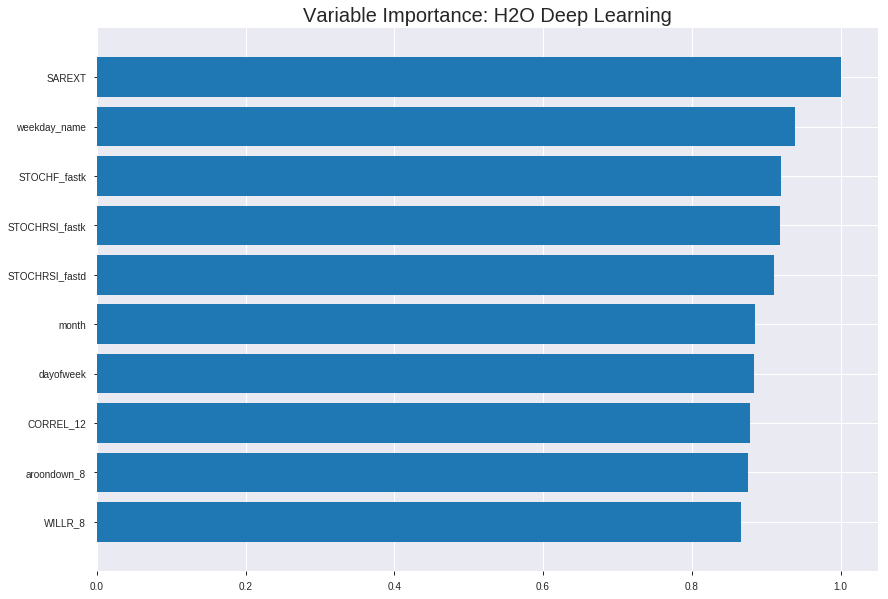

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_132828_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24350493576852214
RMSE: 0.49346219284614107
LogLoss: 0.6792620973691252
Mean Per-Class Error: 0.47387194756404616
AUC: 0.5407930671569215
pr_auc: 0.6235016820614141
Gini: 0.0815861343138431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5210149576168912: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      33   753   0.958    (753.0/786.0)
1      9    946   0.0094   (9.0/955.0)
Total  42   1699  0.4377   (762.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.521015     0.712886  303
max f2                       0.466016     0.86039   328
max f0point5                 0.526958     0.610499  294
max accuracy                 0.527324     0.562895  292
max precision                0.941112     1         0
max recall                   0.393839     1         336
max specificity              0.941112     1         0
max absolute_mcc             0.698064     0.117638  32
max min_per_class_accuracy   0.53173      0.150785  223
max mean_per_class_accuracy  0.553803     0.526128  122

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 53.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.759123           1.72176   1.72176            0.944444         0.820039  0.944444                    0.820039            0.017801        0.017801                   72.1757    72.1757
    2        0.0201034                   0.686348           1.7158    1.71886            0.941176         0.718618  0.942857                    0.770777            0.0167539       0.034555                   71.5799    71.8863
    3        0.0304423                   0.656647           1.21536   1.54786            0.666667         0.668772  0.849057                    0.736134            0.0125654       0.0471204                  21.5358    54.7861
    4        0.0402068                   0.642348           1.17961   1.45843            0.647059         0.649012  0.8                         0.714976            0.0115183       0.0586387                  17.9612    45.8429
    5        0.0505457                   0.599239           1.0128    1.36728            0.555556         0.621722  0.75                        0.695901            0.0104712       0.0691099                  1.27981    36.7277
    6        0.100517                    0.536225           1.06868   1.21883            0.586207         0.554888  0.668571                    0.625798            0.0534031       0.122513                   6.86767    21.883
    7        0.931074                    0.531554           0.993467  1.0178             0.544952         0.531621  0.558297                    0.541788            0.825131        0.947644                   -0.653328  1.77965
    8        1                           0.199292           0.759599  1                  0.416667         0.498737  0.548535                    0.538821            0.052356        1                          -24.0401   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24937642248514807
RMSE: 0.4993760331505188
LogLoss: 0.6954503955247119
Mean Per-Class Error: 0.4632459320187916
AUC: 0.5418258367605703
pr_auc: 0.5780606955339261
Gini: 0.08365167352114056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5301986125560595: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   209  0.9207   (209.0/227.0)
1      9    262  0.0332   (9.0/271.0)
Total  27   471  0.4378   (218.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530199     0.706199  281
max f2                       0.330015     0.856511  308
max f0point5                 0.530496     0.608778  272
max accuracy                 0.530496     0.564257  272
max precision                0.665796     0.678571  27
max recall                   0.330015     1         308
max specificity              0.911834     0.995595  0
max absolute_mcc             0.530496     0.102605  272
max min_per_class_accuracy   0.531563     0.498155  231
max mean_per_class_accuracy  0.548595     0.536754  133

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 55.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.89697            0.735055  0.735055           0.4              0.905533  0.4                         0.905533            0.00738007      0.00738007                 -26.4945  -26.4945
    2        0.0200803                   0.821762           1.10258   0.918819           0.6              0.859996  0.5                         0.882764            0.0110701       0.0184502                  10.2583   -8.11808
    3        0.0301205                   0.708325           1.47011   1.10258            0.8              0.766358  0.6                         0.843962            0.0147601       0.0332103                  47.0111   10.2583
    4        0.0401606                   0.684851           1.47011   1.19446            0.8              0.699576  0.65                        0.807866            0.0147601       0.0479705                  47.0111   19.4465
    5        0.0502008                   0.672362           1.10258   1.17609            0.6              0.677726  0.64                        0.781838            0.0110701       0.0590406                  10.2583   17.6089
    6        0.100402                    0.615586           1.10258   1.13934            0.6              0.642143  0.62                        0.711991            0.0553506       0.114391                   10.2583   13.9336
    7        0.150602                    0.594191           1.10258   1.12708            0.6              0.604934  0.613333                    0.676305            0.0553506       0.169742                   10.2583   12.7085
    8        0.200803                    0.570542           1.17609   1.13934            0.64             0.582305  0.62                        0.652805            0.0590406       0.228782                   17.6089   13.9336
    9        0.301205                    0.542947           1.02908   1.10258            0.56             0.554419  0.6                         0.62001             0.103321        0.332103                   2.90775   10.2583
    10       0.399598                    0.535021           0.900068  1.05272            0.489796         0.538627  0.572864                    0.599971            0.0885609       0.420664                   -9.99322  5.27175
    11       0.84739                     0.531554           0.972383  1.01027            0.529148         0.531736  0.549763                    0.563913            0.435424        0.856089                   -2.76174  1.02656
    12       0.899598                    0.530874           1.20153   1.02137            0.653846         0.53114   0.555804                    0.562011            0.0627306       0.918819                   20.1533   2.1366
    13       1                           0.330015           0.808561  1                  0.44             0.519932  0.544177                    0.557786            0.0811808       1                          -19.1439  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:36:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:37:00  3 min 33.944 sec  403 obs/sec       0.275129  1             479        0.626047         2.33919             -0.58265       0.520863        0.427844           1.41792          0.451465                         0.609575           1.67663               -0.498022        0.554229          0.590155             0.735055           0.455823
    2019-08-28 13:37:23  3 min 56.971 sec  456 obs/sec       5.77082   21            10047      0.504129         0.704705            -0.0262561     0.543799        0.593446           1.41792          0.448018                         0.500958           0.697942              -0.0117342       0.5534            0.584417             0.735055           0.449799
    2019-08-28 13:37:45  4 min 19.209 sec  511 obs/sec       12.3716   45            21539      0.493462         0.679262            0.016715       0.540793        0.623502           1.72176          0.437679                         0.499376           0.69545               -0.00535381      0.541826          0.578061             0.735055           0.437751
    2019-08-28 13:38:07  4 min 41.027 sec  628 obs/sec       22.2642   81            38762      0.491317         0.673549            0.0252455      0.554782        0.639726           1.82304          0.434233                         0.499904           0.720215              -0.0074818       0.537551          0.584407             0.735055           0.455823
    2019-08-28 13:38:29  5 min  3.255 sec  740 obs/sec       34.7949   126           60578      0.485604         0.659999            0.0477831      0.57505         0.697035           1.82304          0.426766                         0.498247           0.716433              -0.000813641     0.520645          0.571647             0.735055           0.443775
    2019-08-28 13:38:51  5 min 24.933 sec  831 obs/sec       48.3636   175           84201      0.480566         0.646318            0.0674371      0.584803        0.693413           1.82304          0.422746                         0.507976           0.784774              -0.0402792       0.502698          0.559618             0.367528           0.443775
    2019-08-28 13:39:13  5 min 47.295 sec  882 obs/sec       61.537    223           107136     0.481091         0.645837            0.0654002      0.598279        0.740304           1.82304          0.412407                         0.517316           0.787463              -0.0788849       0.536689          0.581262             0.735055           0.445783
    2019-08-28 13:39:16  5 min 49.629 sec  882 obs/sec       61.537    223           107136     0.493462         0.679262            0.016715       0.540793        0.623502           1.72176          0.437679                         0.499376           0.69545               -0.00535381      0.541826          0.578061             0.735055           0.437751

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
SAREXT                   1.0                    1.0                  0.0014138981371345336
weekday_name             0.9381814002990723     0.9381814002990723   0.0013264929341771264
STOCHF_fastk             0.9191927909851074     0.9191927909851074   0.001299644974841336
STOCHRSI_fastk           0.9187430739402771     0.9187430739402771   0.0012990091207494127
STOCHRSI_fastd           0.9098467230796814     0.9098467230796814   0.0012864305868403212
---                      ---                    ---                  ---
CDLXSIDEGAP3METHODS      0.5917364954948425     0.5917364954948425   0.0008366551286546752
BBANDS_upperband_24_5_2  0.5891658067703247     0.5891658067703247   0.0008330204366559267
CDLUPSIDEGAP2CROWS       0.5756695866584778     0.5756695866584778   0.0008139381561814286
CDL3LINESTRIKE           0.5647803544998169     0.5647803544998169   0.0007985418911174725
CDLHIKKAKEMOD            0.5468684434890747     0.5468684434890747   0.0007732162735068647


See the whole table with table.as_data_frame()


('accuracy', 0.5903614457831325)

('F1', 0.7105263157894737)

('auc', 0.5698854763144195)

('logloss', 0.6882920278160414)

('mean_per_class_error', 0.4131637168141593)

('rmse', 0.49746475638721727)

('mse', 0.24747118384739344)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


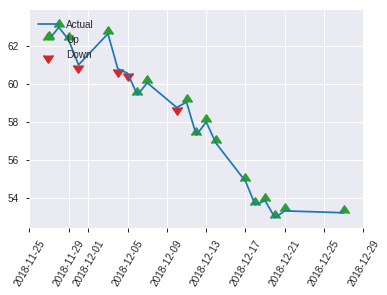


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24747118384739344
RMSE: 0.49746475638721727
LogLoss: 0.6882920278160414
Mean Per-Class Error: 0.4131637168141593
AUC: 0.5698854763144195
pr_auc: 0.5937955713618694
Gini: 0.1397709526288391
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.528413887088395: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    109  0.9646   (109.0/113.0)
1      1    135  0.0074   (1.0/136.0)
Total  5    244  0.4418   (110.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.528414     0.710526  165
max f2                       0.514709     0.858586  169
max f0point5                 0.531647     0.625     135
max accuracy                 0.531647     0.590361  135
max precision                0.703562     1         0
max recall                   0.514709     1         169
max specificity              0.703562     1         0
max absolute_mcc             0.531647     0.173673  135
max min_per_class_accuracy   0.531889     0.580882  125
max mean_per_class_accuracy  0.531647     0.586836  135

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 55.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.69489            1.83088   1.83088            1                0.698307  1                           0.698307            0.0220588       0.0220588                  83.0882   83.0882
    2        0.0200803                   0.691074           0.915441  1.46471            0.5              0.693119  0.8                         0.696232            0.00735294      0.0294118                  -8.45588  46.4706
    3        0.0321285                   0.688748           0.610294  1.1443             0.333333         0.690068  0.625                       0.693921            0.00735294      0.0367647                  -38.9706  14.4301
    4        0.0401606                   0.687269           0         0.915441           0                0.687931  0.5                         0.692723            0               0.0367647                  -100      -8.45588
    5        0.0522088                   0.679096           1.22059   0.98586            0.666667         0.683703  0.538462                    0.690641            0.0147059       0.0514706                  22.0588   -1.41403
    6        0.100402                    0.633658           1.06801   1.02529            0.583333         0.659052  0.56                        0.675478            0.0514706       0.102941                   6.80147   2.52941
    7        0.15261                     0.614394           1.1267    1.05998            0.615385         0.624414  0.578947                    0.658009            0.0588235       0.161765                   12.6697   5.99845
    8        0.200803                    0.58527            1.06801   1.06191            0.583333         0.59903   0.58                        0.643854            0.0514706       0.213235                   6.80147   6.19118
    9        0.301205                    0.550386           1.245     1.12294            0.68             0.568366  0.613333                    0.618691            0.125           0.338235                   24.5      12.2941
    10       0.401606                    0.533497           1.17176   1.13515            0.64             0.538943  0.62                        0.598754            0.117647        0.455882                   17.1765   13.5147
    11       0.502008                    0.531898           1.17176   1.14247            0.64             0.532414  0.624                       0.585486            0.117647        0.573529                   17.1765   14.2471
    12       0.863454                    0.531554           0.813725  1.00486            0.444444         0.531581  0.548837                    0.562921            0.294118        0.867647                   -18.6275  0.485636
    13       0.899598                    0.530564           0.610294  0.989003           0.333333         0.530968  0.540179                    0.561638            0.0220588       0.889706                   -38.9706  -1.09966
    14       1                           0.5045             1.09853   1                  0.6              0.527455  0.546185                    0.558206            0.110294        1                          9.85294   0

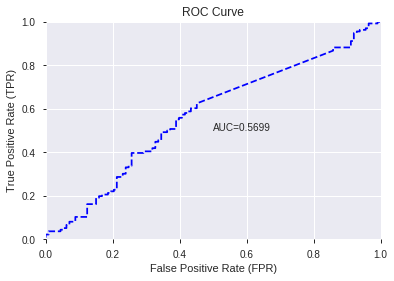

This function is available for GLM models only


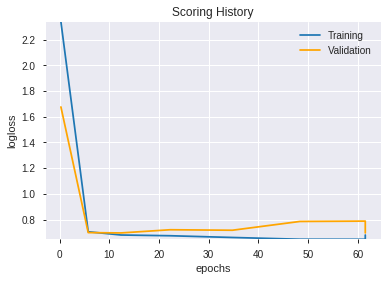

--2019-08-28 13:54:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  35.6MB/s    in 10s     

2019-08-28 13:54:50 (33.7 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_132828_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_132828_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_135502_model_9  0.522710  0.689649              0.494827  0.498253  0.248256
1  DeepLearning_grid_1_AutoML_20190828_135502_model_1  0.512884  1.152365              0.489654  0.597384  0.356867
2  DeepLearning_grid_1_AutoML_20190828_135502_model_4  0.511322  0.928577              0.500000  0.565458  0.319743
3  DeepLearning_grid_1_AutoML_20190828_135502_model_2  0.506702  1.038420              0.500000  0.580290  0.336737
4  DeepLearning_grid_1_AutoML_20190828_135502_model_5  0.494990  0.721091              0.494827  0.512340  0.262493
5  DeepLearning_grid_1_AutoML_20190828_135502_model_3  0.491346  0.882797              0.500000  0.558429  0.311842
6               DeepLearning_1_AutoML_20190828_135502  0.487507  0.800165              0.494827  0.540048  0.291651
7  DeepLearning_grid_1_AutoML_20190828_135502_model_6  0.478071  0.708994              0.500000  0.507493  0.257549
8  DeepLearning_grid_1_AutoML_20190828_135502_model_7  0.472866  1.032445              0.485229  0.582254  0.339020
9  DeepLearning_grid_1_AutoML_20190828_135502_model_8  0.459917  0.737745              0.500000  0.513717  0.263905

variable  relative_importance  scaled_importance  percentage
0        weekday_name             1.000000           1.000000    0.021137
1           CORREL_12             0.993047           0.993047    0.020990
2          aroonup_30             0.990904           0.990904    0.020944
3           dayofyear             0.986454           0.986454    0.020850
4            STDDEV_8             0.981477           0.981477    0.020745
5         STOCH_slowd             0.975853           0.975853    0.020626
6              SAREXT             0.974740           0.974740    0.020603
7      STOCHRSI_fastd             0.974212           0.974212    0.020592
8              BETA_8             0.973237           0.973237    0.020571
9         aroondown_8             0.972595           0.972595    0.020557
10       aroondown_12             0.966542           0.966542    0.020429
11                day             0.965766           0.965766    0.020413
12              DX_14             0.963816           0.963816    0.020372
13            weekday             0.963803           0.963803    0.020372
14            BETA_30             0.962395           0.962395    0.020342
15      days_in_month             0.962203           0.962203    0.020338
16            CDLDOJI             0.961028           0.961028    0.020313
17            quarter             0.957896           0.957896    0.020247
18                COS             0.956997           0.956997    0.020228
19              month             0.954767           0.954767    0.020181
20  HT_PHASOR_inphase             0.954243           0.954243    0.020169
21       aroondown_20             0.951287           0.951287    0.020107
22                BOP             0.950887           0.950887    0.020099
23              DX_12             0.950541           0.950541    0.020091
24            WILLR_8             0.946147           0.946147    0.019998
25              ROC_8             0.943365           0.943365    0.019940
26          dayofweek             0.942587           0.942587    0.019923
27       STOCHF_fastd             0.942289           0.942289    0.019917
28     STOCHRSI_fastk             0.942273           0.942273    0.019916
29         PLUS_DI_30             0.941940           0.941940    0.019909
30        STOCH_slowk             0.939739           0.939739    0.019863
31              DX_24             0.939300           0.939300    0.019854
32             ADXR_8             0.937885           0.937885    0.019824
33         weekofyear             0.937473           0.937473    0.019815
34             ROCP_8             0.936450           0.936450    0.019793
35            ADXR_12             0.935226           0.935226    0.019768
36         aroonup_14             0.934663           0.934663    0.019756
37         aroonup_24             0.932208           0.932208    0.019704
38              CCI_8             0.929027           0.929027    0.019636
39              DX_30             0.925711           0.925711    0.019566
40            ADXR_14             0.925660           0.925660    0.019565
41               week             0.922324           0.922324    0.019495
42           WILLR_12             0.918944           0.918944    0.019423
43              DX_20             0.918820           0.918820    0.019421
44            BETA_12             0.916850           0.916850    0.019379
45  CDLLONGLEGGEDDOJI             0.905893           0.905893    0.019148
46           WILLR_14             0.895465           0.895465    0.018927
47       STOCHF_fastk             0.894373           0.894373    0.018904
48                SIN             0.882837           0.882837    0.018660
49       HT_TRENDMODE             0.879152           0.879152    0.018582

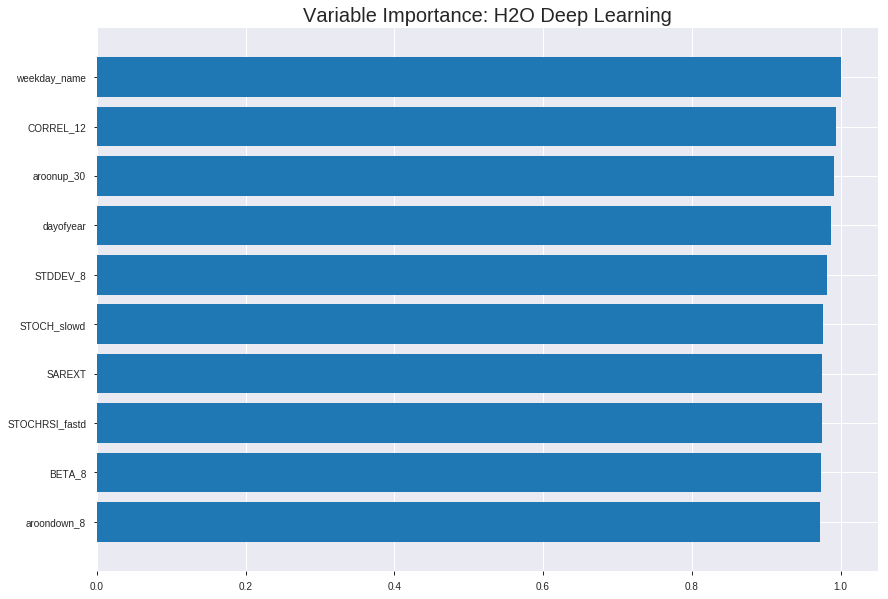

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_135502_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24753628786437445
RMSE: 0.49753018789252823
LogLoss: 0.6882084640164088
Mean Per-Class Error: 0.4637218070154403
AUC: 0.528799142054008
pr_auc: 0.5660849920061225
Gini: 0.05759828410801604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4611284499414755: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    783   0.9962   (783.0/786.0)
1      1    954   0.001    (1.0/955.0)
Total  4    1737  0.4503   (784.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.461128     0.708767   397
max f2                       0.460851     0.858813   398
max f0point5                 0.467614     0.60434    385
max accuracy                 0.467614     0.551407   385
max precision                0.572985     1          0
max recall                   0.460851     1          398
max specificity              0.572985     1          0
max absolute_mcc             0.539357     0.0735553  134
max min_per_class_accuracy   0.534459     0.521628   162
max mean_per_class_accuracy  0.539357     0.536278   134

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 52.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.56526            0.810239  0.810239           0.444444         0.568036  0.444444                    0.568036            0.00837696      0.00837696                 -18.9761  -18.9761
    2        0.0201034                   0.562117           1.07237   0.937562           0.588235         0.563789  0.514286                    0.565973            0.0104712       0.0188482                  7.23745   -6.24383
    3        0.0304423                   0.560486           1.21536   1.03191            0.666667         0.56146   0.566038                    0.56444             0.0125654       0.0314136                  21.5358   3.19075
    4        0.0402068                   0.559588           0.965137  1.01569            0.529412         0.55991   0.557143                    0.56334             0.00942408      0.0408377                  -3.4863   1.56918
    5        0.0505457                   0.558705           1.0128    1.0151             0.555556         0.559084  0.556818                    0.56247             0.0104712       0.0513089                  1.27981   1.51
    6        0.100517                    0.55445            1.06868   1.04174            0.586207         0.556491  0.571429                    0.559497            0.0534031       0.104712                   6.86767   4.17352
    7        0.150488                    0.551379           1.06868   1.05068            0.586207         0.552911  0.576336                    0.55731             0.0534031       0.158115                   6.86767   5.06814
    8        0.20046                     0.549156           1.06868   1.05517            0.586207         0.550277  0.578797                    0.555557            0.0534031       0.211518                   6.86767   5.51673
    9        0.300402                    0.544295           1.03724   1.0492             0.568966         0.546646  0.575526                    0.552592            0.103665        0.315183                   3.7245    4.92046
    10       0.400345                    0.539415           1.16297   1.07761            0.637931         0.542035  0.591105                    0.549957            0.11623         0.431414                   16.2972   7.76056
    11       0.500287                    0.534572           0.890564  1.04024            0.488506         0.537086  0.570608                    0.547386            0.0890052       0.520419                   -10.9436  4.02402
    12       0.60023                     0.527964           0.911518  1.01881            0.5              0.531383  0.558852                    0.544721            0.0910995       0.611518                   -8.84817  1.88071
    13       0.700172                    0.519219           1.01629   1.01845            0.557471         0.523746  0.558655                    0.541727            0.101571        0.713089                   1.62905   1.84479
    14       0.800115                    0.509472           0.995336  1.01556            0.545977         0.514704  0.557071                    0.538352            0.0994764       0.812565                   -0.46639  1.5561
    15       0.900057                    0.495661           0.963904  1.00983            0.528736         0.502882  0.553925                    0.534413            0.0963351       0.908901                   -3.60956  0.982502
    16       1                           0.45883            0.911518  1                  0.5              0.480724  0.548535                    0.529047          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2470214017632299
RMSE: 0.49701247646636587
LogLoss: 0.6871775332668747
Mean Per-Class Error: 0.4475754669440968
AUC: 0.5423866573467497
pr_auc: 0.5651915223370055
Gini: 0.08477331469349947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4551470789147878: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    226  0.9956   (226.0/227.0)
1      0    271  0        (0.0/271.0)
Total  1    497  0.4538   (226.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455147     0.705729  398
max f2                       0.455147     0.857052  398
max f0point5                 0.510199     0.604567  320
max accuracy                 0.53044      0.564257  241
max precision                0.557171     0.666667  25
max recall                   0.455147     1         398
max specificity              0.568435     0.995595  0
max absolute_mcc             0.53044      0.108696  241
max min_per_class_accuracy   0.536985     0.527675  190
max mean_per_class_accuracy  0.53044      0.552425  241

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 53.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.563226           0.367528  0.367528           0.2              0.565887  0.2                         0.565887            0.00369004      0.00369004                 -63.2472  -63.2472
    2        0.0200803                   0.561922           1.10258   0.735055           0.6              0.562783  0.4                         0.564335            0.0110701       0.0147601                  10.2583   -26.4945
    3        0.0301205                   0.560754           1.47011   0.980074           0.8              0.561562  0.533333                    0.563411            0.0147601       0.0295203                  47.0111   -1.99262
    4        0.0401606                   0.559514           1.83764   1.19446            1                0.560475  0.65                        0.562677            0.0184502       0.0479705                  83.7638   19.4465
    5        0.0502008                   0.55813            1.10258   1.17609            0.6              0.558923  0.64                        0.561926            0.0110701       0.0590406                  10.2583   17.6089
    6        0.100402                    0.5536             0.955572  1.06583            0.52             0.555002  0.58                        0.558464            0.0479705       0.107011                   -4.4428   6.58303
    7        0.150602                    0.551737           1.02908   1.05358            0.56             0.552699  0.573333                    0.556542            0.0516605       0.158672                   2.90775   5.35793
    8        0.200803                    0.54918            0.808561  0.992325           0.44             0.550493  0.54                        0.55503             0.0405904       0.199262                   -19.1439  -0.767528
    9        0.301205                    0.544831           1.13934   1.04133            0.62             0.546914  0.566667                    0.552325            0.114391        0.313653                   13.9336   4.13284
    10       0.399598                    0.540957           1.12508   1.06195            0.612245         0.542764  0.577889                    0.54997             0.110701        0.424354                   12.5085   6.19518
    11       0.5                         0.536714           1.02908   1.05535            0.56             0.538743  0.574297                    0.547716            0.103321        0.527675                   2.90775   5.53506
    12       0.600402                    0.532797           1.13934   1.06939            0.62             0.535018  0.58194                     0.545593            0.114391        0.642066                   13.9336   6.93949
    13       0.698795                    0.52679            0.900068  1.04555            0.489796         0.529841  0.568966                    0.543375            0.0885609       0.730627                   -9.99322  4.55529
    14       0.799197                    0.515222           0.845314  1.0204             0.46             0.520977  0.555276                    0.540561            0.0848708       0.815498                   -15.4686  2.03972
    15       0.899598                    0.502667           0.955572  1.01316            0.52             0.508414  0.551339                    0.536973            0.095941        0.911439                   -4.4428   1.31622
    16       1                           0.453443           0.882066  1                  0.48             0.487176  0.544177                    0.531973    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:01:12  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:01:14  2 min 15.082 sec  545 obs/sec       0.566916  1             987        0.548778         0.840447            -0.216088      0.523041        0.568741           1.21536          0.451465                         0.543041           0.819753              -0.188856        0.522522          0.562011             0.735055           0.447791
    2019-08-28 14:01:23  2 min 24.288 sec  911 obs/sec       5.32395   9             9269       0.49753          0.688208            0.000436248    0.528799        0.566085           0.810239         0.450316                         0.497012           0.687178              0.00414039       0.542387          0.565192             0.367528           0.453815
    2019-08-28 14:01:32  2 min 33.281 sec  1078 obs/sec      11.255    19            19595      0.509561         0.712609            -0.0484874     0.487109        0.538718           0.911518         0.451465                         0.508641           0.710735              -0.0430067       0.505454          0.553771             0.735055           0.451807
    2019-08-28 14:01:42  2 min 43.560 sec  1276 obs/sec      20.1901   34            35151      0.50022          0.693728            -0.0104027     0.498455        0.508566           1                0.451465                         0.50108            0.695471              -0.0122251       0.495213          0.396084             1                  0.455823
    2019-08-28 14:01:51  2 min 52.726 sec  1468 obs/sec      30.2051   51            52587      0.497819         0.68877             -0.000726185   0.526143        0.586229           1.41792          0.450316                         0.499092           0.691373              -0.00420876      0.509233          0.554119             0.735055           0.451807
    2019-08-28 14:02:00  3 min  1.900 sec  1636 obs/sec      41.4647   70            72190      0.498168         0.689411            -0.00212765    0.524797        0.593201           1.72176          0.451465                         0.498876           0.690945              -0.00333997      0.530325          0.573546             0.735055           0.455823
    2019-08-28 14:02:09  3 min 10.807 sec  1682 obs/sec      50.4026   85            87751      0.499065         0.69123             -0.00574072    0.539751        0.615016           1.62048          0.449167                         0.502316           0.6983                -0.017228        0.520019          0.559764             1.10258            0.455823
    2019-08-28 14:02:10  3 min 11.864 sec  1680 obs/sec      50.4026   85            87751      0.49753          0.688208            0.000436248    0.528799        0.566085           0.810239         0.450316                         0.497012           0.687178              0.00414039       0.542387          0.565192             0.367528           0.453815

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
weekday_name       1.0                    1.0                  0.021136603638126937
CORREL_12          0.9930472373962402     0.9930472373962402   0.020989645850781273
aroonup_30         0.990903913974762      0.990903913974762    0.020944343273153174
dayofyear          0.9864543676376343     0.9864543676376343   0.020850294975855825
STDDEV_8           0.9814765453338623     0.9814765453338623   0.02074508071883997
---                ---                    ---                  ---
CDLLONGLEGGEDDOJI  0.9058930277824402     0.9058930277824402   0.019147501866780152
WILLR_14           0.8954645395278931     0.8954645395278931   0.018927079043998925
STOCHF_fastk       0.8943734169006348     0.8943734169006348   0.018904016417505977
SIN                0.8828365206718445     0.8828365206718445   0.018660165614703832
HT_TRENDMODE       0.8791518807411194     0.8791518807411194   0.018582284840938882


See the whole table with table.as_data_frame()


('accuracy', 0.5502008032128514)

('F1', 0.7068062827225131)

('auc', 0.5227095262883914)

('logloss', 0.6896490258245419)

('mean_per_class_error', 0.44804138469547117)

('rmse', 0.49825257710001614)

('mse', 0.24825563058680755)

deeplearning prediction progress: |███████████████████████████████████████| 100%


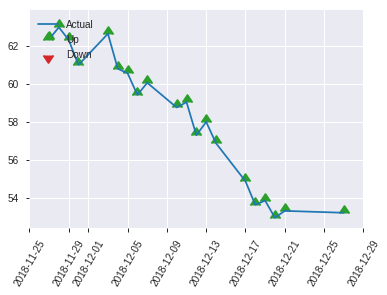


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24825563058680755
RMSE: 0.49825257710001614
LogLoss: 0.6896490258245419
Mean Per-Class Error: 0.44804138469547117
AUC: 0.5227095262883914
pr_auc: 0.5639193785953327
Gini: 0.045419052576782803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.476816386364817: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      1    135  0.0074   (1.0/136.0)
Total  3    246  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476816     0.706806  245
max f2                       0.47434      0.857503  248
max f0point5                 0.476816     0.602679  245
max accuracy                 0.476816     0.550201  245
max precision                0.56955      0.666667  2
max recall                   0.47434      1         248
max specificity              0.572773     0.99115   0
max absolute_mcc             0.552766     0.123915  55
max min_per_class_accuracy   0.543047     0.507353  122
max mean_per_class_accuracy  0.552766     0.551959  55

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 53.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0120482                   0.569037           1.22059   1.22059            0.666667         0.571467  0.666667                    0.571467            0.0147059       0.0147059                  22.0588    22.0588
    2        0.0200803                   0.568231           0         0.732353           0                0.568387  0.4                         0.570235            0               0.0147059                  -100       -26.7647
    3        0.0321285                   0.564656           0.610294  0.686581           0.333333         0.566173  0.375                       0.568712            0.00735294      0.0220588                  -38.9706   -31.3419
    4        0.0401606                   0.563248           0.915441  0.732353           0.5              0.564224  0.4                         0.567814            0.00735294      0.0294118                  -8.45588   -26.7647
    5        0.0522088                   0.5623             1.22059   0.845023           0.666667         0.56276   0.461538                    0.566648            0.0147059       0.0441176                  22.0588    -15.4977
    6        0.100402                    0.556719           1.37316   1.09853            0.75             0.559951  0.6                         0.563433            0.0661765       0.110294                   37.3162    9.85294
    7        0.15261                     0.555286           1.1267    1.10817            0.615385         0.556044  0.605263                    0.560906            0.0588235       0.169118                   12.6697    10.8166
    8        0.200803                    0.553054           1.37316   1.17176            0.75             0.553825  0.64                        0.559206            0.0661765       0.235294                   37.3162    17.1765
    9        0.301205                    0.551292           1.09853   1.14735            0.6              0.55216   0.626667                    0.556857            0.110294        0.345588                   9.85294    14.7353
    10       0.401606                    0.548046           0.732353  1.0436             0.4              0.549649  0.57                        0.555055            0.0735294       0.419118                   -26.7647   4.36029
    11       0.502008                    0.542814           0.878824  1.01065            0.48             0.545309  0.552                       0.553106            0.0882353       0.507353                   -12.1176   1.06471
    12       0.598394                    0.536342           0.991728  1.0076             0.541667         0.539868  0.550336                    0.550974            0.0955882       0.602941                   -0.827206  0.759968
    13       0.698795                    0.52932            1.02529   1.01014            0.56             0.532935  0.551724                    0.548382            0.102941        0.705882                   2.52941    1.0142
    14       0.799197                    0.523953           0.952059  1.00285            0.52             0.52691   0.547739                    0.545684            0.0955882       0.801471                   -4.79412   0.284511
    15       0.899598                    0.5128             0.878824  0.989003           0.48             0.519387  0.540179                    0.542749            0.0882353       0.889706                   -12.1176   -1.09966
    16       1                           0.47434            1.09853   1                  0.6              0.497249  0.546185              

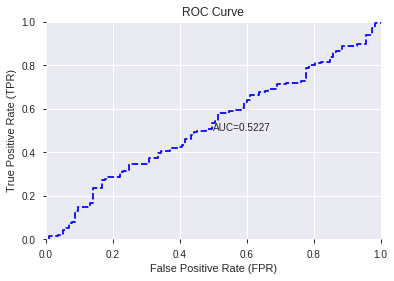

This function is available for GLM models only


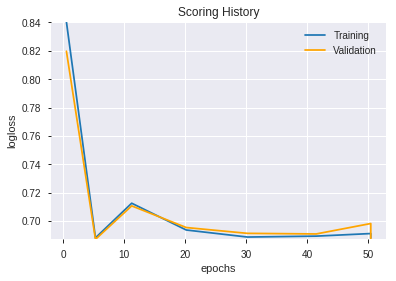

--2019-08-28 14:02:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_135502_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_135502_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'CORREL_12',
 'aroonup_30',
 'dayofyear',
 'STDDEV_8',
 'STOCH_slowd',
 'SAREXT',
 'STOCHRSI_fastd',
 'BETA_8',
 'aroondown_8',
 'aroondown_12',
 'day',
 'DX_14',
 'weekday',
 'BETA_30',
 'days_in_month',
 'CDLDOJI',
 'quarter',
 'COS',
 'month',
 'HT_PHASOR_inphase',
 'aroondown_20',
 'BOP',
 'DX_12',
 'WILLR_8',
 'ROC_8',
 'dayofweek',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'PLUS_DI_30',
 'STOCH_slowk',
 'DX_24',
 'ADXR_8',
 'weekofyear',
 'ROCP_8',
 'ADXR_12',
 'aroonup_14',
 'aroonup_24',
 'CCI_8',
 'DX_30',
 'ADXR_14',
 'week',
 'WILLR_12',
 'DX_20',
 'BETA_12',
 'CDLLONGLEGGEDDOJI',
 'WILLR_14',
 'STOCHF_fastk',
 'SIN',
 'HT_TRENDMODE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error   rmse       mse
0  GLM_grid_1_AutoML_20190828_140227_model_1  0.505726  0.689149                   0.5  0.498  0.248004

variable  relative_importance  scaled_importance  percentage
0                 day             0.009100           1.000000    0.059764
1                 COS             0.007911           0.869352    0.051956
2             BETA_30             0.007848           0.862435    0.051543
3             BETA_12             0.007197           0.790821    0.047263
4               ROC_8             0.006098           0.670075    0.040046
5              ROCP_8             0.006088           0.668964    0.039980
6              BETA_8             0.006068           0.666782    0.039850
7                 SIN             0.005911           0.649568    0.038821
8        weekday_name             0.005735           0.630240    0.037666
9              SAREXT             0.005656           0.621556    0.037147
10            WILLR_8             0.005129           0.563601    0.033683
11           WILLR_12             0.004997           0.549060    0.032814
12             ADXR_8             0.004873           0.535431    0.032000
13         PLUS_DI_30             0.004235           0.465414    0.027815
14        aroondown_8             0.004069           0.447129    0.026722
15           WILLR_14             0.004057           0.445775    0.026641
16       HT_TRENDMODE             0.003961           0.435222    0.026011
17  HT_PHASOR_inphase             0.003900           0.428562    0.025613
18           STDDEV_8             0.003561           0.391304    0.023386
19       STOCHF_fastk             0.003118           0.342631    0.020477
20         aroonup_14             0.003029           0.332897    0.019895
21            CDLDOJI             0.002949           0.323998    0.019363
22      days_in_month             0.002925           0.321367    0.019206
23              DX_30             0.002924           0.321254    0.019199
24       STOCHF_fastd             0.002811           0.308865    0.018459
25        STOCH_slowk             0.002796           0.307274    0.018364
26         aroonup_30             0.002418           0.265661    0.015877
27        STOCH_slowd             0.002266           0.248999    0.014881
28              DX_24             0.002026           0.222606    0.013304
29  CDLLONGLEGGEDDOJI             0.001986           0.218259    0.013044
30       aroondown_12             0.001725           0.189594    0.011331
31              DX_12             0.001557           0.171106    0.010226
32                BOP             0.001540           0.169212    0.010113
33          CORREL_12             0.001427           0.156849    0.009374
34            weekday             0.001232           0.135398    0.008092
35          dayofweek             0.001227           0.134864    0.008060
36       aroondown_20             0.001179           0.129553    0.007743
37              DX_14             0.001047           0.115026    0.006874
38              month             0.000956           0.105014    0.006276
39         aroonup_24             0.000904           0.099377    0.005939
40            quarter             0.000739           0.081158    0.004850
41              DX_20             0.000698           0.076701    0.004584
42     STOCHRSI_fastk             0.000693           0.076181    0.004553
43              CCI_8             0.000531           0.058391    0.003490
44            ADXR_12             0.000331           0.036410    0.002176
45         weekofyear             0.000302           0.033141    0.001981
46               week             0.000288           0.031673    0.001893
47          dayofyear             0.000209           0.023008    0.001375
48     STOCHRSI_fastd             0.000032           0.003500    0.000209
49            ADXR_14             0.000011           0.001226    0.000073

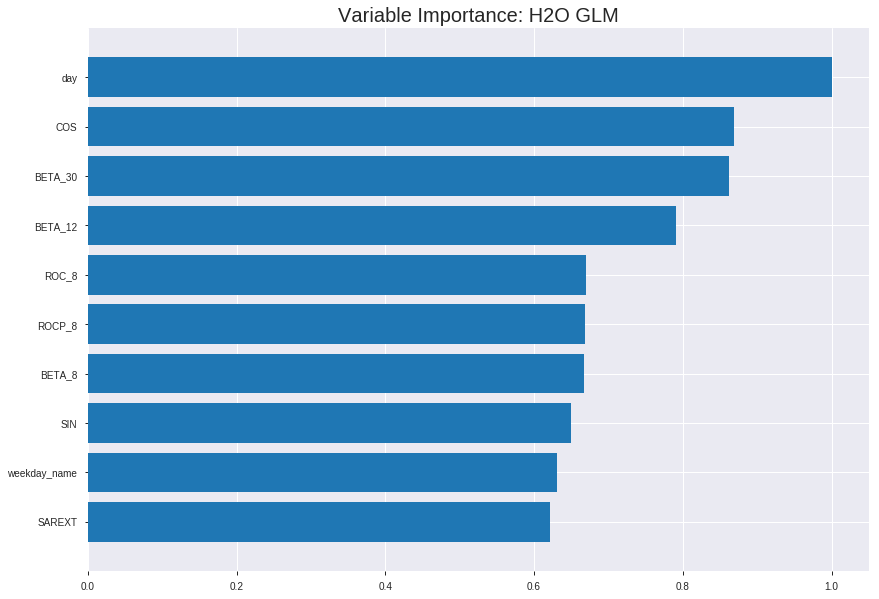

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_140227_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24671956986455704
RMSE: 0.49670873745541966
LogLoss: 0.6865612198534173
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2397.1076822559344
Residual deviance: 2390.606167529599
AIC: 2492.606167529599
AUC: 0.5498974195009525
pr_auc: 0.5921192880021678
Gini: 0.099794839001905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5212156985072253: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    780   0.9924   (780.0/786.0)
1      0    955   0        (0.0/955.0)
Total  6    1735  0.448    (780.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.521216     0.710037   395
max f2                       0.521216     0.859586   395
max f0point5                 0.533641     0.612735   333
max accuracy                 0.533641     0.568064   333
max precision                0.579632     1          0
max recall                   0.521216     1          395
max specificity              0.579632     1          0
max absolute_mcc             0.533641     0.0991199  333
max min_per_class_accuracy   0.548348     0.529262   200
max mean_per_class_accuracy  0.545674     0.535324   226

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.572342           1.11408   1.11408            0.611111         0.574962  0.611111                    0.574962            0.0115183       0.0115183                  11.4078   11.4078
    2        0.0201034                   0.570553           1.50132   1.30217            0.823529         0.571281  0.714286                    0.573174            0.0146597       0.026178                   50.1324   30.2169
    3        0.0304423                   0.568821           1.31664   1.30708            0.722222         0.569516  0.716981                    0.571931            0.0136126       0.0397906                  31.6638   30.7083
    4        0.0402068                   0.567678           1.07237   1.25008            0.588235         0.56827   0.685714                    0.571042            0.0104712       0.0502618                  7.23745   25.0082
    5        0.0505457                   0.566619           1.0128    1.20155            0.555556         0.567149  0.659091                    0.570246            0.0104712       0.060733                   1.27981   20.1547
    6        0.100517                    0.563407           1.13154   1.16674            0.62069          0.564831  0.64                        0.567554            0.0565445       0.117277                   13.154    16.6743
    7        0.150488                    0.560815           1.11059   1.1481             0.609195         0.562102  0.629771                    0.565744            0.0554974       0.172775                   11.0586   14.8096
    8        0.20046                     0.558916           1.15249   1.14919            0.632184         0.559771  0.630372                    0.564255            0.0575916       0.230366                   15.2494   14.9192
    9        0.300402                    0.555127           0.953427  1.08406            0.522989         0.55699   0.594646                    0.561838            0.095288        0.325654                   -4.65728  8.40619
    10       0.400345                    0.55184            0.995336  1.06191            0.545977         0.553507  0.582496                    0.559758            0.0994764       0.425131                   -0.46639  6.19123
    11       0.500287                    0.548436           1.02677   1.05489            0.563218         0.550159  0.578645                    0.55784             0.102618        0.527749                   2.67678   5.48915
    12       0.60023                     0.545394           1.00581   1.04672            0.551724         0.546872  0.574163                    0.556014            0.100524        0.628272                   0.581332  4.67196
    13       0.700172                    0.541965           0.963904  1.0349             0.528736         0.543661  0.567678                    0.554251            0.0963351       0.724607                   -3.60956  3.48986
    14       0.800115                    0.538151           1.03724   1.03519            0.568966         0.540242  0.567839                    0.552501            0.103665        0.828272                   3.7245    3.51917
    15       0.900057                    0.534004           0.953427  1.02611            0.522989         0.536196  0.562859                    0.55069             0.095288        0.92356                    -4.65728  2.61125
    16       1                           0.516168           0.764837  1                  0.41954          0.529126  0.548535                    0.548535         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24789651531420154
RMSE: 0.49789207195355256
LogLoss: 0.6889329523517473
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 686.5201497057026
Residual deviance: 686.1772205423404
AIC: 788.1772205423404
AUC: 0.5204983988165873
pr_auc: 0.5554094557626075
Gini: 0.04099679763317465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5231187621536313: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.523119     0.704811   399
max f2                       0.523119     0.856511   399
max f0point5                 0.523119     0.598763   399
max accuracy                 0.540713     0.552209   301
max precision                0.575006     0.636364   10
max recall                   0.523119     1          399
max specificity              0.584888     0.995595   0
max absolute_mcc             0.530479     0.0692275  382
max min_per_class_accuracy   0.549743     0.512915   201
max mean_per_class_accuracy  0.543672     0.530813   271

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 55.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.578254           0.735055  0.735055           0.4              0.581915  0.4                         0.581915            0.00738007      0.00738007                 -26.4945   -26.4945
    2        0.0200803                   0.575017           1.47011   1.10258            0.8              0.576536  0.6                         0.579225            0.0147601       0.0221402                  47.0111    10.2583
    3        0.0301205                   0.571925           0.735055  0.980074           0.4              0.573462  0.533333                    0.577304            0.00738007      0.0295203                  -26.4945   -1.99262
    4        0.0401606                   0.570434           1.10258   1.0107             0.6              0.571174  0.55                        0.575772            0.0110701       0.0405904                  10.2583    1.07011
    5        0.0502008                   0.569794           1.10258   1.02908            0.6              0.57009   0.56                        0.574635            0.0110701       0.0516605                  10.2583    2.90775
    6        0.100402                    0.565612           1.02908   1.02908            0.56             0.567547  0.56                        0.571091            0.0516605       0.103321                   2.90775    2.90775
    7        0.150602                    0.563446           1.10258   1.05358            0.6              0.564338  0.573333                    0.56884             0.0553506       0.158672                   10.2583    5.35793
    8        0.200803                    0.560895           0.955572  1.02908            0.52             0.562     0.56                        0.56713             0.0479705       0.206642                   -4.4428    2.90775
    9        0.301205                    0.557896           1.10258   1.05358            0.6              0.559327  0.573333                    0.564529            0.110701        0.317343                   10.2583    5.35793
    10       0.399598                    0.553625           1.05008   1.05272            0.571429         0.555813  0.572864                    0.562383            0.103321        0.420664                   5.00791    5.27175
    11       0.5                         0.549458           0.918819  1.02583            0.5              0.551651  0.558233                    0.560228            0.0922509       0.512915                   -8.11808   2.58303
    12       0.600402                    0.545785           0.955572  1.01408            0.52             0.54795   0.551839                    0.558175            0.095941        0.608856                   -4.4428    1.40814
    13       0.698795                    0.542816           1.12508   1.02971            0.612245         0.544356  0.560345                    0.556229            0.110701        0.719557                   12.5085    2.97112
    14       0.799197                    0.539796           0.845314  1.00655            0.46             0.541241  0.547739                    0.554346            0.0848708       0.804428                   -15.4686   0.654564
    15       0.899598                    0.535483           0.955572  1.00086            0.52             0.537848  0.544643                    0.552505            0.095941        0.900369                   -4.4428    0.0856616
    16       1                           0.523119           0.992325  1                  0.54             0.531313  0.544177               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 14:02:27  0.000 sec   2            2.2       51            1.37312           1.37787
    2019-08-28 14:02:27  0.082 sec   4            1.4       51            1.37169           1.37817
    2019-08-28 14:02:27  0.167 sec   6            0.84      51            1.3699            1.37886
    2019-08-28 14:02:28  0.252 sec   8            0.52      51            1.36778           1.38008
    2019-08-28 14:02:28  0.323 sec   10           0.32      51            1.36546           1.38199
    2019-08-28 14:02:28  0.404 sec   12           0.2       51            1.36312           1.38464

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.7064935064935065)

('auc', 0.5057261842790214)

('logloss', 0.6891488755595808)

('mean_per_class_error', 0.44423477355543994)

('rmse', 0.4980003062576519)

('mse', 0.24800430503271512)

glm prediction progress: |████████████████████████████████████████████████| 100%


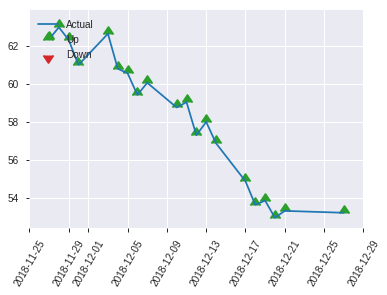


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24800430503271512
RMSE: 0.4980003062576519
LogLoss: 0.6891488755595808
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 343.0653203047996
Residual deviance: 343.19614002867127
AIC: 445.19614002867127
AUC: 0.5057261842790214
pr_auc: 0.5692795188731846
Gini: 0.01145236855804277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.525426650425466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    136  0        (0.0/136.0)
Total  0    249  0.4538   (113.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.525427     0.706494  248
max f2                       0.525427     0.857503  248
max f0point5                 0.525427     0.600707  248
max accuracy                 0.545665     0.550201  185
max precision                0.563729     0.742857  34
max recall                   0.525427     1         248
max specificity              0.582686     0.99115   0
max absolute_mcc             0.563729     0.159757  34
max min_per_class_accuracy   0.552334     0.485294  121
max mean_per_class_accuracy  0.563729     0.555765  34

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 55.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.575542           0.610294  0.610294           0.333333         0.579164  0.333333                    0.579164            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.572702           1.83088   1.09853            1                0.573894  0.6                         0.577056            0.0147059       0.0220588                  83.0882   9.85294
    3        0.0321285                   0.571557           1.22059   1.1443             0.666667         0.572267  0.625                       0.57526             0.0147059       0.0367647                  22.0588   14.4301
    4        0.0401606                   0.570153           1.83088   1.28162            1                0.57061   0.7                         0.57433             0.0147059       0.0514706                  83.0882   28.1618
    5        0.0522088                   0.568876           1.22059   1.26753            0.666667         0.56949   0.692308                    0.573213            0.0147059       0.0661765                  22.0588   26.7534
    6        0.100402                    0.564695           1.37316   1.31824            0.75             0.566285  0.72                        0.569888            0.0661765       0.132353                   37.3162   31.8235
    7        0.15261                     0.562822           1.1267    1.25271            0.615385         0.563987  0.684211                    0.567869            0.0588235       0.191176                   12.6697   25.2709
    8        0.200803                    0.561049           0.610294  1.09853            0.333333         0.56203   0.6                         0.566468            0.0294118       0.220588                   -38.9706  9.85294
    9        0.301205                    0.558359           0.732353  0.976471           0.4              0.559713  0.533333                    0.564216            0.0735294       0.294118                   -26.7647  -2.35294
    10       0.401606                    0.555468           0.878824  0.952059           0.48             0.556798  0.52                        0.562362            0.0882353       0.382353                   -12.1176  -4.79412
    11       0.502008                    0.552143           1.02529   0.966706           0.56             0.553658  0.528                       0.560621            0.102941        0.485294                   2.52941   -3.32941
    12       0.598394                    0.549343           1.29688   1.01989            0.708333         0.550663  0.557047                    0.559017            0.125           0.610294                   29.6875   1.98875
    13       0.698795                    0.546762           0.878824  0.99962            0.48             0.548144  0.545977                    0.557455            0.0882353       0.698529                   -12.1176  -0.0380325
    14       0.799197                    0.544256           1.02529   1.00285            0.56             0.545612  0.547739                    0.555967            0.102941        0.801471                   2.52941   0.284511
    15       0.899598                    0.539286           0.878824  0.989003           0.48             0.541882  0.540179                    0.554395            0.0882353       0.889706                   -12.1176  -1.09966
    16       1                           0.525427           1.09853   1                  0.6              0.533641  0.546185                    0.552311

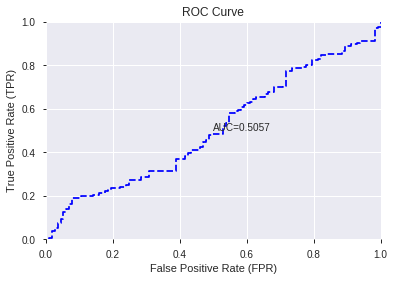

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


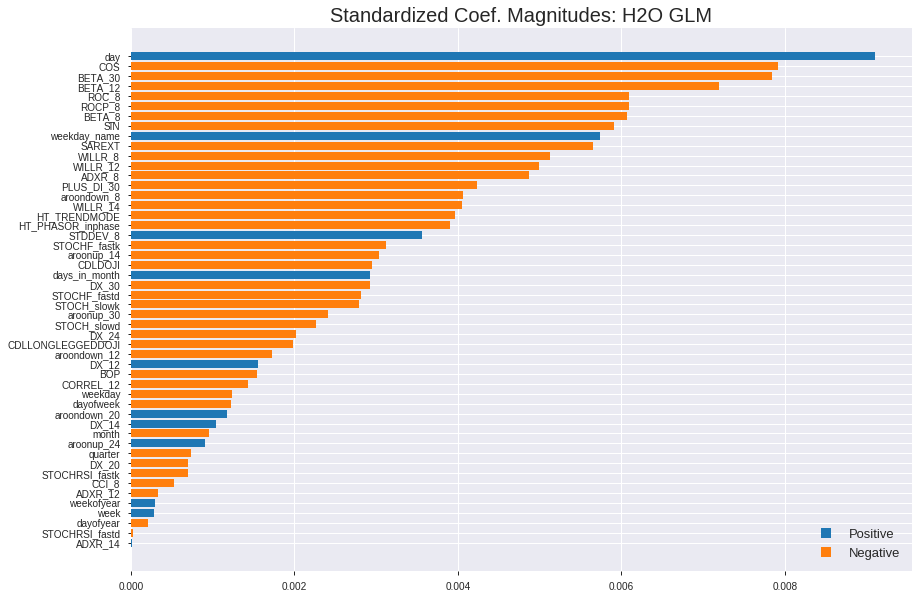

'log_likelihood'
--2019-08-28 14:02:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_140227_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_140227_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['day',
 'COS',
 'BETA_30',
 'BETA_12',
 'ROC_8',
 'ROCP_8',
 'BETA_8',
 'SIN',
 'weekday_name',
 'SAREXT',
 'WILLR_8',
 'WILLR_12',
 'ADXR_8',
 'PLUS_DI_30',
 'aroondown_8',
 'WILLR_14',
 'HT_TRENDMODE',
 'HT_PHASOR_inphase',
 'STDDEV_8',
 'STOCHF_fastk',
 'aroonup_14',
 'CDLDOJI',
 'days_in_month',
 'DX_30',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_30',
 'STOCH_slowd',
 'DX_24',
 'CDLLONGLEGGEDDOJI',
 'aroondown_12',
 'DX_12',
 'BOP',
 'CORREL_12',
 'weekday',
 'dayofweek',
 'aroondown_20',
 'DX_14',
 'month',
 'aroonup_24',
 'quarter',
 'DX_20',
 'STOCHRSI_fastk',
 'CCI_8',
 'ADXR_12',
 'weekofyear',
 'week',
 'dayofyear',
 'STOCHRSI_fastd',
 'ADXR_14']

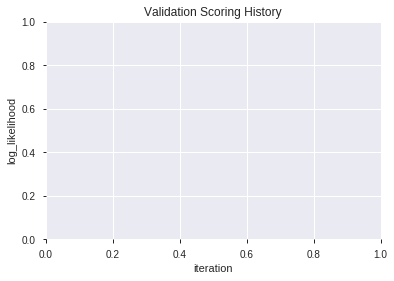

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190828_140245  0.567998  0.691005              0.491150  0.498159  0.248163
1  XGBoost_grid_1_AutoML_20190828_140245_model_7  0.529477  0.703621              0.500000  0.504527  0.254547
2  XGBoost_grid_1_AutoML_20190828_140245_model_3  0.524271  0.694989              0.495575  0.500682  0.250683
3  XGBoost_grid_1_AutoML_20190828_140245_model_1  0.516072  0.696849              0.491150  0.501360  0.251362
4               XGBoost_2_AutoML_20190828_140245  0.514381  0.697105              0.495575  0.501818  0.251821
5  XGBoost_grid_1_AutoML_20190828_140245_model_5  0.510932  0.726839              0.500000  0.515583  0.265826
6  XGBoost_grid_1_AutoML_20190828_140245_model_4  0.507939  0.695227              0.500000  0.501007  0.251008
7  XGBoost_grid_1_AutoML_20190828_140245_model_2  0.501432  0.699747              0.500000  0.503229  0.253239
8               XGBoost_3_AutoML_20190828_140245  0.497527  0.704657              0.495575  0.505371  0.255400
9  XGBoost_grid_1_AutoML_20190828_140245_model_6  0.486986  0.702906              0.495575  0.504632  0.254654

variable  relative_importance  scaled_importance  percentage
0                 COS           314.813202           1.000000    0.042820
1             BETA_12           311.518463           0.989534    0.042372
2                 SIN           304.263306           0.966488    0.041385
3            STDDEV_8           290.116730           0.921552    0.039461
4             BETA_30           287.724884           0.913954    0.039135
5                 BOP           275.571808           0.875350    0.037482
6                 day           269.907318           0.857357    0.036712
7              SAREXT           258.146790           0.820000    0.035112
8              ADXR_8           225.617691           0.716672    0.030688
9           CORREL_12           222.741302           0.707535    0.030296
10  HT_PHASOR_inphase           210.885742           0.669876    0.028684
11          dayofyear           206.086441           0.654631    0.028031
12             BETA_8           196.657120           0.624679    0.026749
13       STOCHF_fastk           193.829376           0.615696    0.026364
14              CCI_8           191.505005           0.608313    0.026048
15            ADXR_12           185.871140           0.590417    0.025282
16     STOCHRSI_fastd           183.733368           0.583627    0.024991
17              DX_30           183.256653           0.582112    0.024926
18              DX_14           179.932678           0.571554    0.024474
19         PLUS_DI_30           179.002945           0.568601    0.024347
20              DX_24           165.240433           0.524884    0.022475
21            ADXR_14           164.851746           0.523649    0.022423
22           WILLR_12           162.598541           0.516492    0.022116
23            WILLR_8           158.953903           0.504915    0.021620
24        STOCH_slowd           156.012039           0.495570    0.021220
25              DX_12           153.323242           0.487029    0.020854
26         aroonup_24           149.096771           0.473604    0.020280
27              DX_20           140.393387           0.445958    0.019096
28        STOCH_slowk           139.209610           0.442197    0.018935
29           WILLR_14           127.823486           0.406030    0.017386
30              ROC_8           127.378517           0.404616    0.017326
31     STOCHRSI_fastk           124.823158           0.396499    0.016978
32          dayofweek           100.072571           0.317879    0.013612
33       aroondown_20            91.439369           0.290456    0.012437
34        aroondown_8            89.953712           0.285737    0.012235
35               week            89.023666           0.282783    0.012109
36         aroonup_14            87.603516           0.278271    0.011916
37             ROCP_8            81.988419           0.260435    0.011152
38       STOCHF_fastd            66.944946           0.212650    0.009106
39       aroondown_12            66.528717           0.211328    0.009049
40         aroonup_30            56.477291           0.179399    0.007682
41         weekofyear            54.388519           0.172764    0.007398
42       weekday_name            51.808514           0.164569    0.007047
43      days_in_month            31.954287           0.101502    0.004346
44              month            20.146818           0.063996    0.002740
45            weekday            12.415464           0.039438    0.001689
46            quarter             6.788660           0.021564    0.000923
47            CDLDOJI             3.632870           0.011540    0.000494

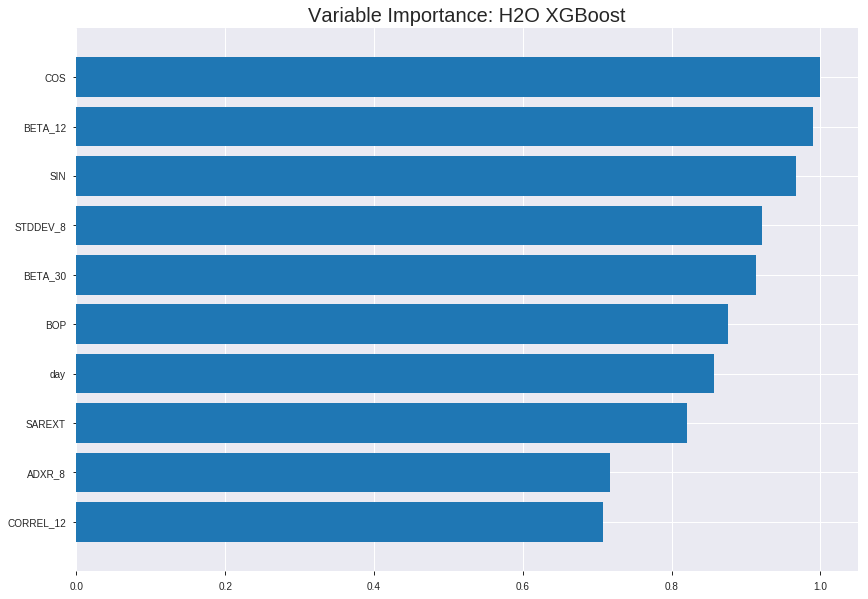

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190828_140245


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15609789582422637
RMSE: 0.3950922624200914
LogLoss: 0.49758996190229765
Mean Per-Class Error: 0.08634080705540681
AUC: 0.9738526304570827
pr_auc: 0.9786087566203592
Gini: 0.9477052609141654
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5305642485618591: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      712  74   0.0941   (74.0/786.0)
1      75   880  0.0785   (75.0/955.0)
Total  787  954  0.0856   (149.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530564     0.921949  206
max f2                       0.477735     0.947507  246
max f0point5                 0.560082     0.936269  184
max accuracy                 0.530564     0.914417  206
max precision                0.825783     1         0
max recall                   0.373306     1         329
max specificity              0.825783     1         0
max absolute_mcc             0.530564     0.827226  206
max min_per_class_accuracy   0.533751     0.908901  203
max mean_per_class_accuracy  0.530564     0.913659  206

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.785759           1.82304    1.82304            1                0.798076  1                           0.798076            0.0188482       0.0188482                  82.3037   82.3037
    2        0.0201034                   0.768202           1.82304    1.82304            1                0.774617  1                           0.786682            0.017801        0.0366492                  82.3037   82.3037
    3        0.0304423                   0.756216           1.82304    1.82304            1                0.761873  1                           0.778256            0.0188482       0.0554974                  82.3037   82.3037
    4        0.0402068                   0.748238           1.82304    1.82304            1                0.752243  1                           0.771939            0.017801        0.0732984                  82.3037   82.3037
    5        0.0505457                   0.74083            1.82304    1.82304            1                0.744337  1                           0.766293            0.0188482       0.0921466                  82.3037   82.3037
    6        0.100517                    0.716683           1.82304    1.82304            1                0.728672  1                           0.74759             0.0910995       0.183246                   82.3037   82.3037
    7        0.150488                    0.697628           1.82304    1.82304            1                0.707723  1                           0.734352            0.0910995       0.274346                   82.3037   82.3037
    8        0.20046                     0.679058           1.82304    1.82304            1                0.686038  1                           0.722308            0.0910995       0.365445                   82.3037   82.3037
    9        0.300402                    0.638765           1.80208    1.81607            0.988506         0.657804  0.996176                    0.700848            0.180105        0.54555                    80.2082   81.6065
    10       0.400345                    0.599292           1.77065    1.80473            0.971264         0.619572  0.989957                    0.680558            0.176963        0.722513                   77.0651   80.4728
    11       0.500287                    0.549652           1.46681    1.73722            0.804598         0.574153  0.952928                    0.659301            0.146597        0.86911                    46.6811   73.7222
    12       0.60023                     0.501128           0.880087   1.5945             0.482759         0.527702  0.874641                    0.637389            0.0879581       0.957068                   -11.9913  59.4503
    13       0.700172                    0.452145           0.314317   1.41177            0.172414         0.474713  0.774405                    0.614169            0.0314136       0.988482                   -68.5683  41.1769
    14       0.800115                    0.406764           0.0838178  1.24589            0.045977         0.429809  0.683417                    0.59114             0.00837696      0.996859                   -91.6182  24.5894
    15       0.900057                    0.356361           0.0314317  1.11104            0.0172414        0.381979  0.609445                    0.567915            0.00314136      1                          -96.8568  11.104
    16       1                           0.207447           0          1                  0                0.3174    0.548535                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2553999451703856
RMSE: 0.5053710964928501
LogLoss: 0.7050989110242495
Mean Per-Class Error: 0.46529414633353383
AUC: 0.518815937058049
pr_auc: 0.5694960580624395
Gini: 0.03763187411609792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2676508128643036: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267651     0.704811  399
max f2                       0.267651     0.856511  399
max f0point5                 0.267651     0.598763  399
max accuracy                 0.267651     0.544177  399
max precision                0.832575     1         0
max recall                   0.267651     1         399
max specificity              0.832575     1         0
max absolute_mcc             0.347311     0.116943  391
max min_per_class_accuracy   0.571685     0.523985  198
max mean_per_class_accuracy  0.576902     0.534706  190

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 56.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.778267           1.10258   1.10258            0.6              0.808187  0.6                         0.808187            0.0110701       0.0110701                  10.2583    10.2583
    2        0.0200803                   0.750672           1.47011   1.28635            0.8              0.766073  0.7                         0.78713             0.0147601       0.0258303                  47.0111    28.6347
    3        0.0301205                   0.730855           0.735055  1.10258            0.4              0.740034  0.6                         0.771432            0.00738007      0.0332103                  -26.4945   10.2583
    4        0.0401606                   0.717395           1.83764   1.28635            1                0.724335  0.7                         0.759657            0.0184502       0.0516605                  83.7638    28.6347
    5        0.0502008                   0.708044           1.47011   1.3231             0.8              0.713352  0.72                        0.750396            0.0147601       0.0664207                  47.0111    32.31
    6        0.100402                    0.676462           1.10258   1.21284            0.6              0.691933  0.66                        0.721165            0.0553506       0.121771                   10.2583    21.2841
    7        0.150602                    0.656686           0.66155   1.02908            0.36             0.666236  0.56                        0.702855            0.0332103       0.154982                   -33.845    2.90775
    8        0.200803                    0.638945           0.882066  0.992325           0.48             0.648419  0.54                        0.689246            0.0442804       0.199262                   -11.7934   -0.767528
    9        0.301205                    0.615412           1.10258   1.02908            0.6              0.626717  0.56                        0.668403            0.110701        0.309963                   10.2583    2.90775
    10       0.399598                    0.5977             1.16259   1.06195            0.632653         0.606264  0.577889                    0.653103            0.114391        0.424354                   16.2588    6.19518
    11       0.5                         0.571485           0.992325  1.04797            0.54             0.583045  0.570281                    0.639035            0.099631        0.523985                   -0.767528  4.79705
    12       0.600402                    0.550348           0.955572  1.03252            0.52             0.560403  0.561873                    0.625886            0.095941        0.619926                   -4.4428    3.25192
    13       0.698795                    0.526234           0.825062  1.00331            0.44898          0.539013  0.545977                    0.613653            0.0811808       0.701107                   -17.4938   0.330831
    14       0.799197                    0.490866           0.882066  0.988077           0.48             0.510112  0.537688                    0.600646            0.0885609       0.789668                   -11.7934   -1.19231
    15       0.899598                    0.44328            1.06583   0.996755           0.58             0.470216  0.542411                    0.586089            0.107011        0.896679                   6.58303    -0.324526
    16       1                           0.267651           1.02908   1                  0.56             0.391836  0.544177                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:02:45  0.272 sec   0                  0.5              0.693147            0.5             0                  1                0.451465                         0.5                0.693147              0.5               0                    1                  0.455823
    2019-08-28 14:02:45  0.503 sec   5                  0.486117         0.665697            0.793858        0.813828           1.72176          0.290063                         0.498263           0.689671              0.525497          0.563054             1.10258            0.455823
    2019-08-28 14:02:46  0.656 sec   10                 0.472564         0.639421            0.863354        0.882189           1.82304          0.215393                         0.49585            0.684826              0.558309          0.59778              1.47011            0.453815
    2019-08-28 14:02:46  0.783 sec   15                 0.462238         0.619713            0.891568        0.909087           1.82304          0.201034                         0.497127           0.68735               0.538331          0.585928             1.47011            0.453815
    2019-08-28 14:02:46  0.916 sec   20                 0.450742         0.598079            0.915655        0.929094           1.82304          0.160827                         0.497925           0.688931              0.53278           0.583914             1.47011            0.453815
    2019-08-28 14:02:46  1.050 sec   25                 0.440193         0.578435            0.929585        0.941328           1.82304          0.149339                         0.498894           0.690947              0.531056          0.577116             1.10258            0.453815
    2019-08-28 14:02:46  1.197 sec   30                 0.43069          0.561002            0.943138        0.951566           1.82304          0.131534                         0.499779           0.692798              0.53343           0.582181             1.10258            0.455823
    2019-08-28 14:02:46  1.344 sec   35                 0.421634         0.544644            0.955014        0.962881           1.82304          0.126939                         0.500617           0.6946                0.529496          0.581472             1.10258            0.455823
    2019-08-28 14:02:46  1.485 sec   40                 0.412672         0.528503            0.961464        0.968929           1.82304          0.108558                         0.502692           0.698939              0.52292           0.579877             1.10258            0.455823
    2019-08-28 14:02:47  1.626 sec   45                 0.403668         0.512572            0.9684          0.974298           1.82304          0.097645                         0.50402            0.701909              0.519523          0.571098             1.10258            0.455823
    2019-08-28 14:02:47  1.758 sec   50                 0.395092         0.49759             0.973853        0.978609           1.82304          0.085583                         0.505371           0.705099              0.518816          0.569496             1.10258            0.455823

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ---------------------
COS            314.8132019042969      1.0                   0.0428197611375886
BETA_12        311.5184631347656      0.9895343055831157    0.04237162260251862
SIN            304.2633056640625      0.966488393191841     0.041384802138726445
STDDEV_8       290.1167297363281      0.9215519806076098    0.039460635685489534
BETA_30        287.7248840332031      0.9139543141544344    0.039135305422761495
---            ---                    ---                   ---
days_in_month  31.954286575317383     0.10150237150801407   0.004346307302871941
month          20.146818161010742     0.06399610321023122   0.002740297853198568
weekday        12.415464401245117     0.039437559562763874  0.0016887068803269722
quarter        6.788660049438477      0.02156408946122351   0.0009233691598791822
CDLDOJI        3.6328697204589844     0.011539762940320959  0.0004941298926889405


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5983935742971888)

('F1', 0.7101827676240209)

('auc', 0.5679984383133785)

('logloss', 0.6910051154356327)

('mean_per_class_error', 0.40581077563768875)

('rmse', 0.49815927609371163)

('mse', 0.24816266435821083)

xgboost prediction progress: |████████████████████████████████████████████| 100%


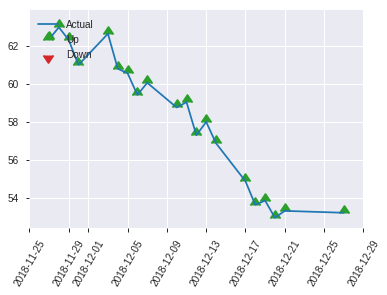


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24816266435821083
RMSE: 0.49815927609371163
LogLoss: 0.6910051154356327
Mean Per-Class Error: 0.40581077563768875
AUC: 0.5679984383133785
pr_auc: 0.5636326754835538
Gini: 0.13599687662675697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3239525258541107: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    136  0        (0.0/136.0)
Total  2    247  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323953     0.710183  246
max f2                       0.323953     0.859671  246
max f0point5                 0.560619     0.632267  137
max accuracy                 0.560619     0.598394  137
max precision                0.617792     0.653333  74
max recall                   0.323953     1         246
max specificity              0.781668     0.99115   0
max absolute_mcc             0.560619     0.188686  137
max min_per_class_accuracy   0.580739     0.557522  125
max mean_per_class_accuracy  0.560619     0.594189  137

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 56.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.740511           0.610294  0.610294           0.333333         0.761319  0.333333                    0.761319            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.733527           0         0.366176           0                0.738346  0.2                         0.75213             0               0.00735294                 -100      -63.3824
    3        0.0321285                   0.723655           1.22059   0.686581           0.666667         0.728763  0.375                       0.743367            0.0147059       0.0220588                  22.0588   -31.3419
    4        0.0401606                   0.714445           0.915441  0.732353           0.5              0.718584  0.4                         0.738411            0.00735294      0.0294118                  -8.45588  -26.7647
    5        0.0522088                   0.708672           0.610294  0.704186           0.333333         0.712454  0.384615                    0.732421            0.00735294      0.0367647                  -38.9706  -29.5814
    6        0.100402                    0.677738           0.610294  0.659118           0.333333         0.693514  0.36                        0.713746            0.0294118       0.0661765                  -38.9706  -34.0882
    7        0.15261                     0.659633           1.40837   0.915441           0.769231         0.668724  0.5                         0.698343            0.0735294       0.139706                   40.8371   -8.45588
    8        0.200803                    0.642418           1.52574   1.06191            0.833333         0.650675  0.58                        0.686903            0.0735294       0.213235                   52.5735   6.19118
    9        0.301205                    0.617366           1.46471   1.19618            0.8              0.628817  0.653333                    0.667541            0.147059        0.360294                   46.4706   19.6176
    10       0.401606                    0.601115           0.878824  1.11684            0.48             0.608498  0.61                        0.65278             0.0882353       0.448529                   -12.1176  11.6838
    11       0.502008                    0.581304           1.02529   1.09853            0.56             0.590814  0.6                         0.640387            0.102941        0.551471                   2.52941   9.85294
    12       0.598394                    0.551012           1.22059   1.11819            0.666667         0.56382   0.610738                    0.628054            0.117647        0.669118                   22.0588   11.819
    13       0.698795                    0.519812           0.659118  1.05223            0.36             0.536557  0.574713                    0.614908            0.0661765       0.735294                   -34.0882  5.22312
    14       0.799197                    0.49265            1.02529   1.04885            0.56             0.507766  0.572864                    0.601448            0.102941        0.838235                   2.52941   4.88472
    15       0.899598                    0.46161            0.805588  1.0217             0.44             0.475529  0.558036                    0.587394            0.0808824       0.919118                   -19.4412  2.16977
    16       1                           0.254368           0.805588  1                  0.44             0.396089  0.546185                    0.568187   

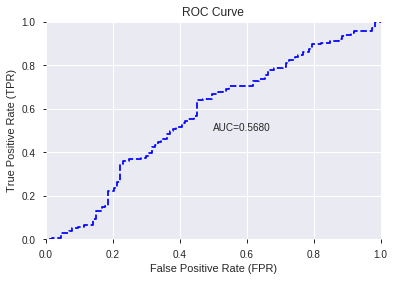

This function is available for GLM models only


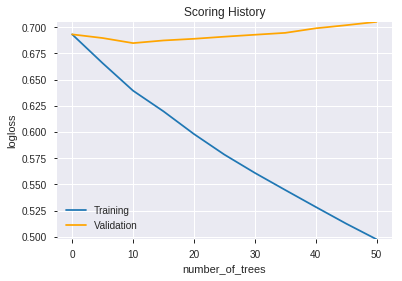

--2019-08-28 14:03:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190828_140245',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190828_140245',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_a1f3',
   'type

['COS',
 'BETA_12',
 'SIN',
 'STDDEV_8',
 'BETA_30',
 'BOP',
 'day',
 'SAREXT',
 'ADXR_8',
 'CORREL_12',
 'HT_PHASOR_inphase',
 'dayofyear',
 'BETA_8',
 'STOCHF_fastk',
 'CCI_8',
 'ADXR_12',
 'STOCHRSI_fastd',
 'DX_30',
 'DX_14',
 'PLUS_DI_30',
 'DX_24',
 'ADXR_14',
 'WILLR_12',
 'WILLR_8',
 'STOCH_slowd',
 'DX_12',
 'aroonup_24',
 'DX_20',
 'STOCH_slowk',
 'WILLR_14',
 'ROC_8',
 'STOCHRSI_fastk',
 'dayofweek',
 'aroondown_20',
 'aroondown_8',
 'week',
 'aroonup_14',
 'ROCP_8',
 'STOCHF_fastd',
 'aroondown_12',
 'aroonup_30',
 'weekofyear',
 'weekday_name',
 'days_in_month',
 'month',
 'weekday',
 'quarter',
 'CDLDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_140314_model_1  0.499935  0.690509               0.49115  0.498656  0.248658

variable  relative_importance  scaled_importance    percentage
0                          day         7.167917e-03           1.000000  9.942456e-03
1                         SINH         6.770981e-03           0.944623  9.391874e-03
2                         COSH         6.758505e-03           0.942883  9.374570e-03
3                          EXP         6.753762e-03           0.942221  9.367991e-03
4          CDLXSIDEGAP3METHODS         6.701663e-03           0.934953  9.295725e-03
...                        ...                  ...                ...           ...
1038                   MA_20_6         8.213309e-08           0.000011  1.139250e-07
1039  BBANDS_middleband_20_0_2         6.144245e-08           0.000009  8.522544e-08
1040   BBANDS_upperband_14_1_2         1.355644e-08           0.000002  1.880383e-08
1041  BBANDS_middleband_20_6_4         0.000000e+00           0.000000  0.000000e+00
1042  BBANDS_middleband_20_6_5         0.000000e+00           0.000000  0.000000e+00

[1043 rows x 4 columns]

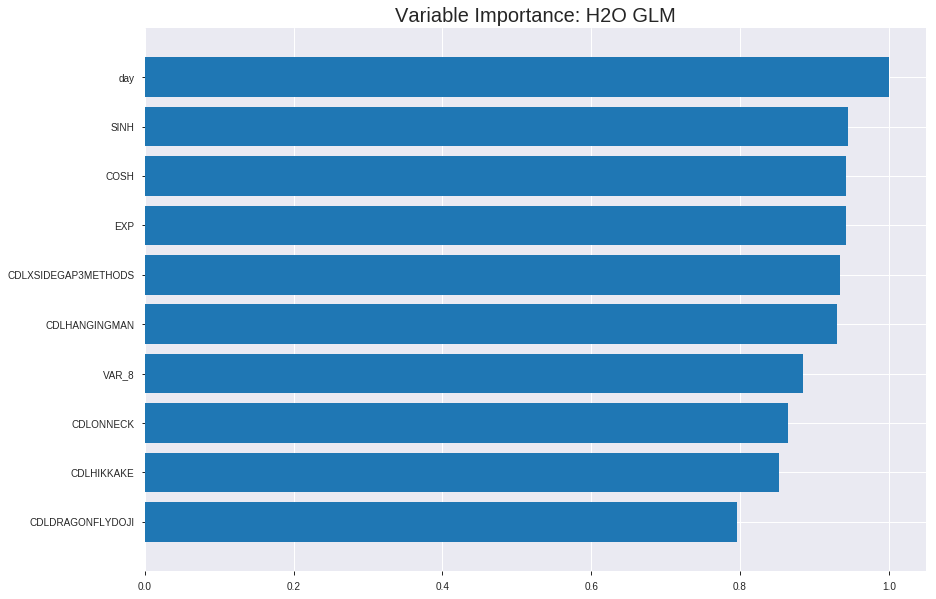

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_140314_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24380541336040074
RMSE: 0.49376655755569426
LogLoss: 0.6806227624518659
Null degrees of freedom: 1740
Residual degrees of freedom: 699
Null deviance: 2397.1076822559344
Residual deviance: 2369.928458857398
AIC: 4453.928458857397
AUC: 0.5796477625461279
pr_auc: 0.6248331830921411
Gini: 0.15929552509225586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4930233070959487: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   761   0.9682   (761.0/786.0)
1      8    947   0.0084   (8.0/955.0)
Total  33   1708  0.4417   (769.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493023     0.711228  375
max f2                       0.445675     0.859431  394
max f0point5                 0.508041     0.615427  340
max accuracy                 0.539418     0.575531  238
max precision                0.673525     1         0
max recall                   0.445675     1         394
max specificity              0.673525     1         0
max absolute_mcc             0.539418     0.141372  238
max min_per_class_accuracy   0.543816     0.559796  222
max mean_per_class_accuracy  0.539418     0.570537  238

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.62682            1.62048   1.62048            0.888889         0.638934  0.888889                    0.638934            0.0167539       0.0167539                  62.0477   62.0477
    2        0.0201034                   0.619709           1.39409   1.51052            0.764706         0.622919  0.828571                    0.631155            0.0136126       0.0303665                  39.4087   51.0516
    3        0.0304423                   0.614072           1.41792   1.47907            0.777778         0.616683  0.811321                    0.62624             0.0146597       0.0450262                  41.7917   47.9067
    4        0.0402068                   0.610501           1.17961   1.40634            0.647059         0.612368  0.771429                    0.622871            0.0115183       0.0565445                  17.9612   40.6343
    5        0.0505457                   0.607202           1.31664   1.38799            0.722222         0.608767  0.761364                    0.619986            0.0136126       0.0701571                  31.6638   38.7994
    6        0.100517                    0.597242           1.11059   1.25008            0.609195         0.602017  0.685714                    0.611053            0.0554974       0.125654                   11.0586   25.0082
    7        0.150488                    0.586732           1.13154   1.21072            0.62069          0.591272  0.664122                    0.604484            0.0565445       0.182199                   13.154    21.0719
    8        0.20046                     0.57912            1.06868   1.17531            0.586207         0.58218   0.644699                    0.598924            0.0534031       0.235602                   6.86767   17.531
    9        0.300402                    0.565784           0.94295   1.098              0.517241         0.572071  0.602294                    0.58999             0.0942408       0.329843                   -5.705    9.80049
    10       0.400345                    0.554106           1.13154   1.10638            0.62069          0.559218  0.606887                    0.582308            0.113089        0.442932                   13.154    10.6377
    11       0.500287                    0.544067           1.08963   1.10303            0.597701         0.548913  0.605052                    0.575637            0.108901        0.551832                   8.96311   10.3031
    12       0.60023                     0.535565           1.04772   1.09382            0.574713         0.54016   0.6                         0.56973             0.104712        0.656545                   4.77222   9.3822
    13       0.700172                    0.527767           0.911518  1.0678             0.5              0.531619  0.585726                    0.56429             0.0910995       0.747644                   -8.84817  6.78
    14       0.800115                    0.520026           0.880087  1.04435            0.482759         0.52387   0.572864                    0.559241            0.0879581       0.835602                   -11.9913  4.43527
    15       0.900057                    0.508357           0.94295   1.03309            0.517241         0.515007  0.566688                    0.554329            0.0942408       0.929843                   -5.705    3.30929
    16       1                           0.334539           0.701974  1                  0.385057         0.496358  0.548535                    0.548535            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.248144417989647
RMSE: 0.4981409619672398
LogLoss: 0.6894736392770515
Null degrees of freedom: 497
Residual degrees of freedom: -544
Null deviance: 686.5201497057026
Residual deviance: 686.7157447199432
AIC: 2770.7157447199434
AUC: 0.5176211453744494
pr_auc: 0.5538525092283239
Gini: 0.03524229074889873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200554536744977: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    224  0.9868   (224.0/227.0)
1      1    270  0.0037   (1.0/271.0)
Total  4    494  0.4518   (225.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.520055     0.705882   395
max f2                       0.511458     0.857052   398
max f0point5                 0.526972     0.605496   372
max accuracy                 0.542913     0.558233   308
max precision                0.585517     0.666667   46
max recall                   0.511458     1          398
max specificity              0.673072     0.995595   0
max absolute_mcc             0.526972     0.0823145  372
max min_per_class_accuracy   0.556201     0.515419   213
max mean_per_class_accuracy  0.544745     0.5336     299

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 55.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.647386           0.735055  0.735055           0.4              0.659202  0.4                         0.659202            0.00738007      0.00738007                 -26.4945   -26.4945
    2        0.0200803                   0.611646           1.10258   0.918819           0.6              0.622921  0.5                         0.641061            0.0110701       0.0184502                  10.2583    -8.11808
    3        0.0301205                   0.605129           1.47011   1.10258            0.8              0.607255  0.6                         0.629792            0.0147601       0.0332103                  47.0111    10.2583
    4        0.0401606                   0.602367           0.735055  1.0107             0.4              0.604208  0.55                        0.623396            0.00738007      0.0405904                  -26.4945   1.07011
    5        0.0502008                   0.598628           0.735055  0.955572           0.4              0.601356  0.52                        0.618988            0.00738007      0.0479705                  -26.4945   -4.4428
    6        0.100402                    0.585024           1.39661   1.17609            0.76             0.591636  0.64                        0.605312            0.0701107       0.118081                   39.6605    17.6089
    7        0.150602                    0.579486           0.882066  1.07808            0.48             0.581834  0.586667                    0.597486            0.0442804       0.162362                   -11.7934   7.80812
    8        0.200803                    0.574701           0.808561  1.0107             0.44             0.577089  0.55                        0.592387            0.0405904       0.202952                   -19.1439   1.07011
    9        0.301205                    0.568066           0.992325  1.00458            0.54             0.57163   0.546667                    0.585468            0.099631        0.302583                   -0.767528  0.457565
    10       0.399598                    0.560941           0.975073  0.997311           0.530612         0.564479  0.542714                    0.5803              0.095941        0.398524                   -2.49266   -0.268872
    11       0.5                         0.556224           1.13934   1.02583            0.62             0.558429  0.558233                    0.575908            0.114391        0.512915                   13.9336    2.58303
    12       0.600402                    0.551878           0.845314  0.995644           0.46             0.553834  0.541806                    0.572217            0.0848708       0.597786                   -15.4686   -0.435646
    13       0.698795                    0.548445           1.08758   1.00859            0.591837         0.550202  0.548851                    0.569117            0.107011        0.704797                   8.75819    0.858888
    14       0.799197                    0.541874           1.13934   1.02501            0.62             0.545001  0.557789                    0.566087            0.114391        0.819188                   13.9336    2.50144
    15       0.899598                    0.532168           0.918819  1.01316            0.5              0.537227  0.551339                    0.562866            0.0922509       0.911439                   -8.11808   1.31622
    16       1                           0.505587           0.882066  1                  0.48             0.525522  0.544177            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 14:03:18  0.000 sec   2            2.9       1042          1.36125           1.37895
    2019-08-28 14:03:20  2.071 sec   4            2.1       1042          1.35798           1.38033
    2019-08-28 14:03:22  4.132 sec   6            1.5       1042          1.35406           1.38213
    2019-08-28 14:03:25  6.238 sec   8            1.1       1042          1.34949           1.38448
    2019-08-28 14:03:27  8.288 sec   10           0.81      1042          1.34427           1.38751

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5582329317269076)

('F1', 0.7101827676240209)

('auc', 0.49993492972410203)

('logloss', 0.6905094168251207)

('mean_per_class_error', 0.47169442998438316)

('rmse', 0.498656288406052)

('mse', 0.2486580939668997)

glm prediction progress: |████████████████████████████████████████████████| 100%


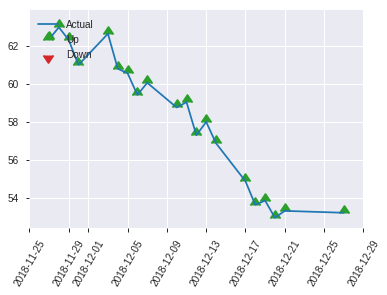


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2486580939668997
RMSE: 0.498656288406052
LogLoss: 0.6905094168251207
Null degrees of freedom: 248
Residual degrees of freedom: -793
Null deviance: 343.0653203047996
Residual deviance: 343.87368957891
AIC: 2427.8736895789098
AUC: 0.49993492972410203
pr_auc: 0.5287589542785202
Gini: -0.00013014055179594308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5260357401770123: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    136  0        (0.0/136.0)
Total  2    247  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526036     0.710183  246
max f2                       0.526036     0.859671  246
max f0point5                 0.540559     0.605     215
max accuracy                 0.540703     0.558233  213
max precision                0.565378     0.569767  85
max recall                   0.526036     1         246
max specificity              0.609906     0.99115   0
max absolute_mcc             0.598317     0.142233  9
max min_per_class_accuracy   0.558286     0.495575  124
max mean_per_class_accuracy  0.544101     0.528306  194

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 56.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.604836           0.610294  0.610294           0.333333         0.606618  0.333333                    0.606618            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.603335           0.915441  0.732353           0.5              0.604125  0.4                         0.605621            0.00735294      0.0147059                  -8.45588  -26.7647
    3        0.0321285                   0.600144           0         0.457721           0                0.602087  0.25                        0.604296            0               0.0147059                  -100      -54.2279
    4        0.0401606                   0.597736           0         0.366176           0                0.598627  0.2                         0.603162            0               0.0147059                  -100      -63.3824
    5        0.0522088                   0.595606           1.83088   0.704186           1                0.596728  0.384615                    0.601677            0.0220588       0.0367647                  83.0882   -29.5814
    6        0.100402                    0.5895             1.22059   0.952059           0.666667         0.592268  0.52                        0.597161            0.0588235       0.0955882                  22.0588   -4.79412
    7        0.15261                     0.582398           0.845023  0.915441           0.461538         0.585838  0.5                         0.593287            0.0441176       0.139706                   -15.4977  -8.45588
    8        0.200803                    0.576683           1.22059   0.988676           0.666667         0.5798    0.54                        0.59005             0.0588235       0.198529                   22.0588   -1.13235
    9        0.301205                    0.5689             1.02529   1.00088            0.56             0.572411  0.546667                    0.58417             0.102941        0.301471                   2.52941   0.0882353
    10       0.401606                    0.56212            0.878824  0.970368           0.48             0.56493   0.53                        0.57936             0.0882353       0.389706                   -12.1176  -2.96324
    11       0.502008                    0.558286           1.09853   0.996              0.6              0.560446  0.544                       0.575578            0.110294        0.5                        9.85294   -0.4
    12       0.598394                    0.553388           1.06801   1.0076             0.583333         0.555966  0.550336                    0.572419            0.102941        0.602941                   6.80147   0.759968
    13       0.698795                    0.549214           1.09853   1.02066            0.6              0.551174  0.557471                    0.569366            0.110294        0.713235                   9.85294   2.06643
    14       0.799197                    0.543668           1.02529   1.02125            0.56             0.545863  0.557789                    0.566414            0.102941        0.816176                   2.52941   2.12459
    15       0.899598                    0.538844           0.878824  1.00535            0.48             0.541369  0.549107                    0.563618            0.0882353       0.904412                   -12.1176  0.535058
    16       1                           0.522463           0.952059  1                  0.52             0.532822  0.546185                    0.56052

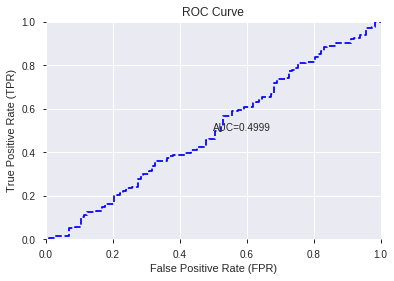

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


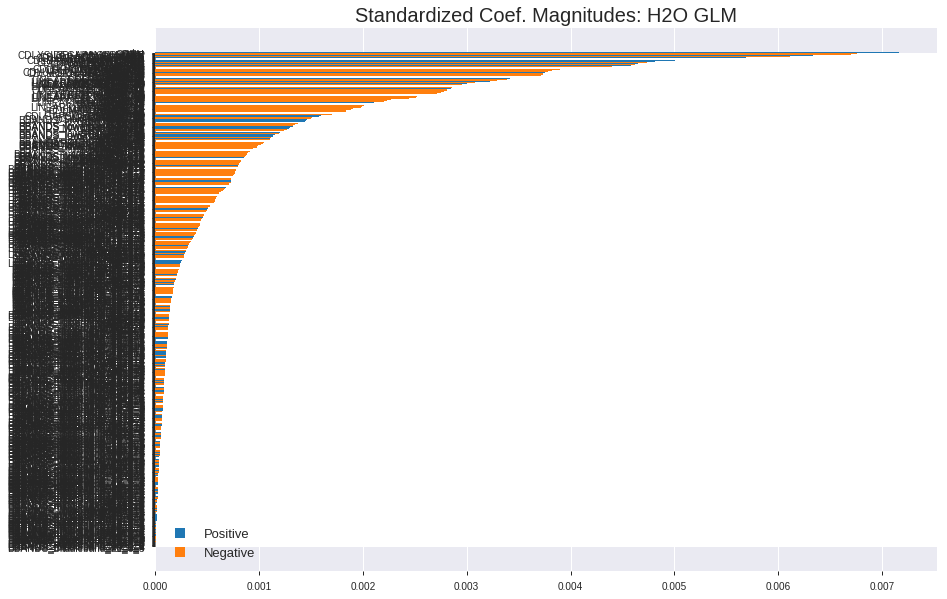

'log_likelihood'
--2019-08-28 14:03:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_140314_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_140314_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

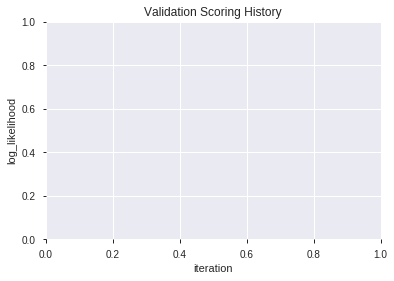

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190828_140400  0.534162  0.694536              0.495575  0.500340  0.250340
1               XGBoost_3_AutoML_20190828_140400  0.529347  0.691929              0.482301  0.499157  0.249158
2  XGBoost_grid_1_AutoML_20190828_140400_model_4  0.522775  0.692648              0.495575  0.499683  0.249683
3  XGBoost_grid_1_AutoML_20190828_140400_model_6  0.522319  0.694652              0.495575  0.500650  0.250650
4  XGBoost_grid_1_AutoML_20190828_140400_model_7  0.517829  0.706223              0.495575  0.505630  0.255662
5  XGBoost_grid_1_AutoML_20190828_140400_model_5  0.500846  0.731528              0.473451  0.515807  0.266057
6  XGBoost_grid_1_AutoML_20190828_140400_model_2  0.493103  0.702987              0.491150  0.504767  0.254790
7  XGBoost_grid_1_AutoML_20190828_140400_model_1  0.486986  0.702239              0.500000  0.504064  0.254080
8  XGBoost_grid_1_AutoML_20190828_140400_model_3  0.473777  0.706801              0.500000  0.506273  0.256313
9               XGBoost_1_AutoML_20190828_140400  0.462259  0.718893              0.495575  0.512129  0.262276

variable  relative_importance  scaled_importance  percentage
0                     ULTOSC           190.155640           1.000000    0.030510
1                        COS           141.387604           0.743536    0.022685
2                        TAN           135.159164           0.710782    0.021686
3                  STDDEV_30           110.386932           0.580508    0.017711
4       HT_PHASOR_quadrature           107.389740           0.564747    0.017230
..                       ...                  ...                ...         ...
268  BBANDS_upperband_14_3_4             3.327139           0.017497    0.000534
269  BBANDS_upperband_14_3_5             3.310650           0.017410    0.000531
270                    VAR_8             3.124544           0.016432    0.000501
271  BBANDS_lowerband_12_1_4             3.052596           0.016053    0.000490
272  BBANDS_lowerband_30_0_5             1.632563           0.008585    0.000262

[273 rows x 4 columns]

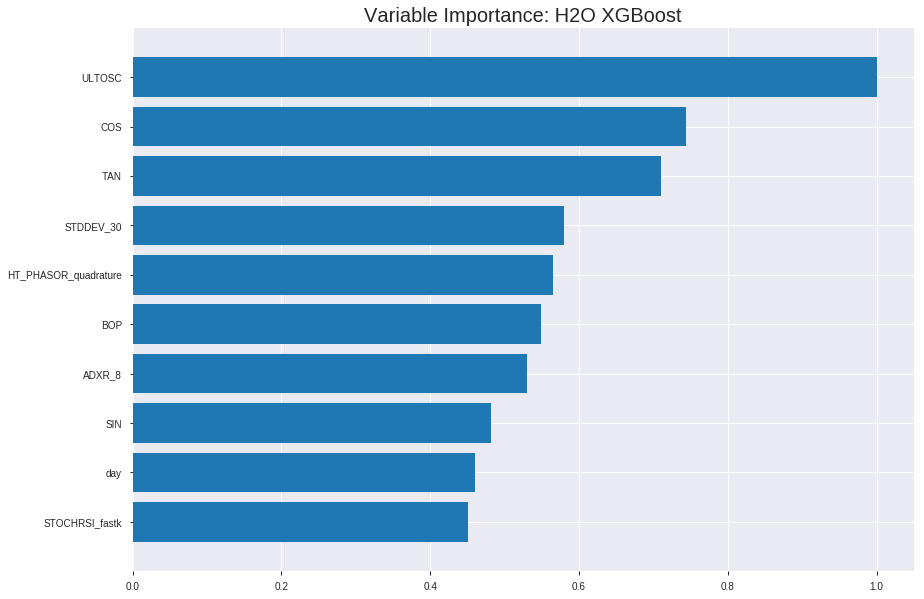

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190828_140400


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16984044436651388
RMSE: 0.41211702751344054
LogLoss: 0.5263907067537884
Mean Per-Class Error: 0.1310006261407084
AUC: 0.9361689514141455
pr_auc: 0.945415342995249
Gini: 0.8723379028282909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5380911529064178: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      692  94   0.1196   (94.0/786.0)
1      136  819  0.1424   (136.0/955.0)
Total  828  913  0.1321   (230.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.538091     0.876874  203
max f2                       0.448241     0.91455   279
max f0point5                 0.554099     0.892898  190
max accuracy                 0.538091     0.867892  203
max precision                0.823444     1         0
max recall                   0.392139     1         327
max specificity              0.823444     1         0
max absolute_mcc             0.538091     0.735391  203
max min_per_class_accuracy   0.532544     0.863874  208
max mean_per_class_accuracy  0.538091     0.868999  203

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.779551           1.82304   1.82304            1                0.795026  1                           0.795026            0.0188482       0.0188482                  82.3037   82.3037
    2        0.0201034                   0.767496           1.82304   1.82304            1                0.773344  1                           0.784495            0.017801        0.0366492                  82.3037   82.3037
    3        0.0304423                   0.758822           1.82304   1.82304            1                0.763324  1                           0.777305            0.0188482       0.0554974                  82.3037   82.3037
    4        0.0402068                   0.74956            1.82304   1.82304            1                0.752886  1                           0.771374            0.017801        0.0732984                  82.3037   82.3037
    5        0.0505457                   0.741039           1.82304   1.82304            1                0.744903  1                           0.76596             0.0188482       0.0921466                  82.3037   82.3037
    6        0.100517                    0.709522           1.82304   1.82304            1                0.724339  1                           0.745268            0.0910995       0.183246                   82.3037   82.3037
    7        0.150488                    0.683118           1.82304   1.82304            1                0.695844  1                           0.728856            0.0910995       0.274346                   82.3037   82.3037
    8        0.20046                     0.66471            1.71826   1.79692            0.942529         0.674329  0.985673                    0.715264            0.0858639       0.360209                   71.8264   79.6919
    9        0.300402                    0.62804            1.71826   1.77075            0.942529         0.645286  0.971319                    0.691982            0.171728        0.531937                   71.8264   77.0751
    10       0.400345                    0.585336           1.56111   1.71841            0.856322         0.60515   0.942611                    0.670305            0.156021        0.687958                   56.1106   71.8415
    11       0.500287                    0.547551           1.39347   1.6535             0.764368         0.566985  0.907003                    0.649665            0.139267        0.827225                   39.3471   65.3501
    12       0.60023                     0.504928           0.859132  1.52123            0.471264         0.525602  0.83445                     0.629008            0.0858639       0.913089                   -14.0868  52.1232
    13       0.700172                    0.458164           0.492429  1.37438            0.270115         0.479037  0.753897                    0.607601            0.0492147       0.962304                   -50.7571  37.4381
    14       0.800115                    0.41709            0.282885  1.23804            0.155172         0.438131  0.67911                     0.586432            0.0282723       0.990576                   -71.7115  23.8042
    15       0.900057                    0.37143            0.094295  1.11104            0.0517241        0.396022  0.609445                    0.565289            0.00942408      1                          -90.5705  11.104
    16       1                           0.234181           0         1                  0                0.331762  0.548535                    0.54195           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25208587183837433
RMSE: 0.5020815390336258
LogLoss: 0.6979295519769886
Mean Per-Class Error: 0.45651608498463836
AUC: 0.5224572069509241
pr_auc: 0.5619699749198701
Gini: 0.04491441390184825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34413576126098633: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344136     0.704811  399
max f2                       0.344136     0.856511  399
max f0point5                 0.506408     0.605278  288
max accuracy                 0.506408     0.564257  288
max precision                0.761228     1         0
max recall                   0.344136     1         399
max specificity              0.761228     1         0
max absolute_mcc             0.506408     0.098619  288
max min_per_class_accuracy   0.559987     0.506608  200
max mean_per_class_accuracy  0.506408     0.543484  288

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 56.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.743161           1.10258   1.10258            0.6              0.754779  0.6                         0.754779            0.0110701       0.0110701                  10.2583    10.2583
    2        0.0200803                   0.722765           1.10258   1.10258            0.6              0.735779  0.6                         0.745279            0.0110701       0.0221402                  10.2583    10.2583
    3        0.0301205                   0.718329           0.735055  0.980074           0.4              0.720265  0.533333                    0.736941            0.00738007      0.0295203                  -26.4945   -1.99262
    4        0.0401606                   0.705653           1.47011   1.10258            0.8              0.712693  0.6                         0.730879            0.0147601       0.0442804                  47.0111    10.2583
    5        0.0502008                   0.69757            1.47011   1.17609            0.8              0.701664  0.64                        0.725036            0.0147601       0.0590406                  47.0111    17.6089
    6        0.100402                    0.671532           0.955572  1.06583            0.52             0.6831    0.58                        0.704068            0.0479705       0.107011                   -4.4428    6.58303
    7        0.150602                    0.652938           1.24959   1.12708            0.68             0.660943  0.613333                    0.689693            0.0627306       0.169742                   24.9594    12.7085
    8        0.200803                    0.63791            0.808561  1.04745            0.44             0.643915  0.57                        0.678248            0.0405904       0.210332                   -19.1439   4.74539
    9        0.301205                    0.608991           0.882066  0.992325           0.48             0.622582  0.54                        0.659693            0.0885609       0.298893                   -11.7934   -0.767528
    10       0.399598                    0.584805           1.05008   1.00655            0.571429         0.595705  0.547739                    0.643937            0.103321        0.402214                   5.00791    0.654564
    11       0.5                         0.559987           1.06583   1.01845            0.58             0.573146  0.554217                    0.629722            0.107011        0.509225                   6.58303    1.84502
    12       0.600402                    0.540865           0.992325  1.01408            0.54             0.550698  0.551839                    0.616507            0.099631        0.608856                   -0.767528  1.40814
    13       0.698795                    0.516418           1.2751    1.05083            0.693878         0.528148  0.571839                    0.604066            0.125461        0.734317                   27.5096    5.08334
    14       0.799197                    0.485922           0.845314  1.02501            0.46             0.502579  0.557789                    0.591316            0.0848708       0.819188                   -15.4686   2.50144
    15       0.899598                    0.454361           0.918819  1.01316            0.5              0.470613  0.551339                    0.577845            0.0922509       0.911439                   -8.11808   1.31622
    16       1                           0.344136           0.882066  1                  0.48             0.417865  0.544177                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:04:05  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.451465                         0.5                0.693147              0.5               0                    1                  0.455823
    2019-08-28 14:04:06  0.944 sec   5                  0.487857         0.669091            0.760504        0.786992           1.72176          0.336588                         0.499283           0.691712              0.504787          0.548511             0.735055           0.455823
    2019-08-28 14:04:07  1.600 sec   10                 0.477195         0.648283            0.814279        0.836185           1.72176          0.282022                         0.498851           0.690838              0.497594          0.553545             1.83764            0.455823
    2019-08-28 14:04:07  2.243 sec   15                 0.467094         0.628808            0.846608        0.866373           1.72176          0.234922                         0.498681           0.690486              0.512492          0.56578              1.83764            0.455823
    2019-08-28 14:04:08  2.970 sec   20                 0.457532         0.610588            0.873371        0.889213           1.82304          0.211373                         0.500213           0.693586              0.497407          0.553848             1.47011            0.455823
    2019-08-28 14:04:09  3.736 sec   25                 0.449453         0.595371            0.892998        0.908167           1.82304          0.192993                         0.500222           0.693682              0.508876          0.555827             1.10258            0.455823
    2019-08-28 14:04:09  4.406 sec   30                 0.441032         0.579612            0.90359         0.919365           1.82304          0.190121                         0.50009            0.693557              0.519783          0.557251             1.10258            0.453815
    2019-08-28 14:04:10  5.124 sec   35                 0.43348          0.565515            0.910443        0.924967           1.82304          0.161401                         0.501743           0.697085              0.514768          0.552801             1.10258            0.455823
    2019-08-28 14:04:11  5.807 sec   40                 0.425559         0.550924            0.920914        0.934014           1.82304          0.166571                         0.501375           0.696413              0.518491          0.555664             1.10258            0.455823
    2019-08-28 14:04:12  6.568 sec   45                 0.418276         0.537627            0.929312        0.941333           1.82304          0.146468                         0.502599           0.699037              0.513825          0.555698             1.10258            0.455823
    2019-08-28 14:04:12  7.257 sec   50                 0.412117         0.526391            0.936169        0.945415           1.82304          0.132108                         0.502082           0.69793               0.522457          0.56197              1.10258            0.455823

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
ULTOSC                   190.1556396484375      1.0                   0.030509647042192736
COS                      141.38760375976562     0.7435362107648507    0.02268502735352502
TAN                      135.15916442871094     0.7107817821159297    0.021685701296377754
STDDEV_30                110.38693237304688     0.5805083276895275    0.017711104182861048
HT_PHASOR_quadrature     107.38973999023438     0.5647465422996556    0.01723021767386126
---                      ---                    ---                   ---
BBANDS_upperband_14_3_4  3.327139377593994      0.017496927168425075  0.0005338250722316018
BBANDS_upperband_14_3_5  3.310649871826172      0.017410211329766234  0.0005311794026011528
VAR_8                    3.124544382095337      0.016431510460967868  0.0005013195845342273
BBANDS_lowerband_12_1_4  3.052596092224121      0.01605314519131699   0.000489775793704155
BBANDS_lowerband_30_0_5  1.6325626373291016     0.008585402149246833  0.0002619375892888038


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5582329317269076)

('F1', 0.7083333333333333)

('auc', 0.5341618948464342)

('logloss', 0.6945355882655092)

('mean_per_class_error', 0.44143675169182717)

('rmse', 0.5003401683207284)

('mse', 0.2503402840352148)

xgboost prediction progress: |████████████████████████████████████████████| 100%


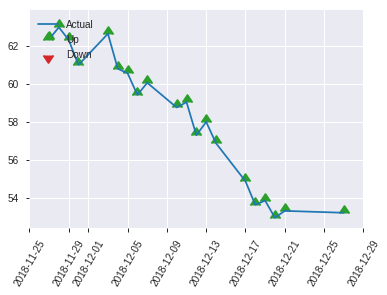


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2503402840352148
RMSE: 0.5003401683207284
LogLoss: 0.6945355882655092
Mean Per-Class Error: 0.44143675169182717
AUC: 0.5341618948464342
pr_auc: 0.5660109378955792
Gini: 0.06832378969286834
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37510713934898376: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    136  0        (0.0/136.0)
Total  1    248  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375107     0.708333  247
max f2                       0.375107     0.858586  247
max f0point5                 0.466211     0.605159  217
max accuracy                 0.468125     0.558233  215
max precision                0.615713     0.666667  56
max recall                   0.375107     1         247
max specificity              0.780337     0.99115   0
max absolute_mcc             0.604629     0.136351  59
max min_per_class_accuracy   0.551359     0.544118  124
max mean_per_class_accuracy  0.604629     0.558563  59

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 55.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.720631           0.610294  0.610294           0.333333         0.747751  0.333333                    0.747751            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.706461           0.915441  0.732353           0.5              0.714907  0.4                         0.734613            0.00735294      0.0147059                  -8.45588  -26.7647
    3        0.0321285                   0.697634           0.610294  0.686581           0.333333         0.703063  0.375                       0.722782            0.00735294      0.0220588                  -38.9706  -31.3419
    4        0.0401606                   0.689514           1.83088   0.915441           1                0.697298  0.5                         0.717685            0.0147059       0.0367647                  83.0882   -8.45588
    5        0.0522088                   0.687311           1.83088   1.1267             1                0.688297  0.615385                    0.710903            0.0220588       0.0588235                  83.0882   12.6697
    6        0.100402                    0.659716           0.762868  0.952059           0.416667         0.673699  0.52                        0.693045            0.0367647       0.0955882                  -23.7132  -4.79412
    7        0.15261                     0.63856            1.26753   1.05998            0.692308         0.648215  0.578947                    0.677709            0.0661765       0.161765                   26.7534   5.99845
    8        0.200803                    0.621746           1.52574   1.17176            0.833333         0.631315  0.64                        0.666574            0.0735294       0.235294                   52.5735   17.1765
    9        0.301205                    0.595902           1.02529   1.12294            0.56             0.60549   0.613333                    0.646213            0.102941        0.338235                   2.52941   12.2941
    10       0.401606                    0.574964           1.02529   1.09853            0.56             0.584774  0.6                         0.630853            0.102941        0.441176                   2.52941   9.85294
    11       0.502008                    0.551359           1.02529   1.08388            0.56             0.56364   0.592                       0.617411            0.102941        0.544118                   2.52941   8.38824
    12       0.598394                    0.53431            0.762868  1.03218            0.416667         0.543826  0.563758                    0.605558            0.0735294       0.617647                   -23.7132  3.21753
    13       0.698795                    0.51729            0.732353  0.989097           0.4              0.526163  0.54023                     0.594151            0.0735294       0.691176                   -26.7647  -1.09026
    14       0.799197                    0.488753           1.17176   1.01205            0.64             0.505377  0.552764                    0.582998            0.117647        0.808824                   17.1765   1.20455
    15       0.899598                    0.45942            0.952059  1.00535            0.52             0.473182  0.549107                    0.570742            0.0955882       0.904412                   -4.79412  0.535058
    16       1                           0.346404           0.952059  1                  0.52             0.420244  0.546185                    0.555632  

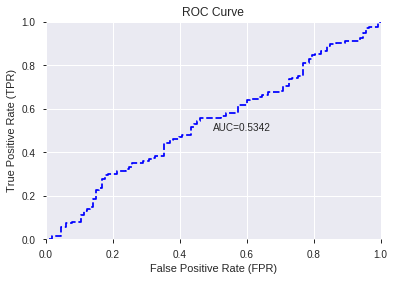

This function is available for GLM models only


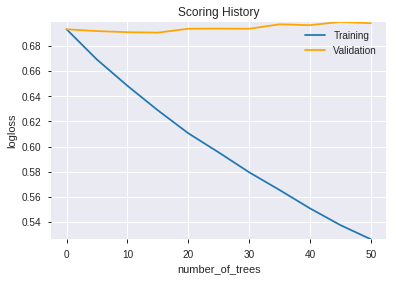

--2019-08-28 14:04:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


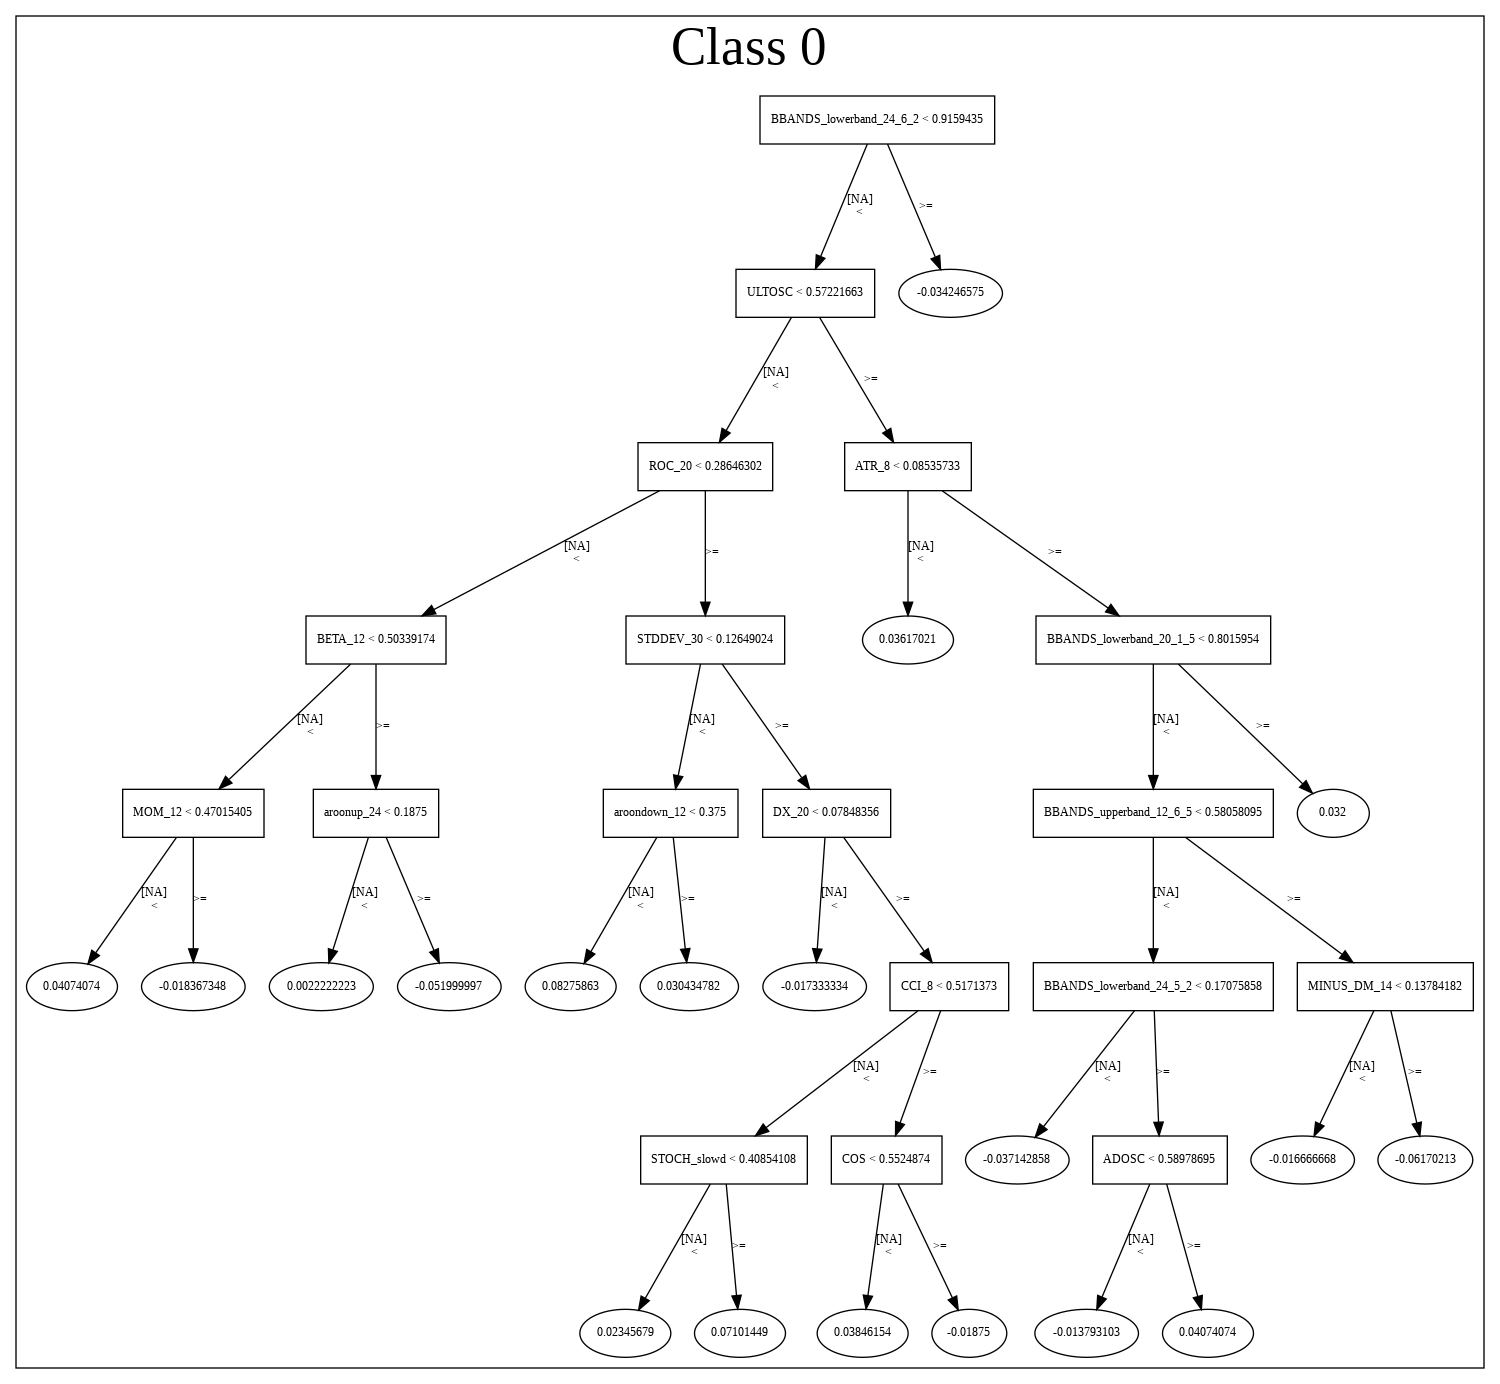

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190828_140400',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190828_140400',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a1f3',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_140508_model_1  0.514966  1.097157              0.490402  0.590274  0.348423
1  DeepLearning_grid_1_AutoML_20190828_140508_model_4  0.501432  1.193599              0.500000  0.604228  0.365091
2  DeepLearning_grid_1_AutoML_20190828_140508_model_2  0.496551  1.103950              0.500000  0.591120  0.349423
3  DeepLearning_grid_1_AutoML_20190828_140508_model_5  0.495705  0.737856              0.500000  0.518338  0.268675
4  DeepLearning_grid_1_AutoML_20190828_140508_model_8  0.492322  0.691939              0.500000  0.499396  0.249396
5               DeepLearning_1_AutoML_20190828_140508  0.492126  0.758373              0.491150  0.526032  0.276710
6  DeepLearning_grid_1_AutoML_20190828_140508_model_9  0.488483  0.689436              0.500000  0.498160  0.248164
7  DeepLearning_grid_1_AutoML_20190828_140508_model_3  0.481845  0.941483              0.500000  0.573340  0.328718
8  DeepLearning_grid_1_AutoML_20190828_140508_model_7  0.476575  0.962558              0.500000  0.572793  0.328092
9  DeepLearning_grid_1_AutoML_20190828_140508_model_6  0.468636  0.735411              0.495575  0.518125  0.268453

variable  relative_importance  scaled_importance  percentage
0            STDDEV_8             1.000000           1.000000    0.021491
1         STOCH_slowd             0.984059           0.984059    0.021148
2      STOCHRSI_fastd             0.974022           0.974022    0.020932
3      STOCHRSI_fastk             0.970966           0.970966    0.020867
4   HT_PHASOR_inphase             0.965354           0.965354    0.020746
5                 day             0.963584           0.963584    0.020708
6             BETA_30             0.957594           0.957594    0.020579
7           dayofyear             0.956240           0.956240    0.020550
8        STOCHF_fastd             0.955691           0.955691    0.020538
9                 COS             0.953982           0.953982    0.020502
10      days_in_month             0.952321           0.952321    0.020466
11        STOCH_slowk             0.952239           0.952239    0.020464
12                BOP             0.951682           0.951682    0.020452
13              DX_30             0.949021           0.949021    0.020395
14            CDLDOJI             0.946201           0.946201    0.020334
15         weekofyear             0.945990           0.945990    0.020330
16            weekday             0.945490           0.945490    0.020319
17       aroondown_12             0.945249           0.945249    0.020314
18             BETA_8             0.944836           0.944836    0.020305
19          CORREL_12             0.942294           0.942294    0.020250
20             ADXR_8             0.941212           0.941212    0.020227
21       weekday_name             0.937451           0.937451    0.020146
22           WILLR_12             0.934559           0.934559    0.020084
23          dayofweek             0.933178           0.933178    0.020054
24              month             0.932997           0.932997    0.020051
25              DX_12             0.932755           0.932755    0.020045
26       aroondown_20             0.932660           0.932660    0.020043
27             ROCP_8             0.932103           0.932103    0.020031
28       STOCHF_fastk             0.930497           0.930497    0.019997
29         aroonup_14             0.928137           0.928137    0.019946
30                SIN             0.924134           0.924134    0.019860
31              CCI_8             0.923071           0.923071    0.019837
32            WILLR_8             0.917640           0.917640    0.019721
33         aroonup_30             0.916894           0.916894    0.019705
34         PLUS_DI_30             0.916708           0.916708    0.019701
35              ROC_8             0.913429           0.913429    0.019630
36              DX_24             0.909477           0.909477    0.019545
37           WILLR_14             0.906885           0.906885    0.019489
38        aroondown_8             0.906636           0.906636    0.019484
39              DX_14             0.906162           0.906162    0.019474
40            ADXR_12             0.904726           0.904726    0.019443
41            ADXR_14             0.902241           0.902241    0.019390
42            quarter             0.902050           0.902050    0.019386
43              DX_20             0.899522           0.899522    0.019331
44         aroonup_24             0.886479           0.886479    0.019051
45               week             0.885807           0.885807    0.019036
46       HT_TRENDMODE             0.885689           0.885689    0.019034
47             SAREXT             0.884913           0.884913    0.019017
48  CDLLONGLEGGEDDOJI             0.880109           0.880109    0.018914
49            BETA_12             0.867165           0.867165    0.018636

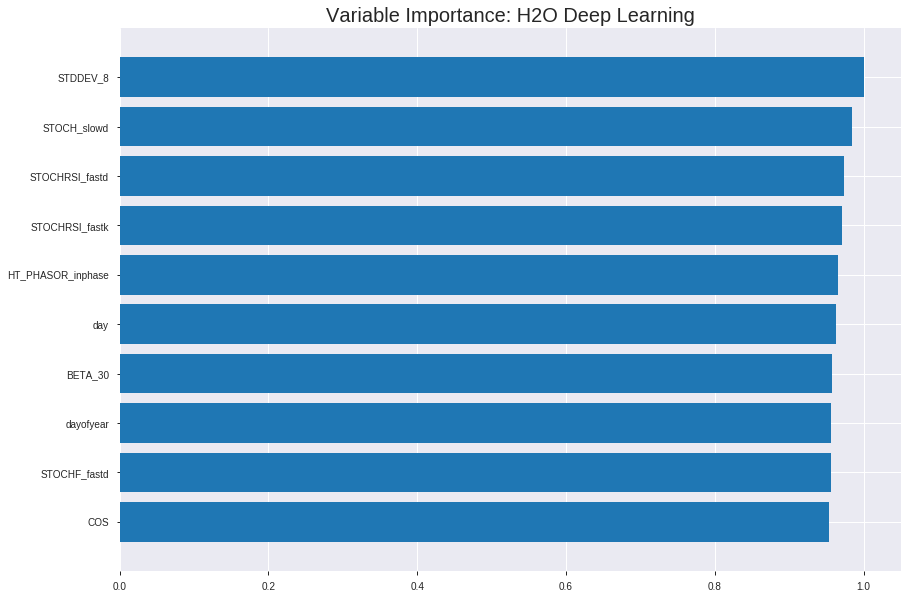

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_140508_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28332875177192457
RMSE: 0.5322863437774114
LogLoss: 0.8701429984737522
Mean Per-Class Error: 0.4008479543849832
AUC: 0.6276880753500393
pr_auc: 0.6588749171683721
Gini: 0.2553761507000787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0055724783445731466: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   771   0.9809   (771.0/786.0)
1      4    951   0.0042   (4.0/955.0)
Total  19   1722  0.4451   (775.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00557248   0.710497  396
max f2                       0.000686585  0.858659  399
max f0point5                 0.322001     0.639721  263
max accuracy                 0.322001     0.606548  263
max precision                0.996763     1         0
max recall                   0.000686585  1         399
max specificity              0.996763     1         0
max absolute_mcc             0.392972     0.199222  236
max min_per_class_accuracy   0.461539     0.591623  209
max mean_per_class_accuracy  0.392972     0.599152  236

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 47.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.987609           1.31664   1.31664            0.722222         0.991836   0.722222                    0.991836            0.0136126       0.0136126                  31.6638   31.6638
    2        0.0201034                   0.979457           1.50132   1.40634            0.823529         0.983443   0.771429                    0.98776             0.0146597       0.0282723                  50.1324   40.6343
    3        0.0304423                   0.967904           1.31664   1.37588            0.722222         0.973328   0.754717                    0.982858            0.0136126       0.0418848                  31.6638   37.5877
    4        0.0402068                   0.961922           1.60856   1.43239            0.882353         0.965146   0.785714                    0.978557            0.0157068       0.0575916                  60.8562   43.2386
    5        0.0505457                   0.954848           1.41792   1.42943            0.777778         0.958625   0.784091                    0.97448             0.0146597       0.0722513                  41.7917   42.9426
    6        0.100517                    0.910255           1.25727   1.34384            0.689655         0.931962   0.737143                    0.953342            0.0628272       0.135079                   25.7267   34.3838
    7        0.150488                    0.868938           1.1944    1.29422            0.655172         0.889967   0.709924                    0.932298            0.0596859       0.194764                   19.4403   29.4217
    8        0.20046                     0.822817           1.06868   1.23799            0.586207         0.846877   0.679083                    0.911004            0.0534031       0.248168                   6.86767   23.7993
    9        0.300402                    0.711943           1.30965   1.26183            0.718391         0.764415   0.692161                    0.862234            0.13089         0.379058                   30.9653   26.1834
    10       0.400345                    0.594678           0.995336  1.19531            0.545977         0.655937   0.655667                    0.810734            0.0994764       0.478534                   -0.46639  19.5305
    11       0.500287                    0.468846           1.04772   1.16582            0.574713         0.531896   0.639495                    0.75503             0.104712        0.583246                   4.77222   16.5823
    12       0.60023                     0.348156           1.00581   1.13918            0.551724         0.411175   0.62488                     0.697776            0.100524        0.68377                    0.581332  13.918
    13       0.700172                    0.232759           0.890564  1.10369            0.488506         0.290548   0.605414                    0.639648            0.0890052       0.772775                   -10.9436  10.3692
    14       0.800115                    0.135115           0.796269  1.06529            0.436782         0.181036   0.58435                     0.582363            0.0795812       0.852356                   -20.3731  6.52921
    15       0.900057                    0.0525033          0.827701  1.03891            0.454023         0.0891428  0.569879                    0.527596            0.0827225       0.935079                   -17.2299  3.89098
    16       1                           0.000275398        0.649588  1                  0.356322         0.0230827  0.548535                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.34335074328280085
RMSE: 0.5859613837812189
LogLoss: 1.077611542780327
Mean Per-Class Error: 0.4793959393338427
AUC: 0.4903847716891266
pr_auc: 0.5182430417177393
Gini: -0.019230456621746828
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.005312239462710502: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00531224   0.704811  399
max f2                       0.00531224   0.856511  399
max f0point5                 0.00531224   0.598763  399
max accuracy                 0.0665776    0.546185  370
max precision                0.6578       0.568075  166
max recall                   0.00531224   1         399
max specificity              0.999373     0.991189  0
max absolute_mcc             0.955124     0.128986  23
max min_per_class_accuracy   0.575863     0.493392  197
max mean_per_class_accuracy  0.6578       0.520604  166

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 53.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.995907           0.735055  0.735055           0.4              0.998638   0.4                         0.998638            0.00738007      0.00738007                 -26.4945   -26.4945
    2        0.0200803                   0.989191           0.735055  0.735055           0.4              0.993743   0.4                         0.996191            0.00738007      0.0147601                  -26.4945   -26.4945
    3        0.0301205                   0.979196           0.735055  0.735055           0.4              0.985838   0.4                         0.99274             0.00738007      0.0221402                  -26.4945   -26.4945
    4        0.0401606                   0.971379           0.367528  0.643173           0.2              0.975369   0.35                        0.988397            0.00369004      0.0258303                  -63.2472   -35.6827
    5        0.0502008                   0.961743           0.367528  0.588044           0.2              0.969296   0.32                        0.984577            0.00369004      0.0295203                  -63.2472   -41.1956
    6        0.100402                    0.92292            1.10258   0.845314           0.6              0.94612    0.46                        0.965349            0.0553506       0.0848708                  10.2583    -15.4686
    7        0.150602                    0.8965             0.882066  0.857565           0.48             0.908685   0.466667                    0.946461            0.0442804       0.129151                   -11.7934   -14.2435
    8        0.200803                    0.848276           0.955572  0.882066           0.52             0.87309    0.48                        0.928118            0.0479705       0.177122                   -4.4428    -11.7934
    9        0.301205                    0.777536           1.10258   0.955572           0.6              0.81317    0.52                        0.889802            0.110701        0.287823                   10.2583    -4.4428
    10       0.399598                    0.681154           1.2751    1.03425            0.693878         0.72827    0.562814                    0.850028            0.125461        0.413284                   27.5096    3.42487
    11       0.5                         0.574228           0.808561  0.98893            0.44             0.627173   0.538153                    0.805278            0.0811808       0.494465                   -19.1439   -1.10701
    12       0.600402                    0.449023           1.02908   0.995644           0.56             0.518447   0.541806                    0.757313            0.103321        0.597786                   2.90775    -0.435646
    13       0.698795                    0.330647           1.12508   1.01387            0.612245         0.383015   0.551724                    0.70461             0.110701        0.708487                   12.5085    1.38694
    14       0.799197                    0.207581           0.845314  0.992694           0.46             0.270071   0.540201                    0.65002             0.0848708       0.793358                   -15.4686   -0.73059
    15       0.899598                    0.0915911          1.06583   1.00086            0.58             0.150091   0.544643                    0.594224            0.107011        0.900369                   6.58303    0.0856616
    16       1                           0.00531224         0.992325  1                  0.54             0.05110


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:05:09  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:05:14  4.624 sec   3070 obs/sec      7.98679   1             13905      0.532286         0.870143            -0.144095      0.627688        0.658875           1.31664          0.445146                         0.585961           1.07761               -0.384209        0.490385          0.518243             0.735055           0.455823
    2019-08-28 14:05:22  13.213 sec  3198 obs/sec      23.9586   3             41712      0.480677         0.738905            0.067006       0.726923        0.726736           1.72176          0.334865                         0.584479           1.18283               -0.377214        0.513752          0.545272             0.735055           0.451807
    2019-08-28 14:05:30  21.374 sec  3290 obs/sec      39.9362   5             69529      0.415297         0.532273            0.303552       0.825858        0.837631           1.82304          0.246984                         0.583652           1.14967               -0.37332         0.497204          0.521872             0.735055           0.453815
    2019-08-28 14:05:38  29.171 sec  3374 obs/sec      55.9161   7             97350      0.425182         0.59054             0.270001       0.831101        0.823244           1.82304          0.241815                         0.6033             1.33728               -0.467338        0.512558          0.538421             0.735055           0.455823
    2019-08-28 14:05:46  36.755 sec  3442 obs/sec      71.8937   9             125167     0.378828         0.46963             0.420498       0.879164        0.855996           1.82304          0.186674                         0.60601            1.33868               -0.480552        0.492002          0.524879             0.735055           0.437751
    2019-08-28 14:05:53  44.287 sec  3491 obs/sec      87.8771   11            152994     0.36275          0.439766            0.468644       0.894579        0.87318            1.82304          0.184951                         0.597795           1.44513               -0.440684        0.52175           0.536237             0.735055           0.439759
    2019-08-28 14:05:53  44.363 sec  3491 obs/sec      87.8771   11            152994     0.532286         0.870143            -0.144095      0.627688        0.658875           1.31664          0.445146                         0.585961           1.07761               -0.384209        0.490385          0.518243             0.735055           0.455823

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
STDDEV_8           1.0                    1.0                  0.021490540735623637
STOCH_slowd        0.9840593338012695     0.9840593338012695   0.021147967199326843
STOCHRSI_fastd     0.9740219116210938     0.9740219116210938   0.020932257569083124
STOCHRSI_fastk     0.9709659218788147     0.9709659218788147   0.020866582697039025
HT_PHASOR_inphase  0.9653540849685669     0.9653540849685669   0.02074598128731767
---                ---                    ---                  ---
week               0.8858073949813843     0.8858073949813843   0.019036479905764098
HT_TRENDMODE       0.8856892585754395     0.8856892585754395   0.019033941090519778
SAREXT             0.884913444519043      0.884913444519043    0.01901726842693752
CDLLONGLEGGEDDOJI  0.8801088333129883     0.8801088333129883   0.01891401473409497
BETA_12            0.8671652674674988     0.8671652674674988   0.01863585050502825


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542168674698795)

('F1', 0.7086614173228346)

('auc', 0.514966163456533)

('logloss', 1.0971570113890026)

('mean_per_class_error', 0.46443909422175955)

('rmse', 0.5902740101359285)

('mse', 0.34842340704195024)

deeplearning prediction progress: |███████████████████████████████████████| 100%


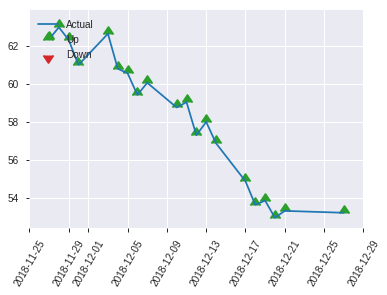


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.34842340704195024
RMSE: 0.5902740101359285
LogLoss: 1.0971570113890026
Mean Per-Class Error: 0.46443909422175955
AUC: 0.514966163456533
pr_auc: 0.5600092702161716
Gini: 0.02993232691306602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.011231866764067571: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    110  0.9735   (110.0/113.0)
1      1    135  0.0074   (1.0/136.0)
Total  4    245  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0112319    0.708661  244
max f2                       0.00824063   0.858586  247
max f0point5                 0.0112319    0.604839  244
max accuracy                 0.0112319    0.554217  244
max precision                0.998018     1         0
max recall                   0.00824063   1         247
max specificity              0.998018     1         0
max absolute_mcc             0.0737265    0.120183  220
max min_per_class_accuracy   0.409238     0.522059  124
max mean_per_class_accuracy  0.602524     0.535561  88

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 46.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.988095           1.22059   1.22059            0.666667         0.993391   0.666667                    0.993391            0.0147059       0.0147059                  22.0588   22.0588
    2        0.0200803                   0.984463           1.83088   1.46471            1                0.985255   0.8                         0.990137            0.0147059       0.0294118                  83.0882   46.4706
    3        0.0321285                   0.979051           0.610294  1.1443             0.333333         0.982615   0.625                       0.987316            0.00735294      0.0367647                  -38.9706  14.4301
    4        0.0401606                   0.970707           0         0.915441           0                0.974754   0.5                         0.984804            0               0.0367647                  -100      -8.45588
    5        0.0522088                   0.96895            0.610294  0.845023           0.333333         0.969791   0.461538                    0.981339            0.00735294      0.0441176                  -38.9706  -15.4977
    6        0.100402                    0.932645           1.22059   1.02529            0.666667         0.951526   0.56                        0.967029            0.0588235       0.102941                   22.0588   2.52941
    7        0.15261                     0.895697           0.98586   1.0118             0.538462         0.917665   0.552632                    0.950141            0.0514706       0.154412                   -1.41403  1.18034
    8        0.200803                    0.84275            1.22059   1.06191            0.666667         0.873406   0.58                        0.931725            0.0588235       0.213235                   22.0588   6.19118
    9        0.301205                    0.720721           1.02529   1.04971            0.56             0.797217   0.573333                    0.886889            0.102941        0.316176                   2.52941   4.97059
    10       0.401606                    0.536489           1.09853   1.06191            0.6              0.609677   0.58                        0.817586            0.110294        0.426471                   9.85294   6.19118
    11       0.502008                    0.409238           0.952059  1.03994            0.52             0.461653   0.568                       0.746399            0.0955882       0.522059                   -4.79412  3.99412
    12       0.598394                    0.278878           0.762868  0.995312           0.416667         0.349399   0.543624                    0.682453            0.0735294       0.595588                   -23.7132  -0.468812
    13       0.698795                    0.211781           1.245     1.03119            0.68             0.246192   0.563218                    0.619772            0.125           0.720588                   24.5      3.11866
    14       0.799197                    0.141878           0.659118  0.984444           0.36             0.17523    0.537688                    0.563925            0.0661765       0.786765                   -34.0882  -1.55557
    15       0.899598                    0.0572474          0.878824  0.972656           0.48             0.0998264  0.53125                     0.512128            0.0882353       0.875                      -12.1176  -2.73438
    16       1                           0.00498415         1.245     1                  0.68             0.0272438  0.546185             

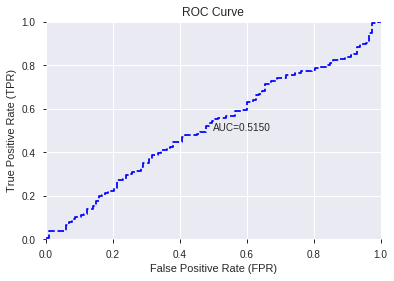

This function is available for GLM models only


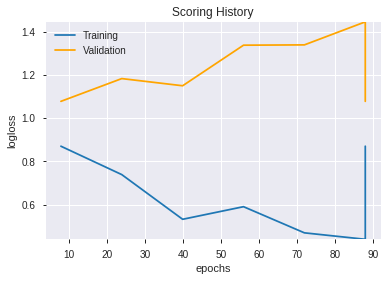

--2019-08-28 14:12:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


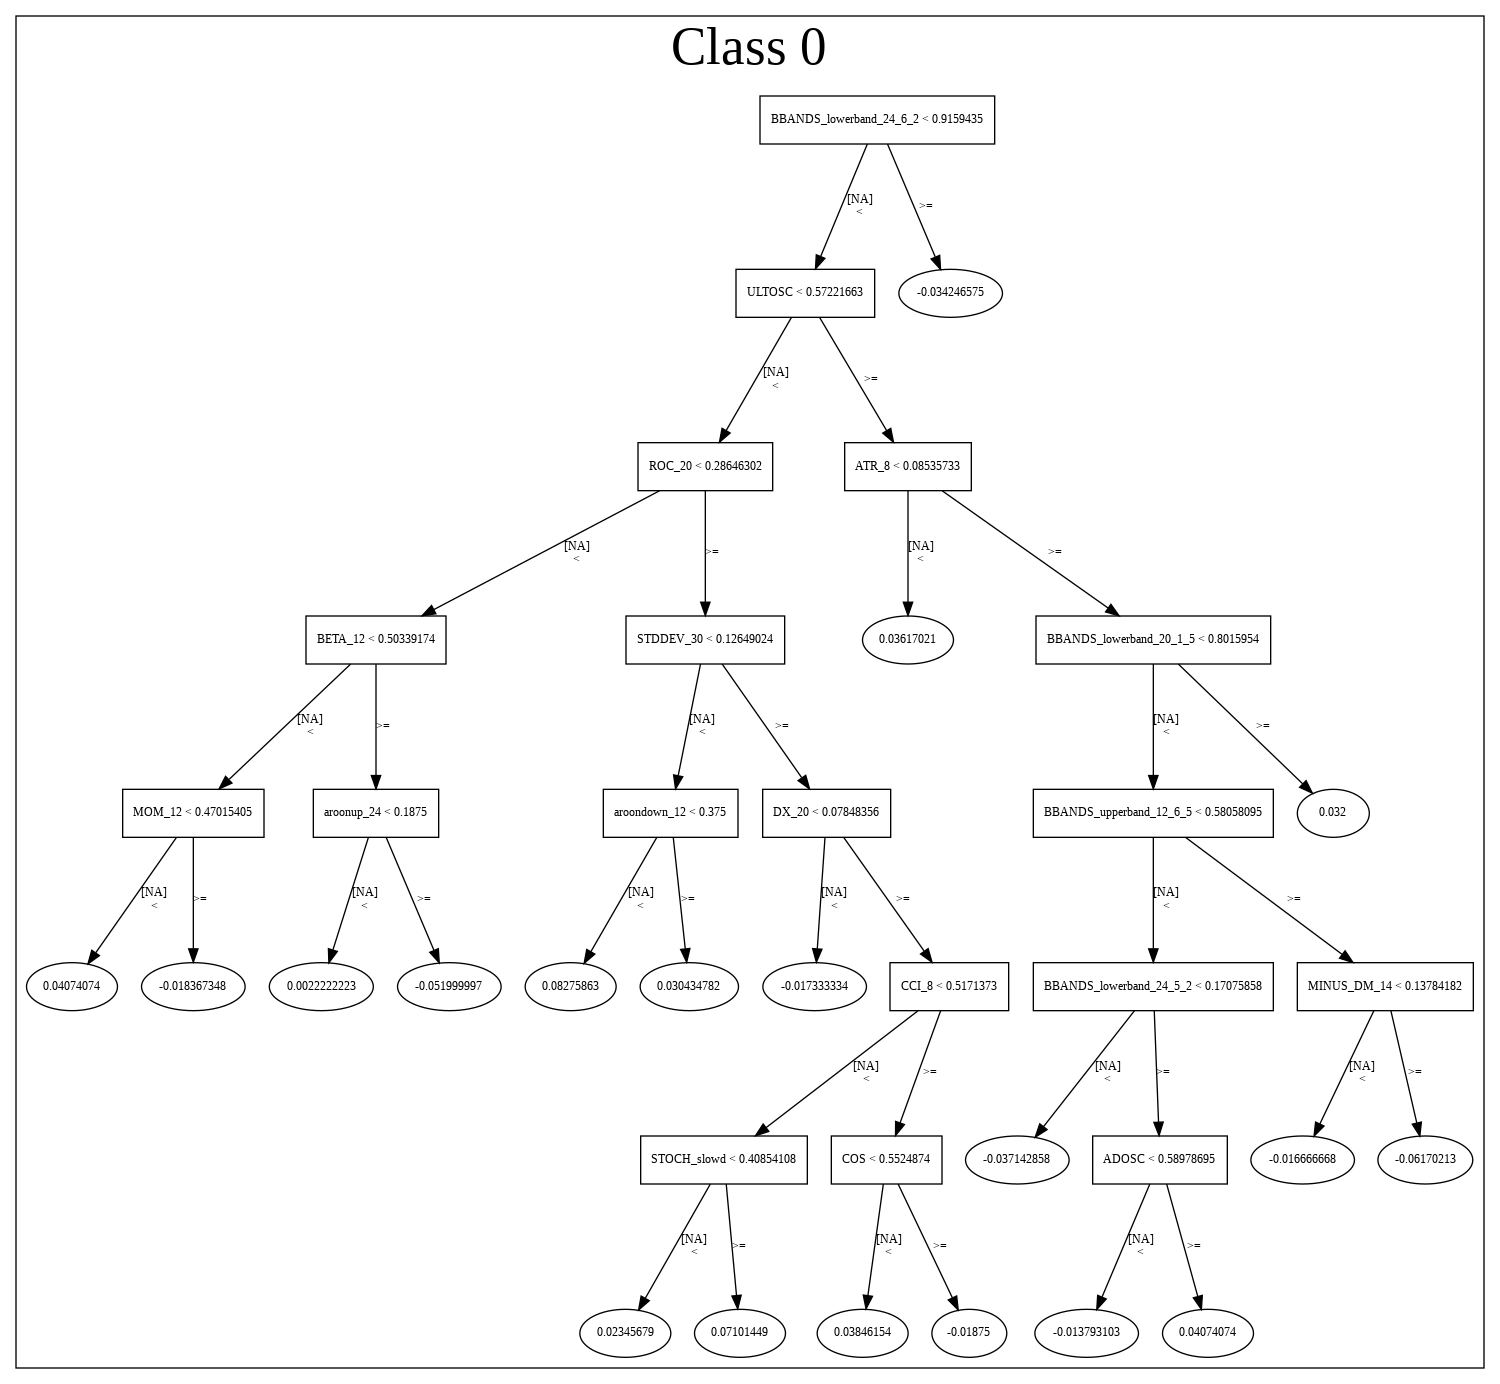

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_140508_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_140508_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STDDEV_8',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'HT_PHASOR_inphase',
 'day',
 'BETA_30',
 'dayofyear',
 'STOCHF_fastd',
 'COS',
 'days_in_month',
 'STOCH_slowk',
 'BOP',
 'DX_30',
 'CDLDOJI',
 'weekofyear',
 'weekday',
 'aroondown_12',
 'BETA_8',
 'CORREL_12',
 'ADXR_8',
 'weekday_name',
 'WILLR_12',
 'dayofweek',
 'month',
 'DX_12',
 'aroondown_20',
 'ROCP_8',
 'STOCHF_fastk',
 'aroonup_14',
 'SIN',
 'CCI_8',
 'WILLR_8',
 'aroonup_30',
 'PLUS_DI_30',
 'ROC_8',
 'DX_24',
 'WILLR_14',
 'aroondown_8',
 'DX_14',
 'ADXR_12',
 'ADXR_14',
 'quarter',
 'DX_20',
 'aroonup_24',
 'week',
 'HT_TRENDMODE',
 'SAREXT',
 'CDLLONGLEGGEDDOJI',
 'BETA_12']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error   rmse       mse
0  GLM_grid_1_AutoML_20190828_141259_model_1  0.505726  0.689149                   0.5  0.498  0.248004

variable  relative_importance  scaled_importance  percentage
0                 day             0.009100           1.000000    0.059764
1                 COS             0.007911           0.869352    0.051956
2             BETA_30             0.007848           0.862435    0.051543
3             BETA_12             0.007197           0.790821    0.047263
4               ROC_8             0.006098           0.670075    0.040046
5              ROCP_8             0.006088           0.668964    0.039980
6              BETA_8             0.006068           0.666782    0.039850
7                 SIN             0.005911           0.649568    0.038821
8        weekday_name             0.005735           0.630240    0.037666
9              SAREXT             0.005656           0.621556    0.037147
10            WILLR_8             0.005129           0.563601    0.033683
11           WILLR_12             0.004997           0.549060    0.032814
12             ADXR_8             0.004873           0.535431    0.032000
13         PLUS_DI_30             0.004235           0.465414    0.027815
14        aroondown_8             0.004069           0.447129    0.026722
15           WILLR_14             0.004057           0.445775    0.026641
16       HT_TRENDMODE             0.003961           0.435222    0.026011
17  HT_PHASOR_inphase             0.003900           0.428562    0.025613
18           STDDEV_8             0.003561           0.391304    0.023386
19       STOCHF_fastk             0.003118           0.342631    0.020477
20         aroonup_14             0.003029           0.332897    0.019895
21            CDLDOJI             0.002949           0.323998    0.019363
22      days_in_month             0.002925           0.321367    0.019206
23              DX_30             0.002924           0.321254    0.019199
24       STOCHF_fastd             0.002811           0.308865    0.018459
25        STOCH_slowk             0.002796           0.307274    0.018364
26         aroonup_30             0.002418           0.265661    0.015877
27        STOCH_slowd             0.002266           0.248999    0.014881
28              DX_24             0.002026           0.222606    0.013304
29  CDLLONGLEGGEDDOJI             0.001986           0.218259    0.013044
30       aroondown_12             0.001725           0.189594    0.011331
31              DX_12             0.001557           0.171106    0.010226
32                BOP             0.001540           0.169212    0.010113
33          CORREL_12             0.001427           0.156849    0.009374
34            weekday             0.001232           0.135398    0.008092
35          dayofweek             0.001227           0.134864    0.008060
36       aroondown_20             0.001179           0.129553    0.007743
37              DX_14             0.001047           0.115026    0.006874
38              month             0.000956           0.105014    0.006276
39         aroonup_24             0.000904           0.099377    0.005939
40            quarter             0.000739           0.081158    0.004850
41              DX_20             0.000698           0.076701    0.004584
42     STOCHRSI_fastk             0.000693           0.076181    0.004553
43              CCI_8             0.000531           0.058391    0.003490
44            ADXR_12             0.000331           0.036410    0.002176
45         weekofyear             0.000302           0.033141    0.001981
46               week             0.000288           0.031673    0.001893
47          dayofyear             0.000209           0.023008    0.001375
48     STOCHRSI_fastd             0.000032           0.003500    0.000209
49            ADXR_14             0.000011           0.001226    0.000073

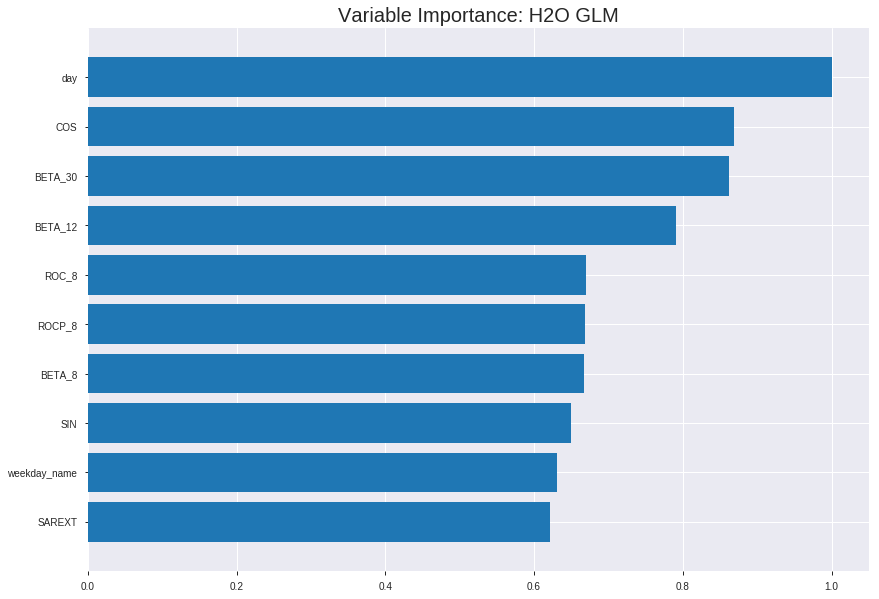

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_141259_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24671956986455704
RMSE: 0.49670873745541966
LogLoss: 0.6865612198534173
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2397.1076822559344
Residual deviance: 2390.606167529599
AIC: 2492.606167529599
AUC: 0.5498974195009525
pr_auc: 0.5921192880021678
Gini: 0.099794839001905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5212156985072253: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    780   0.9924   (780.0/786.0)
1      0    955   0        (0.0/955.0)
Total  6    1735  0.448    (780.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.521216     0.710037   395
max f2                       0.521216     0.859586   395
max f0point5                 0.533641     0.612735   333
max accuracy                 0.533641     0.568064   333
max precision                0.579632     1          0
max recall                   0.521216     1          395
max specificity              0.579632     1          0
max absolute_mcc             0.533641     0.0991199  333
max min_per_class_accuracy   0.548348     0.529262   200
max mean_per_class_accuracy  0.545674     0.535324   226

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.572342           1.11408   1.11408            0.611111         0.574962  0.611111                    0.574962            0.0115183       0.0115183                  11.4078   11.4078
    2        0.0201034                   0.570553           1.50132   1.30217            0.823529         0.571281  0.714286                    0.573174            0.0146597       0.026178                   50.1324   30.2169
    3        0.0304423                   0.568821           1.31664   1.30708            0.722222         0.569516  0.716981                    0.571931            0.0136126       0.0397906                  31.6638   30.7083
    4        0.0402068                   0.567678           1.07237   1.25008            0.588235         0.56827   0.685714                    0.571042            0.0104712       0.0502618                  7.23745   25.0082
    5        0.0505457                   0.566619           1.0128    1.20155            0.555556         0.567149  0.659091                    0.570246            0.0104712       0.060733                   1.27981   20.1547
    6        0.100517                    0.563407           1.13154   1.16674            0.62069          0.564831  0.64                        0.567554            0.0565445       0.117277                   13.154    16.6743
    7        0.150488                    0.560815           1.11059   1.1481             0.609195         0.562102  0.629771                    0.565744            0.0554974       0.172775                   11.0586   14.8096
    8        0.20046                     0.558916           1.15249   1.14919            0.632184         0.559771  0.630372                    0.564255            0.0575916       0.230366                   15.2494   14.9192
    9        0.300402                    0.555127           0.953427  1.08406            0.522989         0.55699   0.594646                    0.561838            0.095288        0.325654                   -4.65728  8.40619
    10       0.400345                    0.55184            0.995336  1.06191            0.545977         0.553507  0.582496                    0.559758            0.0994764       0.425131                   -0.46639  6.19123
    11       0.500287                    0.548436           1.02677   1.05489            0.563218         0.550159  0.578645                    0.55784             0.102618        0.527749                   2.67678   5.48915
    12       0.60023                     0.545394           1.00581   1.04672            0.551724         0.546872  0.574163                    0.556014            0.100524        0.628272                   0.581332  4.67196
    13       0.700172                    0.541965           0.963904  1.0349             0.528736         0.543661  0.567678                    0.554251            0.0963351       0.724607                   -3.60956  3.48986
    14       0.800115                    0.538151           1.03724   1.03519            0.568966         0.540242  0.567839                    0.552501            0.103665        0.828272                   3.7245    3.51917
    15       0.900057                    0.534004           0.953427  1.02611            0.522989         0.536196  0.562859                    0.55069             0.095288        0.92356                    -4.65728  2.61125
    16       1                           0.516168           0.764837  1                  0.41954          0.529126  0.548535                    0.548535         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24789651531420154
RMSE: 0.49789207195355256
LogLoss: 0.6889329523517473
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 686.5201497057026
Residual deviance: 686.1772205423404
AIC: 788.1772205423404
AUC: 0.5204983988165873
pr_auc: 0.5554094557626075
Gini: 0.04099679763317465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5231187621536313: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.523119     0.704811   399
max f2                       0.523119     0.856511   399
max f0point5                 0.523119     0.598763   399
max accuracy                 0.540713     0.552209   301
max precision                0.575006     0.636364   10
max recall                   0.523119     1          399
max specificity              0.584888     0.995595   0
max absolute_mcc             0.530479     0.0692275  382
max min_per_class_accuracy   0.549743     0.512915   201
max mean_per_class_accuracy  0.543672     0.530813   271

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 55.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.578254           0.735055  0.735055           0.4              0.581915  0.4                         0.581915            0.00738007      0.00738007                 -26.4945   -26.4945
    2        0.0200803                   0.575017           1.47011   1.10258            0.8              0.576536  0.6                         0.579225            0.0147601       0.0221402                  47.0111    10.2583
    3        0.0301205                   0.571925           0.735055  0.980074           0.4              0.573462  0.533333                    0.577304            0.00738007      0.0295203                  -26.4945   -1.99262
    4        0.0401606                   0.570434           1.10258   1.0107             0.6              0.571174  0.55                        0.575772            0.0110701       0.0405904                  10.2583    1.07011
    5        0.0502008                   0.569794           1.10258   1.02908            0.6              0.57009   0.56                        0.574635            0.0110701       0.0516605                  10.2583    2.90775
    6        0.100402                    0.565612           1.02908   1.02908            0.56             0.567547  0.56                        0.571091            0.0516605       0.103321                   2.90775    2.90775
    7        0.150602                    0.563446           1.10258   1.05358            0.6              0.564338  0.573333                    0.56884             0.0553506       0.158672                   10.2583    5.35793
    8        0.200803                    0.560895           0.955572  1.02908            0.52             0.562     0.56                        0.56713             0.0479705       0.206642                   -4.4428    2.90775
    9        0.301205                    0.557896           1.10258   1.05358            0.6              0.559327  0.573333                    0.564529            0.110701        0.317343                   10.2583    5.35793
    10       0.399598                    0.553625           1.05008   1.05272            0.571429         0.555813  0.572864                    0.562383            0.103321        0.420664                   5.00791    5.27175
    11       0.5                         0.549458           0.918819  1.02583            0.5              0.551651  0.558233                    0.560228            0.0922509       0.512915                   -8.11808   2.58303
    12       0.600402                    0.545785           0.955572  1.01408            0.52             0.54795   0.551839                    0.558175            0.095941        0.608856                   -4.4428    1.40814
    13       0.698795                    0.542816           1.12508   1.02971            0.612245         0.544356  0.560345                    0.556229            0.110701        0.719557                   12.5085    2.97112
    14       0.799197                    0.539796           0.845314  1.00655            0.46             0.541241  0.547739                    0.554346            0.0848708       0.804428                   -15.4686   0.654564
    15       0.899598                    0.535483           0.955572  1.00086            0.52             0.537848  0.544643                    0.552505            0.095941        0.900369                   -4.4428    0.0856616
    16       1                           0.523119           0.992325  1                  0.54             0.531313  0.544177               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 14:12:59  0.000 sec   2            2.2       51            1.37312           1.37787
    2019-08-28 14:12:59  0.020 sec   4            1.4       51            1.37169           1.37817
    2019-08-28 14:12:59  0.045 sec   6            0.84      51            1.3699            1.37886
    2019-08-28 14:12:59  0.075 sec   8            0.52      51            1.36778           1.38008
    2019-08-28 14:12:59  0.100 sec   10           0.32      51            1.36546           1.38199
    2019-08-28 14:12:59  0.120 sec   12           0.2       51            1.36312           1.38464

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.7064935064935065)

('auc', 0.5057261842790214)

('logloss', 0.6891488755595808)

('mean_per_class_error', 0.44423477355543994)

('rmse', 0.4980003062576519)

('mse', 0.24800430503271512)

glm prediction progress: |████████████████████████████████████████████████| 100%


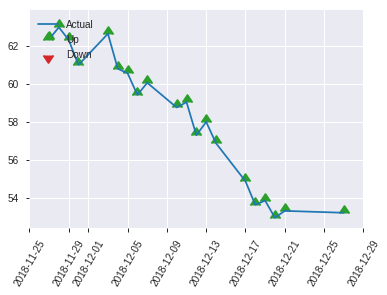


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24800430503271512
RMSE: 0.4980003062576519
LogLoss: 0.6891488755595808
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 343.0653203047996
Residual deviance: 343.19614002867127
AIC: 445.19614002867127
AUC: 0.5057261842790214
pr_auc: 0.5692795188731846
Gini: 0.01145236855804277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.525426650425466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    136  0        (0.0/136.0)
Total  0    249  0.4538   (113.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.525427     0.706494  248
max f2                       0.525427     0.857503  248
max f0point5                 0.525427     0.600707  248
max accuracy                 0.545665     0.550201  185
max precision                0.563729     0.742857  34
max recall                   0.525427     1         248
max specificity              0.582686     0.99115   0
max absolute_mcc             0.563729     0.159757  34
max min_per_class_accuracy   0.552334     0.485294  121
max mean_per_class_accuracy  0.563729     0.555765  34

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 55.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.575542           0.610294  0.610294           0.333333         0.579164  0.333333                    0.579164            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.572702           1.83088   1.09853            1                0.573894  0.6                         0.577056            0.0147059       0.0220588                  83.0882   9.85294
    3        0.0321285                   0.571557           1.22059   1.1443             0.666667         0.572267  0.625                       0.57526             0.0147059       0.0367647                  22.0588   14.4301
    4        0.0401606                   0.570153           1.83088   1.28162            1                0.57061   0.7                         0.57433             0.0147059       0.0514706                  83.0882   28.1618
    5        0.0522088                   0.568876           1.22059   1.26753            0.666667         0.56949   0.692308                    0.573213            0.0147059       0.0661765                  22.0588   26.7534
    6        0.100402                    0.564695           1.37316   1.31824            0.75             0.566285  0.72                        0.569888            0.0661765       0.132353                   37.3162   31.8235
    7        0.15261                     0.562822           1.1267    1.25271            0.615385         0.563987  0.684211                    0.567869            0.0588235       0.191176                   12.6697   25.2709
    8        0.200803                    0.561049           0.610294  1.09853            0.333333         0.56203   0.6                         0.566468            0.0294118       0.220588                   -38.9706  9.85294
    9        0.301205                    0.558359           0.732353  0.976471           0.4              0.559713  0.533333                    0.564216            0.0735294       0.294118                   -26.7647  -2.35294
    10       0.401606                    0.555468           0.878824  0.952059           0.48             0.556798  0.52                        0.562362            0.0882353       0.382353                   -12.1176  -4.79412
    11       0.502008                    0.552143           1.02529   0.966706           0.56             0.553658  0.528                       0.560621            0.102941        0.485294                   2.52941   -3.32941
    12       0.598394                    0.549343           1.29688   1.01989            0.708333         0.550663  0.557047                    0.559017            0.125           0.610294                   29.6875   1.98875
    13       0.698795                    0.546762           0.878824  0.99962            0.48             0.548144  0.545977                    0.557455            0.0882353       0.698529                   -12.1176  -0.0380325
    14       0.799197                    0.544256           1.02529   1.00285            0.56             0.545612  0.547739                    0.555967            0.102941        0.801471                   2.52941   0.284511
    15       0.899598                    0.539286           0.878824  0.989003           0.48             0.541882  0.540179                    0.554395            0.0882353       0.889706                   -12.1176  -1.09966
    16       1                           0.525427           1.09853   1                  0.6              0.533641  0.546185                    0.552311

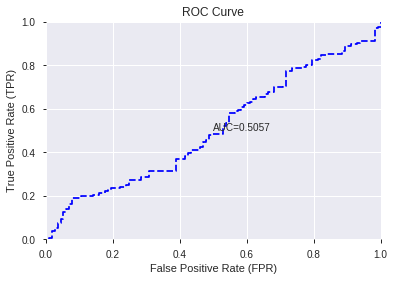

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


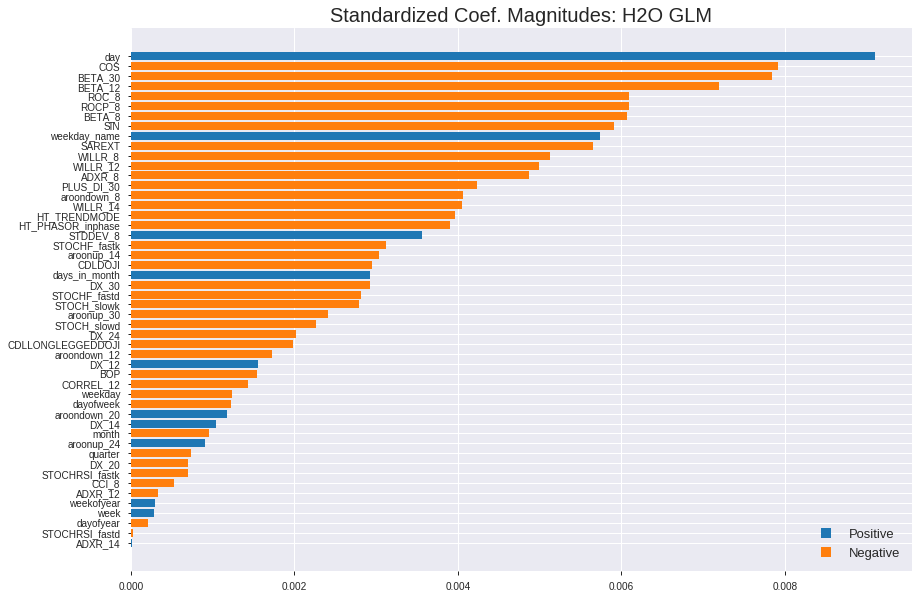

'log_likelihood'
--2019-08-28 14:13:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


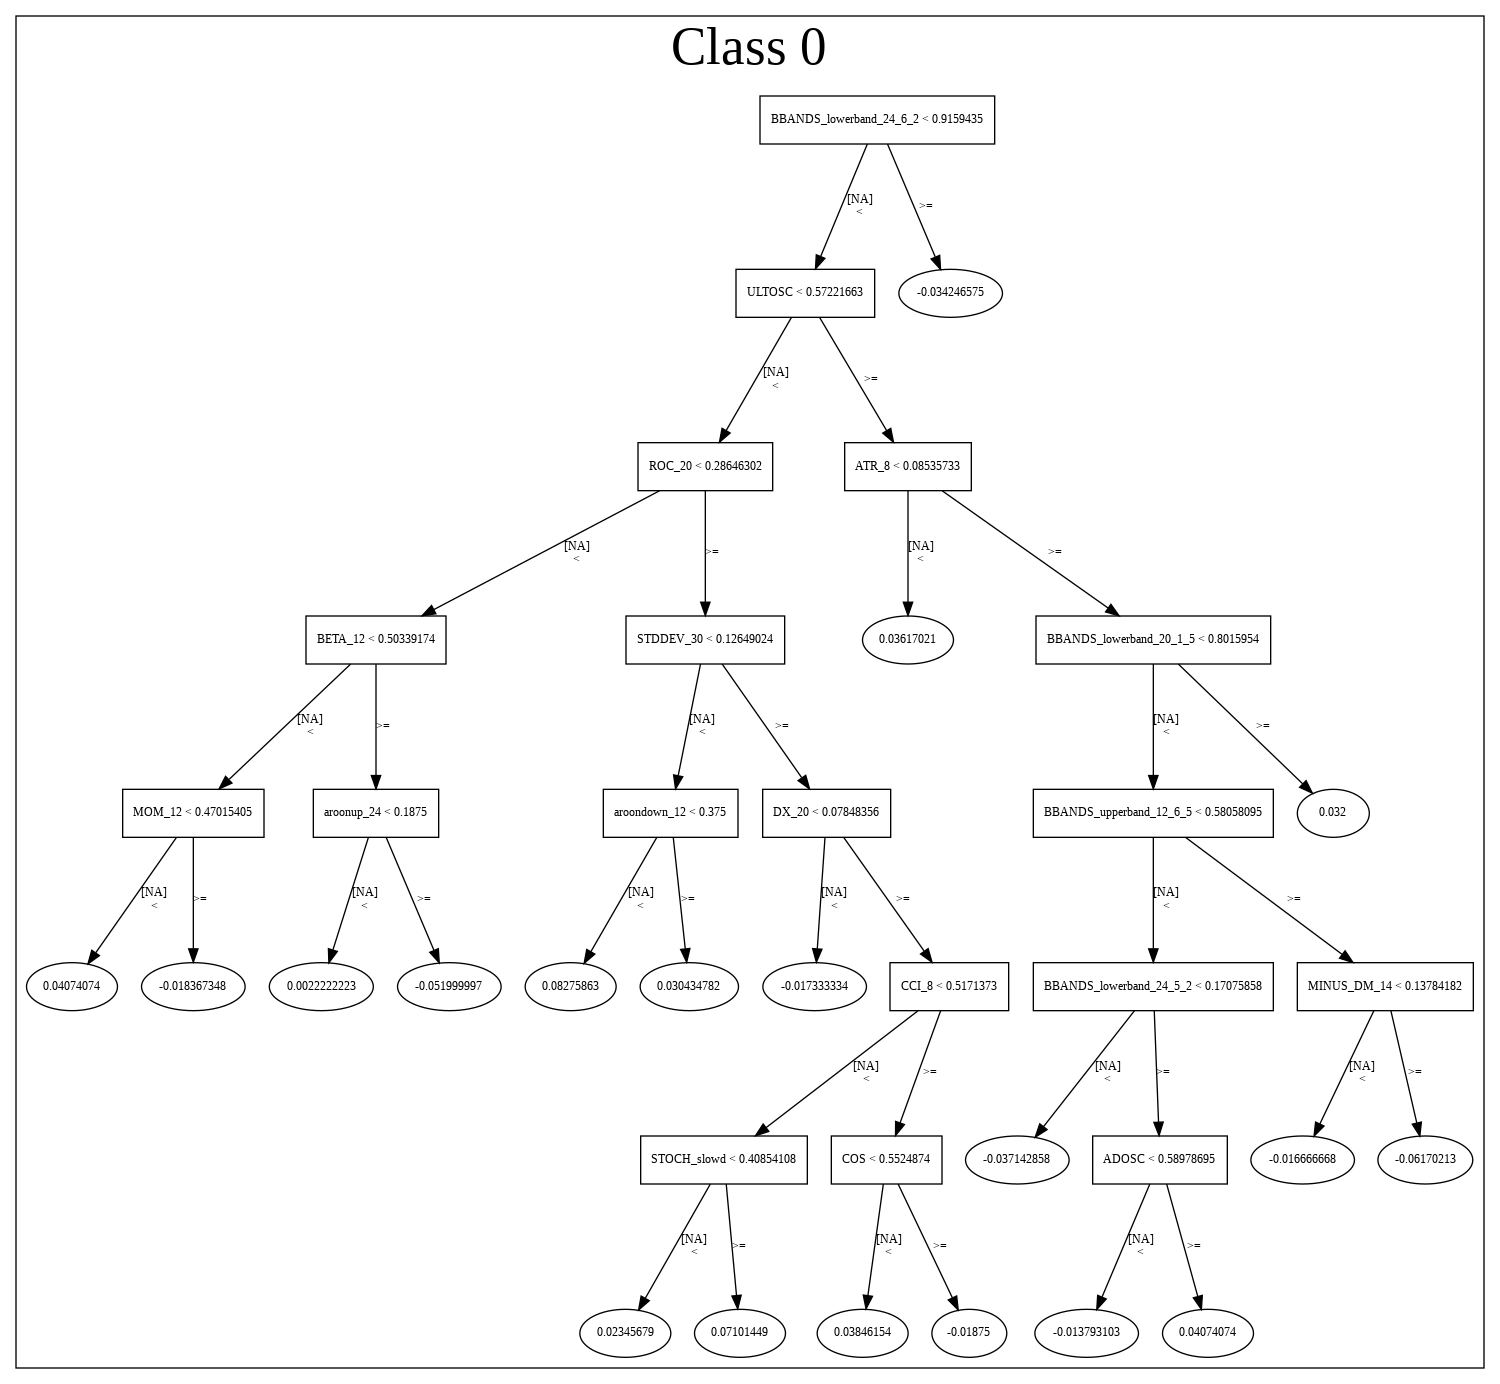

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_141259_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_141259_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['day',
 'COS',
 'BETA_30',
 'BETA_12',
 'ROC_8',
 'ROCP_8',
 'BETA_8',
 'SIN',
 'weekday_name',
 'SAREXT',
 'WILLR_8',
 'WILLR_12',
 'ADXR_8',
 'PLUS_DI_30',
 'aroondown_8',
 'WILLR_14',
 'HT_TRENDMODE',
 'HT_PHASOR_inphase',
 'STDDEV_8',
 'STOCHF_fastk',
 'aroonup_14',
 'CDLDOJI',
 'days_in_month',
 'DX_30',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_30',
 'STOCH_slowd',
 'DX_24',
 'CDLLONGLEGGEDDOJI',
 'aroondown_12',
 'DX_12',
 'BOP',
 'CORREL_12',
 'weekday',
 'dayofweek',
 'aroondown_20',
 'DX_14',
 'month',
 'aroonup_24',
 'quarter',
 'DX_20',
 'STOCHRSI_fastk',
 'CCI_8',
 'ADXR_12',
 'weekofyear',
 'week',
 'dayofyear',
 'STOCHRSI_fastd',
 'ADXR_14']

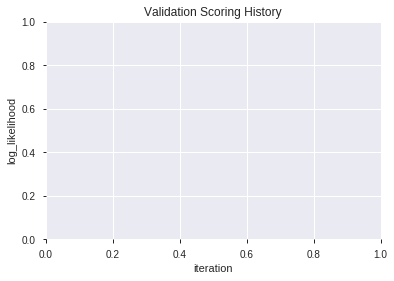

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190828_141314  0.567998  0.691005              0.491150  0.498159  0.248163
1  XGBoost_grid_1_AutoML_20190828_141314_model_7  0.529477  0.703621              0.500000  0.504527  0.254547
2  XGBoost_grid_1_AutoML_20190828_141314_model_3  0.524271  0.694989              0.495575  0.500682  0.250683
3  XGBoost_grid_1_AutoML_20190828_141314_model_1  0.516072  0.696849              0.491150  0.501360  0.251362
4               XGBoost_2_AutoML_20190828_141314  0.514381  0.697105              0.495575  0.501818  0.251821
5  XGBoost_grid_1_AutoML_20190828_141314_model_5  0.510932  0.726839              0.500000  0.515583  0.265826
6  XGBoost_grid_1_AutoML_20190828_141314_model_4  0.507939  0.695227              0.500000  0.501007  0.251008
7  XGBoost_grid_1_AutoML_20190828_141314_model_2  0.501432  0.699747              0.500000  0.503229  0.253239
8               XGBoost_3_AutoML_20190828_141314  0.497527  0.704657              0.495575  0.505371  0.255400
9  XGBoost_grid_1_AutoML_20190828_141314_model_6  0.486986  0.702906              0.495575  0.504632  0.254654

variable  relative_importance  scaled_importance  percentage
0                 COS           314.813202           1.000000    0.042820
1             BETA_12           311.518463           0.989534    0.042372
2                 SIN           304.263306           0.966488    0.041385
3            STDDEV_8           290.116730           0.921552    0.039461
4             BETA_30           287.724884           0.913954    0.039135
5                 BOP           275.571808           0.875350    0.037482
6                 day           269.907318           0.857357    0.036712
7              SAREXT           258.146790           0.820000    0.035112
8              ADXR_8           225.617691           0.716672    0.030688
9           CORREL_12           222.741302           0.707535    0.030296
10  HT_PHASOR_inphase           210.885742           0.669876    0.028684
11          dayofyear           206.086441           0.654631    0.028031
12             BETA_8           196.657120           0.624679    0.026749
13       STOCHF_fastk           193.829376           0.615696    0.026364
14              CCI_8           191.505005           0.608313    0.026048
15            ADXR_12           185.871140           0.590417    0.025282
16     STOCHRSI_fastd           183.733368           0.583627    0.024991
17              DX_30           183.256653           0.582112    0.024926
18              DX_14           179.932678           0.571554    0.024474
19         PLUS_DI_30           179.002945           0.568601    0.024347
20              DX_24           165.240433           0.524884    0.022475
21            ADXR_14           164.851746           0.523649    0.022423
22           WILLR_12           162.598541           0.516492    0.022116
23            WILLR_8           158.953903           0.504915    0.021620
24        STOCH_slowd           156.012039           0.495570    0.021220
25              DX_12           153.323242           0.487029    0.020854
26         aroonup_24           149.096771           0.473604    0.020280
27              DX_20           140.393387           0.445958    0.019096
28        STOCH_slowk           139.209610           0.442197    0.018935
29           WILLR_14           127.823486           0.406030    0.017386
30              ROC_8           127.378517           0.404616    0.017326
31     STOCHRSI_fastk           124.823158           0.396499    0.016978
32          dayofweek           100.072571           0.317879    0.013612
33       aroondown_20            91.439369           0.290456    0.012437
34        aroondown_8            89.953712           0.285737    0.012235
35               week            89.023666           0.282783    0.012109
36         aroonup_14            87.603516           0.278271    0.011916
37             ROCP_8            81.988419           0.260435    0.011152
38       STOCHF_fastd            66.944946           0.212650    0.009106
39       aroondown_12            66.528717           0.211328    0.009049
40         aroonup_30            56.477291           0.179399    0.007682
41         weekofyear            54.388519           0.172764    0.007398
42       weekday_name            51.808514           0.164569    0.007047
43      days_in_month            31.954287           0.101502    0.004346
44              month            20.146818           0.063996    0.002740
45            weekday            12.415464           0.039438    0.001689
46            quarter             6.788660           0.021564    0.000923
47            CDLDOJI             3.632870           0.011540    0.000494

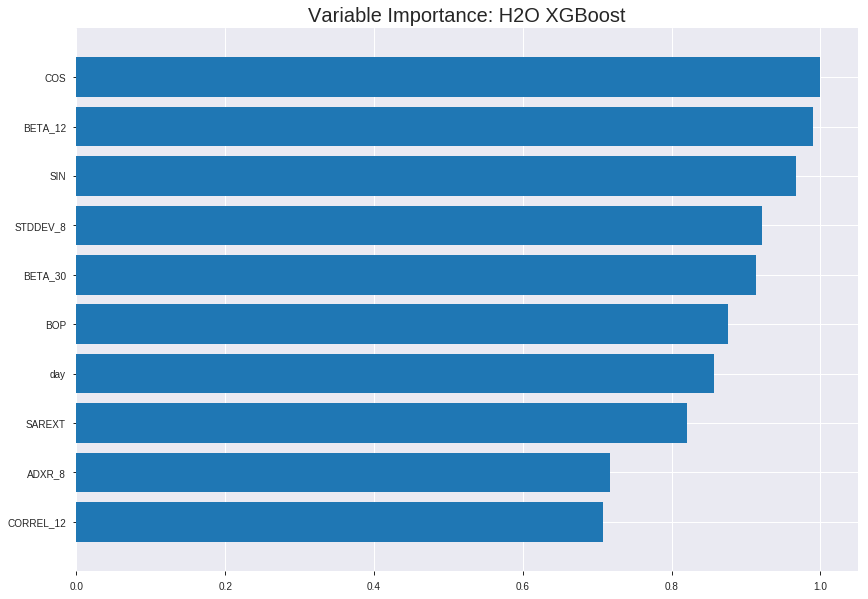

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190828_141314


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15609789582422637
RMSE: 0.3950922624200914
LogLoss: 0.49758996190229765
Mean Per-Class Error: 0.08634080705540681
AUC: 0.9738526304570827
pr_auc: 0.9786087566203592
Gini: 0.9477052609141654
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5305642485618591: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      712  74   0.0941   (74.0/786.0)
1      75   880  0.0785   (75.0/955.0)
Total  787  954  0.0856   (149.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530564     0.921949  206
max f2                       0.477735     0.947507  246
max f0point5                 0.560082     0.936269  184
max accuracy                 0.530564     0.914417  206
max precision                0.825783     1         0
max recall                   0.373306     1         329
max specificity              0.825783     1         0
max absolute_mcc             0.530564     0.827226  206
max min_per_class_accuracy   0.533751     0.908901  203
max mean_per_class_accuracy  0.530564     0.913659  206

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.785759           1.82304    1.82304            1                0.798076  1                           0.798076            0.0188482       0.0188482                  82.3037   82.3037
    2        0.0201034                   0.768202           1.82304    1.82304            1                0.774617  1                           0.786682            0.017801        0.0366492                  82.3037   82.3037
    3        0.0304423                   0.756216           1.82304    1.82304            1                0.761873  1                           0.778256            0.0188482       0.0554974                  82.3037   82.3037
    4        0.0402068                   0.748238           1.82304    1.82304            1                0.752243  1                           0.771939            0.017801        0.0732984                  82.3037   82.3037
    5        0.0505457                   0.74083            1.82304    1.82304            1                0.744337  1                           0.766293            0.0188482       0.0921466                  82.3037   82.3037
    6        0.100517                    0.716683           1.82304    1.82304            1                0.728672  1                           0.74759             0.0910995       0.183246                   82.3037   82.3037
    7        0.150488                    0.697628           1.82304    1.82304            1                0.707723  1                           0.734352            0.0910995       0.274346                   82.3037   82.3037
    8        0.20046                     0.679058           1.82304    1.82304            1                0.686038  1                           0.722308            0.0910995       0.365445                   82.3037   82.3037
    9        0.300402                    0.638765           1.80208    1.81607            0.988506         0.657804  0.996176                    0.700848            0.180105        0.54555                    80.2082   81.6065
    10       0.400345                    0.599292           1.77065    1.80473            0.971264         0.619572  0.989957                    0.680558            0.176963        0.722513                   77.0651   80.4728
    11       0.500287                    0.549652           1.46681    1.73722            0.804598         0.574153  0.952928                    0.659301            0.146597        0.86911                    46.6811   73.7222
    12       0.60023                     0.501128           0.880087   1.5945             0.482759         0.527702  0.874641                    0.637389            0.0879581       0.957068                   -11.9913  59.4503
    13       0.700172                    0.452145           0.314317   1.41177            0.172414         0.474713  0.774405                    0.614169            0.0314136       0.988482                   -68.5683  41.1769
    14       0.800115                    0.406764           0.0838178  1.24589            0.045977         0.429809  0.683417                    0.59114             0.00837696      0.996859                   -91.6182  24.5894
    15       0.900057                    0.356361           0.0314317  1.11104            0.0172414        0.381979  0.609445                    0.567915            0.00314136      1                          -96.8568  11.104
    16       1                           0.207447           0          1                  0                0.3174    0.548535                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2553999451703856
RMSE: 0.5053710964928501
LogLoss: 0.7050989110242495
Mean Per-Class Error: 0.46529414633353383
AUC: 0.518815937058049
pr_auc: 0.5694960580624395
Gini: 0.03763187411609792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2676508128643036: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267651     0.704811  399
max f2                       0.267651     0.856511  399
max f0point5                 0.267651     0.598763  399
max accuracy                 0.267651     0.544177  399
max precision                0.832575     1         0
max recall                   0.267651     1         399
max specificity              0.832575     1         0
max absolute_mcc             0.347311     0.116943  391
max min_per_class_accuracy   0.571685     0.523985  198
max mean_per_class_accuracy  0.576902     0.534706  190

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 56.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.778267           1.10258   1.10258            0.6              0.808187  0.6                         0.808187            0.0110701       0.0110701                  10.2583    10.2583
    2        0.0200803                   0.750672           1.47011   1.28635            0.8              0.766073  0.7                         0.78713             0.0147601       0.0258303                  47.0111    28.6347
    3        0.0301205                   0.730855           0.735055  1.10258            0.4              0.740034  0.6                         0.771432            0.00738007      0.0332103                  -26.4945   10.2583
    4        0.0401606                   0.717395           1.83764   1.28635            1                0.724335  0.7                         0.759657            0.0184502       0.0516605                  83.7638    28.6347
    5        0.0502008                   0.708044           1.47011   1.3231             0.8              0.713352  0.72                        0.750396            0.0147601       0.0664207                  47.0111    32.31
    6        0.100402                    0.676462           1.10258   1.21284            0.6              0.691933  0.66                        0.721165            0.0553506       0.121771                   10.2583    21.2841
    7        0.150602                    0.656686           0.66155   1.02908            0.36             0.666236  0.56                        0.702855            0.0332103       0.154982                   -33.845    2.90775
    8        0.200803                    0.638945           0.882066  0.992325           0.48             0.648419  0.54                        0.689246            0.0442804       0.199262                   -11.7934   -0.767528
    9        0.301205                    0.615412           1.10258   1.02908            0.6              0.626717  0.56                        0.668403            0.110701        0.309963                   10.2583    2.90775
    10       0.399598                    0.5977             1.16259   1.06195            0.632653         0.606264  0.577889                    0.653103            0.114391        0.424354                   16.2588    6.19518
    11       0.5                         0.571485           0.992325  1.04797            0.54             0.583045  0.570281                    0.639035            0.099631        0.523985                   -0.767528  4.79705
    12       0.600402                    0.550348           0.955572  1.03252            0.52             0.560403  0.561873                    0.625886            0.095941        0.619926                   -4.4428    3.25192
    13       0.698795                    0.526234           0.825062  1.00331            0.44898          0.539013  0.545977                    0.613653            0.0811808       0.701107                   -17.4938   0.330831
    14       0.799197                    0.490866           0.882066  0.988077           0.48             0.510112  0.537688                    0.600646            0.0885609       0.789668                   -11.7934   -1.19231
    15       0.899598                    0.44328            1.06583   0.996755           0.58             0.470216  0.542411                    0.586089            0.107011        0.896679                   6.58303    -0.324526
    16       1                           0.267651           1.02908   1                  0.56             0.391836  0.544177                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:13:15  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.451465                         0.5                0.693147              0.5               0                    1                  0.455823
    2019-08-28 14:13:15  0.143 sec   5                  0.486117         0.665697            0.793858        0.813828           1.72176          0.290063                         0.498263           0.689671              0.525497          0.563054             1.10258            0.455823
    2019-08-28 14:13:15  0.250 sec   10                 0.472564         0.639421            0.863354        0.882189           1.82304          0.215393                         0.49585            0.684826              0.558309          0.59778              1.47011            0.453815
    2019-08-28 14:13:15  0.344 sec   15                 0.462238         0.619713            0.891568        0.909087           1.82304          0.201034                         0.497127           0.68735               0.538331          0.585928             1.47011            0.453815
    2019-08-28 14:13:15  0.444 sec   20                 0.450742         0.598079            0.915655        0.929094           1.82304          0.160827                         0.497925           0.688931              0.53278           0.583914             1.47011            0.453815
    2019-08-28 14:13:15  0.539 sec   25                 0.440193         0.578435            0.929585        0.941328           1.82304          0.149339                         0.498894           0.690947              0.531056          0.577116             1.10258            0.453815
    2019-08-28 14:13:15  0.633 sec   30                 0.43069          0.561002            0.943138        0.951566           1.82304          0.131534                         0.499779           0.692798              0.53343           0.582181             1.10258            0.455823
    2019-08-28 14:13:15  0.741 sec   35                 0.421634         0.544644            0.955014        0.962881           1.82304          0.126939                         0.500617           0.6946                0.529496          0.581472             1.10258            0.455823
    2019-08-28 14:13:16  0.856 sec   40                 0.412672         0.528503            0.961464        0.968929           1.82304          0.108558                         0.502692           0.698939              0.52292           0.579877             1.10258            0.455823
    2019-08-28 14:13:16  0.950 sec   45                 0.403668         0.512572            0.9684          0.974298           1.82304          0.097645                         0.50402            0.701909              0.519523          0.571098             1.10258            0.455823
    2019-08-28 14:13:16  1.054 sec   50                 0.395092         0.49759             0.973853        0.978609           1.82304          0.085583                         0.505371           0.705099              0.518816          0.569496             1.10258            0.455823

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ---------------------
COS            314.8132019042969      1.0                   0.0428197611375886
BETA_12        311.5184631347656      0.9895343055831157    0.04237162260251862
SIN            304.2633056640625      0.966488393191841     0.041384802138726445
STDDEV_8       290.1167297363281      0.9215519806076098    0.039460635685489534
BETA_30        287.7248840332031      0.9139543141544344    0.039135305422761495
---            ---                    ---                   ---
days_in_month  31.954286575317383     0.10150237150801407   0.004346307302871941
month          20.146818161010742     0.06399610321023122   0.002740297853198568
weekday        12.415464401245117     0.039437559562763874  0.0016887068803269722
quarter        6.788660049438477      0.02156408946122351   0.0009233691598791822
CDLDOJI        3.6328697204589844     0.011539762940320959  0.0004941298926889405


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5983935742971888)

('F1', 0.7101827676240209)

('auc', 0.5679984383133785)

('logloss', 0.6910051154356327)

('mean_per_class_error', 0.40581077563768875)

('rmse', 0.49815927609371163)

('mse', 0.24816266435821083)

xgboost prediction progress: |████████████████████████████████████████████| 100%


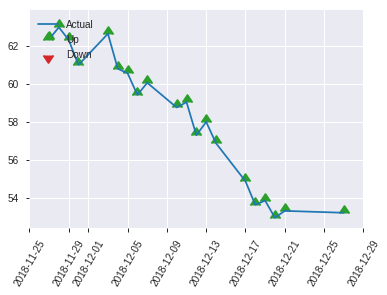


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24816266435821083
RMSE: 0.49815927609371163
LogLoss: 0.6910051154356327
Mean Per-Class Error: 0.40581077563768875
AUC: 0.5679984383133785
pr_auc: 0.5636326754835538
Gini: 0.13599687662675697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3239525258541107: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    136  0        (0.0/136.0)
Total  2    247  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323953     0.710183  246
max f2                       0.323953     0.859671  246
max f0point5                 0.560619     0.632267  137
max accuracy                 0.560619     0.598394  137
max precision                0.617792     0.653333  74
max recall                   0.323953     1         246
max specificity              0.781668     0.99115   0
max absolute_mcc             0.560619     0.188686  137
max min_per_class_accuracy   0.580739     0.557522  125
max mean_per_class_accuracy  0.560619     0.594189  137

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 56.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.740511           0.610294  0.610294           0.333333         0.761319  0.333333                    0.761319            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.733527           0         0.366176           0                0.738346  0.2                         0.75213             0               0.00735294                 -100      -63.3824
    3        0.0321285                   0.723655           1.22059   0.686581           0.666667         0.728763  0.375                       0.743367            0.0147059       0.0220588                  22.0588   -31.3419
    4        0.0401606                   0.714445           0.915441  0.732353           0.5              0.718584  0.4                         0.738411            0.00735294      0.0294118                  -8.45588  -26.7647
    5        0.0522088                   0.708672           0.610294  0.704186           0.333333         0.712454  0.384615                    0.732421            0.00735294      0.0367647                  -38.9706  -29.5814
    6        0.100402                    0.677738           0.610294  0.659118           0.333333         0.693514  0.36                        0.713746            0.0294118       0.0661765                  -38.9706  -34.0882
    7        0.15261                     0.659633           1.40837   0.915441           0.769231         0.668724  0.5                         0.698343            0.0735294       0.139706                   40.8371   -8.45588
    8        0.200803                    0.642418           1.52574   1.06191            0.833333         0.650675  0.58                        0.686903            0.0735294       0.213235                   52.5735   6.19118
    9        0.301205                    0.617366           1.46471   1.19618            0.8              0.628817  0.653333                    0.667541            0.147059        0.360294                   46.4706   19.6176
    10       0.401606                    0.601115           0.878824  1.11684            0.48             0.608498  0.61                        0.65278             0.0882353       0.448529                   -12.1176  11.6838
    11       0.502008                    0.581304           1.02529   1.09853            0.56             0.590814  0.6                         0.640387            0.102941        0.551471                   2.52941   9.85294
    12       0.598394                    0.551012           1.22059   1.11819            0.666667         0.56382   0.610738                    0.628054            0.117647        0.669118                   22.0588   11.819
    13       0.698795                    0.519812           0.659118  1.05223            0.36             0.536557  0.574713                    0.614908            0.0661765       0.735294                   -34.0882  5.22312
    14       0.799197                    0.49265            1.02529   1.04885            0.56             0.507766  0.572864                    0.601448            0.102941        0.838235                   2.52941   4.88472
    15       0.899598                    0.46161            0.805588  1.0217             0.44             0.475529  0.558036                    0.587394            0.0808824       0.919118                   -19.4412  2.16977
    16       1                           0.254368           0.805588  1                  0.44             0.396089  0.546185                    0.568187   

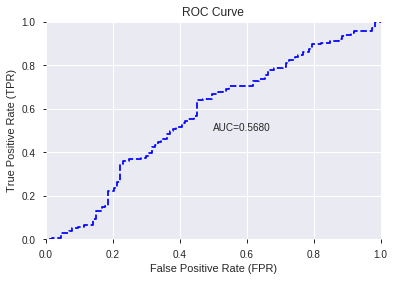

This function is available for GLM models only


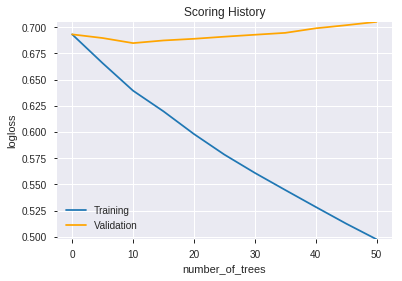

--2019-08-28 14:13:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

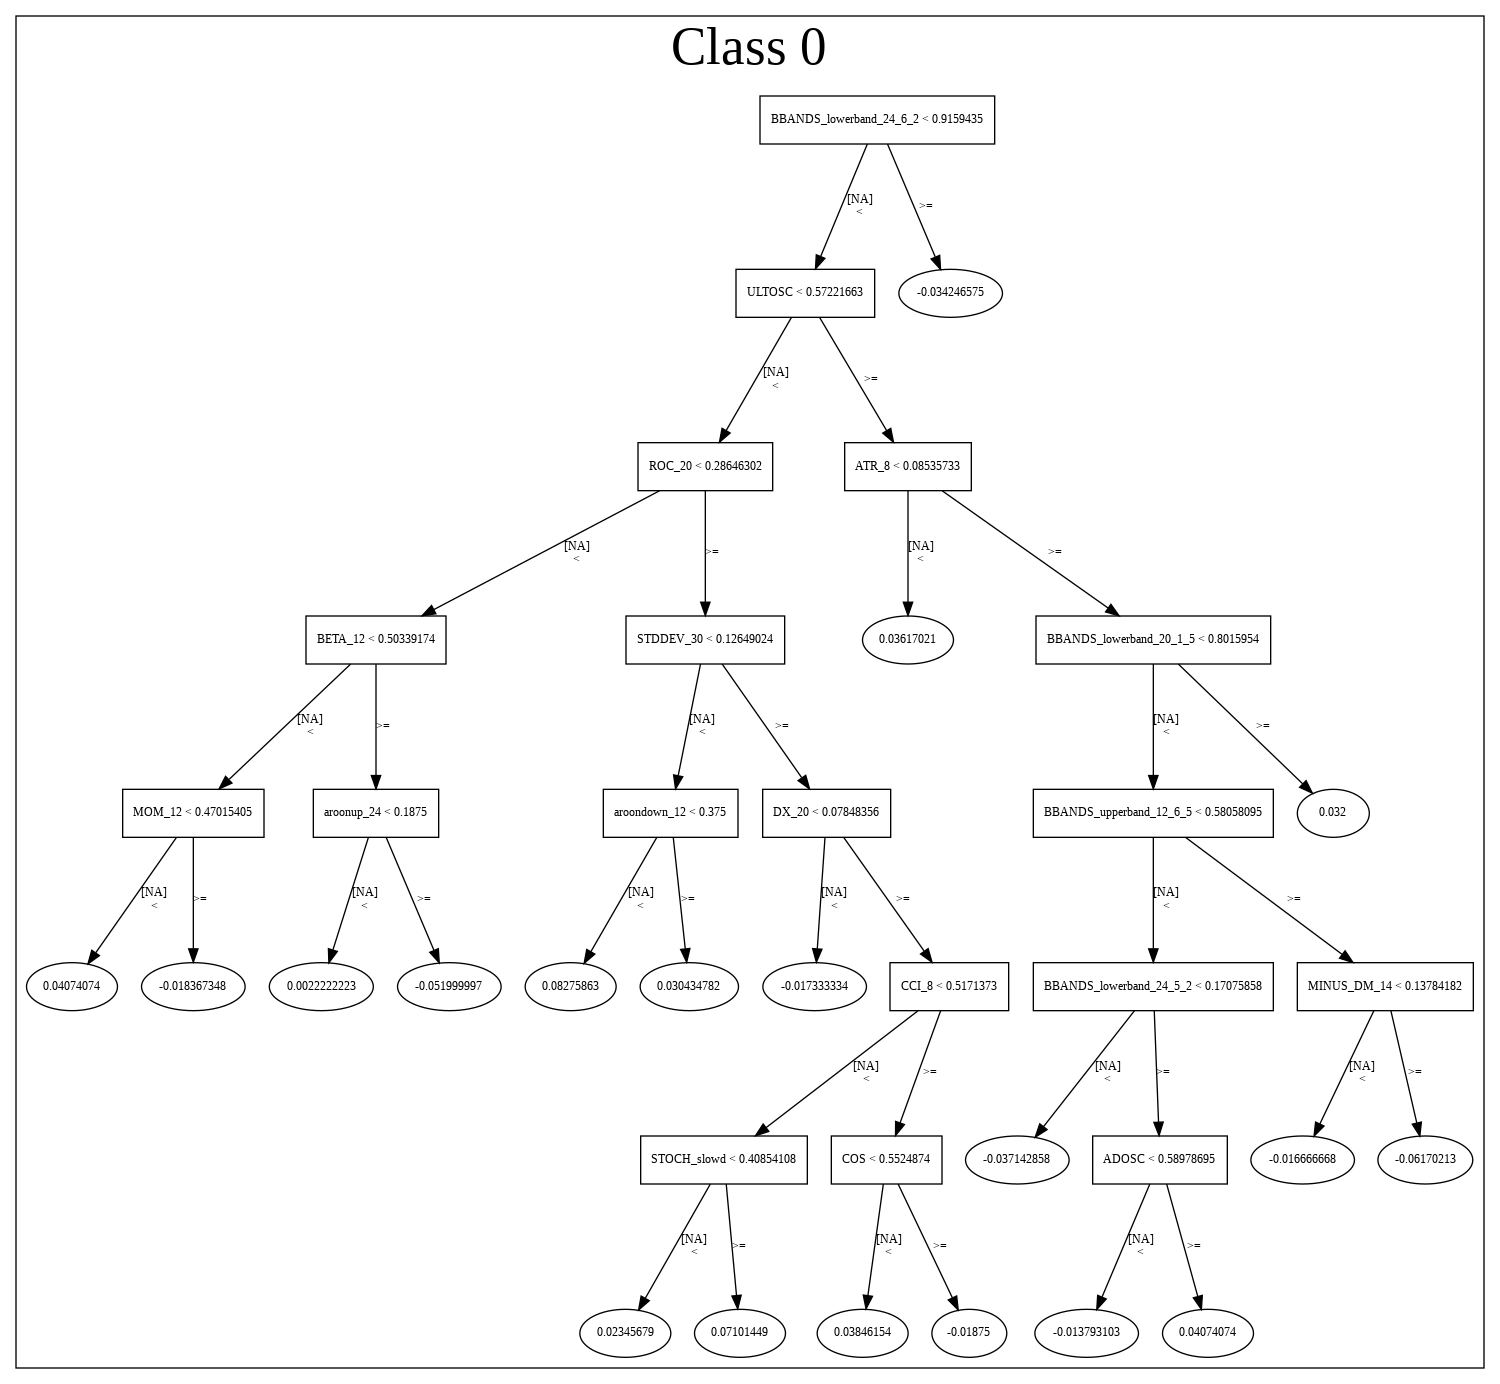

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190828_141314',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190828_141314',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_a1f3',
   'type

['COS',
 'BETA_12',
 'SIN',
 'STDDEV_8',
 'BETA_30',
 'BOP',
 'day',
 'SAREXT',
 'ADXR_8',
 'CORREL_12',
 'HT_PHASOR_inphase',
 'dayofyear',
 'BETA_8',
 'STOCHF_fastk',
 'CCI_8',
 'ADXR_12',
 'STOCHRSI_fastd',
 'DX_30',
 'DX_14',
 'PLUS_DI_30',
 'DX_24',
 'ADXR_14',
 'WILLR_12',
 'WILLR_8',
 'STOCH_slowd',
 'DX_12',
 'aroonup_24',
 'DX_20',
 'STOCH_slowk',
 'WILLR_14',
 'ROC_8',
 'STOCHRSI_fastk',
 'dayofweek',
 'aroondown_20',
 'aroondown_8',
 'week',
 'aroonup_14',
 'ROCP_8',
 'STOCHF_fastd',
 'aroondown_12',
 'aroonup_30',
 'weekofyear',
 'weekday_name',
 'days_in_month',
 'month',
 'weekday',
 'quarter',
 'CDLDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_141343_model_7  0.547827  0.912418              0.433563  0.548854  0.301240
1  DeepLearning_grid_1_AutoML_20190828_141343_model_5  0.544476  0.688827              0.477128  0.497782  0.247787
2  DeepLearning_grid_1_AutoML_20190828_141343_model_6  0.508654  0.690265              0.500000  0.498558  0.248560
3  DeepLearning_grid_1_AutoML_20190828_141343_model_9  0.506767  0.688800              0.500000  0.497826  0.247830
4  DeepLearning_grid_1_AutoML_20190828_141343_model_8  0.506637  0.688868              0.458680  0.497859  0.247864
5  DeepLearning_grid_1_AutoML_20190828_141343_model_3  0.499349  0.748459              0.500000  0.522544  0.273052
6  DeepLearning_grid_1_AutoML_20190828_141343_model_2  0.496877  0.738810              0.500000  0.518299  0.268633
7  DeepLearning_grid_1_AutoML_20190828_141343_model_1  0.490272  2.596399              0.494827  0.644448  0.415313
8               DeepLearning_1_AutoML_20190828_141343  0.485685  1.150594              0.485229  0.548161  0.300480
9  DeepLearning_grid_1_AutoML_20190828_141343_model_4  0.484774  0.958955              0.494827  0.583786  0.340806

variable  relative_importance  scaled_importance  percentage
0                weekday_name             1.000000           1.000000    0.001121
1                         SIN             0.975610           0.975610    0.001094
2                      SAREXT             0.946402           0.946402    0.001061
3                         COS             0.943792           0.943792    0.001058
4                     CDLDOJI             0.942227           0.942227    0.001056
...                       ...                  ...                ...         ...
1038   BBANDS_lowerband_8_2_4             0.794360           0.794360    0.000890
1039            CDLHIKKAKEMOD             0.791761           0.791761    0.000888
1040  BBANDS_upperband_30_0_2             0.791261           0.791261    0.000887
1041            MINMAX_min_12             0.790077           0.790077    0.000886
1042                  TRIMA_8             0.786564           0.786564    0.000882

[1043 rows x 4 columns]

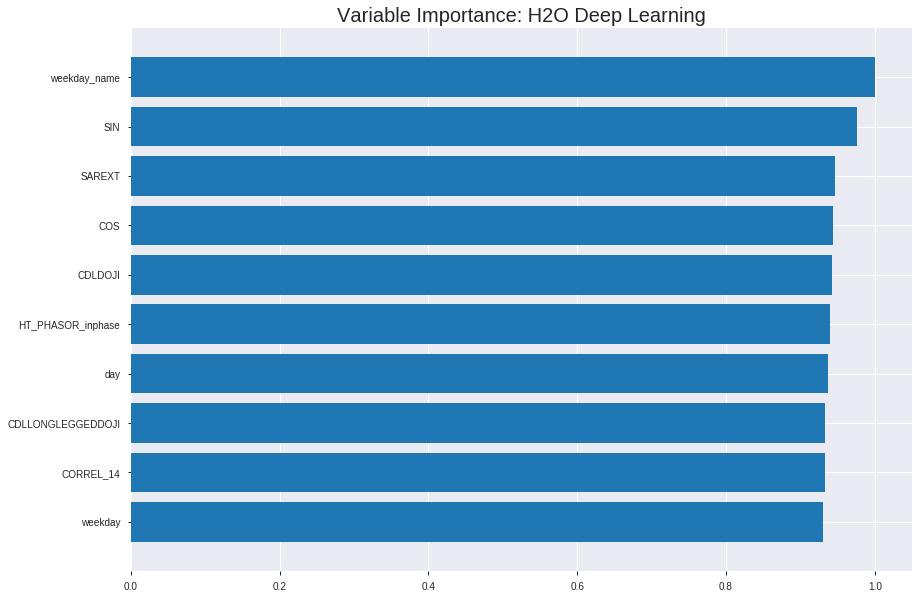

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_141343_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25925351486687676
RMSE: 0.5091694363047302
LogLoss: 0.7108939323512075
Mean Per-Class Error: 0.4031440256850911
AUC: 0.6494691126120725
pr_auc: 0.7176395938516269
Gini: 0.29893822522414504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24183861267574627: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      124  662   0.8422   (662.0/786.0)
1      32   923   0.0335   (32.0/955.0)
Total  156  1585  0.3986   (694.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.241839     0.726772  313
max f2                       0.0262843    0.866957  382
max f0point5                 0.300484     0.640426  268
max accuracy                 0.300484     0.612866  268
max precision                0.999745     1         0
max recall                   0.01017      1         390
max specificity              0.999745     1         0
max absolute_mcc             0.299925     0.221445  269
max min_per_class_accuracy   0.357199     0.519084  190
max mean_per_class_accuracy  0.354936     0.596856  195

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 36.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.985401           1.82304   1.82304            1                0.993712   1                           0.993712            0.0188482       0.0188482                  82.3037   82.3037
    2        0.0201034                   0.953581           1.82304   1.82304            1                0.967168   1                           0.980819            0.017801        0.0366492                  82.3037   82.3037
    3        0.0304423                   0.909564           1.62048   1.75424            0.888889         0.937311   0.962264                    0.966043            0.0167539       0.0534031                  62.0477   75.4243
    4        0.0402068                   0.847809           1.60856   1.71886            0.882353         0.884334   0.942857                    0.946199            0.0157068       0.0691099                  60.8562   71.8863
    5        0.0505457                   0.783595           1.62048   1.69874            0.888889         0.816117   0.931818                    0.919592            0.0167539       0.0858639                  62.0477   69.8739
    6        0.100517                    0.481044           1.46681   1.58344            0.804598         0.622295   0.868571                    0.771793            0.0732984       0.159162                   46.6811   58.3438
    7        0.150488                    0.363781           1.21536   1.46121            0.666667         0.408115   0.801527                    0.651029            0.060733        0.219895                   21.5358   46.1213
    8        0.58185                     0.357201           1.04139   1.14997            0.571238         0.35724    0.6308                      0.433225            0.449215        0.66911                    4.13884   14.9971
    9        0.60023                     0.355898           1.02546   1.14616            0.5625           0.356567   0.628708                    0.430878            0.0188482       0.687958                   2.54581   14.6158
    10       0.700172                    0.347102           0.806746  1.09771            0.442529         0.352052   0.602133                    0.419626            0.0806283       0.768586                   -19.3254  9.77103
    11       0.800115                    0.320777           1.01629   1.08754            0.557471         0.336444   0.596554                    0.409236            0.101571        0.870157                   1.62905   8.75402
    12       0.900057                    0.257273           0.848655  1.06101            0.465517         0.295324   0.582004                    0.396587            0.0848168       0.954974                   -15.1345  6.10143
    13       1                           1.51383e-05        0.450521  1                  0.247126         0.0997619  0.548535                    0.366922            0.0450262       1                          -54.9479  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3047540509358367
RMSE: 0.5520453341310265
LogLoss: 0.9220946758272521
Mean Per-Class Error: 0.43917941382057
AUC: 0.555269275159712
pr_auc: 0.594582801405712
Gini: 0.11053855031942406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.011556156677117548: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    225  0.9912   (225.0/227.0)
1      1    270  0.0037   (1.0/271.0)
Total  3    495  0.4538   (226.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0115562    0.704961  397
max f2                       0.00253693   0.856511  399
max f0point5                 0.343057     0.607071  229
max accuracy                 0.345804     0.570281  227
max precision                0.997238     0.833333  2
max recall                   0.00253693   1         399
max specificity              0.99927      0.995595  0
max absolute_mcc             0.345804     0.124351  227
max min_per_class_accuracy   0.357878     0.527675  206
max mean_per_class_accuracy  0.345804     0.560821  227

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 44.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.997257           1.47011   1.47011            0.8              0.998473   0.8                         0.998473            0.0147601       0.0147601                  47.0111   47.0111
    2        0.0200803                   0.993761           0.735055  1.10258            0.4              0.995728   0.6                         0.997101            0.00738007      0.0221402                  -26.4945  10.2583
    3        0.0301205                   0.992791           1.83764   1.3476             1                0.993423   0.733333                    0.995875            0.0184502       0.0405904                  83.7638   34.7601
    4        0.0401606                   0.986163           1.10258   1.28635            0.6              0.990857   0.7                         0.99462             0.0110701       0.0516605                  10.2583   28.6347
    5        0.0502008                   0.978138           1.10258   1.24959            0.6              0.981172   0.68                        0.991931            0.0110701       0.0627306                  10.2583   24.9594
    6        0.100402                    0.895421           1.17609   1.21284            0.64             0.954196   0.66                        0.973063            0.0590406       0.121771                   17.6089   21.2841
    7        0.150602                    0.804022           1.10258   1.17609            0.6              0.852955   0.64                        0.933027            0.0553506       0.177122                   10.2583   17.6089
    8        0.200803                    0.693391           1.10258   1.15771            0.6              0.737125   0.63                        0.884052            0.0553506       0.232472                   10.2583   15.7712
    9        0.301205                    0.520977           0.918819  1.07808            0.5              0.591561   0.586667                    0.786555            0.0922509       0.324723                   -8.11808  7.80812
    10       0.399598                    0.404366           1.16259   1.09889            0.632653         0.454099   0.59799                     0.704694            0.114391        0.439114                   16.2588   9.88893
    11       0.556225                    0.357201           1.03662   1.08135            0.564103         0.369374   0.588448                    0.610272            0.162362        0.601476                   3.66165   8.1354
    12       0.600402                    0.349585           1.08588   1.08169            0.590909         0.353581   0.588629                    0.591385            0.0479705       0.649446                   8.58772   8.16868
    13       0.698795                    0.303978           0.787559  1.04027            0.428571         0.328813   0.566092                    0.554413            0.0774908       0.726937                   -21.2441  4.02723
    14       0.799197                    0.24197            0.808561  1.01116            0.44             0.273193   0.550251                    0.519084            0.0811808       0.808118                   -19.1439  1.11628
    15       0.899598                    0.141992           0.808561  0.988551           0.44             0.198003   0.537946                    0.483249            0.0811808       0.889299                   -19.1439  -1.1449
    16       1                           0.00248054         1.10258   1                  0.6              0.0703148  0.544177                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:25:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:26:01  5.998 sec         125 obs/sec       0.240666  1             419        0.659791         2.59917             -0.757858      0.541755        0.513034           1.0128           0.451465                         0.644731           2.74017               -0.675796        0.548588          0.540503             0.735055           0.445783
    2019-08-28 14:26:27  32.252 sec        200 obs/sec       3.12579   13            5442       0.692268         1.7991              -0.935173      0.585611        0.606617           1.11408          0.422746                         0.710861           1.99381               -1.03719         0.495408          0.550252             0.735055           0.453815
    2019-08-28 14:26:52  56.997 sec        238 obs/sec       6.76393   28            11776      0.616587         1.06437             -0.535183      0.620241        0.70176            1.82304          0.40896                          0.621051           1.17738               -0.554955        0.529171          0.57479              0.735055           0.453815
    2019-08-28 14:27:18  1 min 22.737 sec  255 obs/sec       10.6835   44            18600      0.509169         0.710894            -0.0468785     0.649469        0.71764            1.82304          0.398621                         0.552045           0.922095              -0.228607        0.555269          0.594583             1.47011            0.453815
    2019-08-28 14:27:44  1 min 48.552 sec  266 obs/sec       14.7203   61            25628      0.527899         0.752283            -0.125314      0.667862        0.721497           1.82304          0.383113                         0.568308           1.05289               -0.302059        0.53469           0.582802             1.47011            0.455823
    2019-08-28 14:28:09  2 min 13.663 sec  272 obs/sec       18.6215   77            32420      0.465168         0.604754            0.126244       0.702351        0.751683           1.82304          0.378518                         0.564356           1.1742                -0.284014        0.564096          0.579075             1.10258            0.451807
    2019-08-28 14:28:33  2 min 38.176 sec  283 obs/sec       22.9707   95            39992      0.635092         2.04931             -0.628714      0.719494        0.748465           1.82304          0.360138                         0.661001           2.65838               -0.761441        0.534267          0.564226             1.10258            0.453815
    2019-08-28 14:28:57  3 min  1.686 sec  290 obs/sec       27.05     112           47094      0.478204         0.642731            0.0765812      0.714924        0.681412           1.82304          0.346353                         0.594177           1.62129               -0.423294        0.537624          0.533742             1.10258            0.449799
    2019-08-28 14:28:59

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
weekday_name             1.0                    1.0                  0.0011209682157173328
SIN                      0.9756100177764893     0.9756100177764893   0.0010936278208628666
SAREXT                   0.9464017152786255     0.9464017152786255   0.001060886242127704
COS                      0.9437915086746216     0.9437915086746216   0.0010579602834881602
CDLDOJI                  0.9422267079353333     0.9422267079353333   0.001056206191595487
---                      ---                    ---                  ---
BBANDS_lowerband_8_2_4   0.7943598031997681     0.7943598031997681   0.0008904520912304157
CDLHIKKAKEMOD            0.7917612791061401     0.7917612791061401   0.0008875392283136831
BBANDS_upperband_30_0_2  0.7912609577178955     0.7912609577178955   0.0008869783839398173
MINMAX_min_12            0.7900774478912354     0.7900774478912354   0.0008856517070411421
TRIMA_8                  0.7865643501281738     0.7865643501281738   0.0008817136361100425


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6024096385542169)

('F1', 0.7242339832869081)

('auc', 0.5478266527850079)

('logloss', 0.912417914666917)

('mean_per_class_error', 0.4320666319625195)

('rmse', 0.5488536354361983)

('mse', 0.30124031313153127)

deeplearning prediction progress: |███████████████████████████████████████| 100%


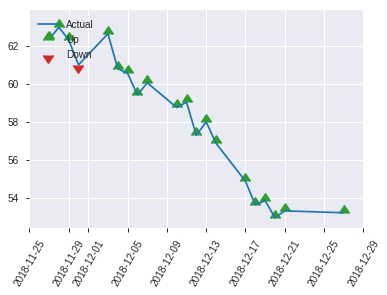


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.30124031313153127
RMSE: 0.5488536354361983
LogLoss: 0.912417914666917
Mean Per-Class Error: 0.4320666319625195
AUC: 0.5478266527850079
pr_auc: 0.5792635046971285
Gini: 0.09565330557001572
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1464617237078495: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      20   93   0.823    (93.0/113.0)
1      6    130  0.0441   (6.0/136.0)
Total  26   223  0.3976   (99.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.146462     0.724234  222
max f2                       0.0765977    0.860077  234
max f0point5                 0.16761      0.632411  218
max accuracy                 0.16761      0.60241   218
max precision                0.998874     1         0
max recall                   0.0088984    1         247
max specificity              0.998874     1         0
max absolute_mcc             0.146462     0.216326  222
max min_per_class_accuracy   0.53149      0.513274  124
max mean_per_class_accuracy  0.16761      0.567933  218

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 54.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.995041           1.83088   1.83088            1                0.997567   1                           0.997567            0.0220588       0.0220588                  83.0882   83.0882
    2        0.0200803                   0.988398           0.915441  1.46471            0.5              0.994702   0.8                         0.996421            0.00735294      0.0294118                  -8.45588  46.4706
    3        0.0321285                   0.9871             1.83088   1.60202            1                0.987847   0.875                       0.993206            0.0220588       0.0514706                  83.0882   60.2022
    4        0.0401606                   0.981736           0.915441  1.46471            0.5              0.986654   0.8                         0.991895            0.00735294      0.0588235                  -8.45588  46.4706
    5        0.0522088                   0.975851           0.610294  1.26753            0.333333         0.97858    0.692308                    0.988823            0.00735294      0.0661765                  -38.9706  26.7534
    6        0.100402                    0.950882           0.610294  0.952059           0.333333         0.962886   0.52                        0.976373            0.0294118       0.0955882                  -38.9706  -4.79412
    7        0.15261                     0.921              0.845023  0.915441           0.461538         0.941417   0.5                         0.964414            0.0441176       0.139706                   -15.4977  -8.45588
    8        0.200803                    0.871374           1.22059   0.988676           0.666667         0.891921   0.54                        0.947016            0.0588235       0.198529                   22.0588   -1.13235
    9        0.301205                    0.729839           1.09853   1.02529            0.6              0.792498   0.56                        0.89551             0.110294        0.308824                   9.85294   2.52941
    10       0.401606                    0.602091           1.09853   1.0436             0.6              0.659059   0.57                        0.836397            0.110294        0.419118                   9.85294   4.36029
    11       0.502008                    0.53149            0.952059  1.02529            0.52             0.56178    0.56                        0.781474            0.0955882       0.514706                   -4.79412  2.52941
    12       0.598394                    0.465748           1.1443    1.04446            0.625            0.498203   0.57047                     0.735846            0.110294        0.625                      14.4301   4.44631
    13       0.698795                    0.393995           1.09853   1.05223            0.6              0.425234   0.574713                    0.691218            0.110294        0.735294                   9.85294   5.22312
    14       0.799197                    0.317998           1.09853   1.05805            0.6              0.35296    0.577889                    0.648723            0.110294        0.845588                   9.85294   5.80476
    15       0.899598                    0.137478           1.09853   1.06257            0.6              0.23232    0.580357                    0.60225             0.110294        0.955882                   9.85294   6.25657
    16       1                           0.00839448         0.439412  1                  0.24             0.0608919  0.546185                

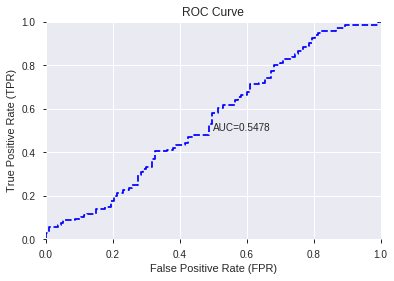

This function is available for GLM models only


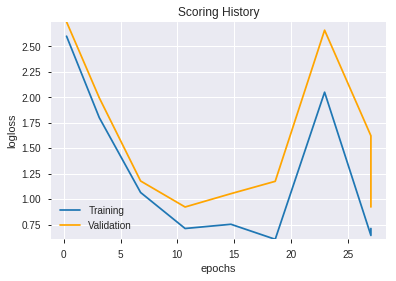

--2019-08-28 14:36:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


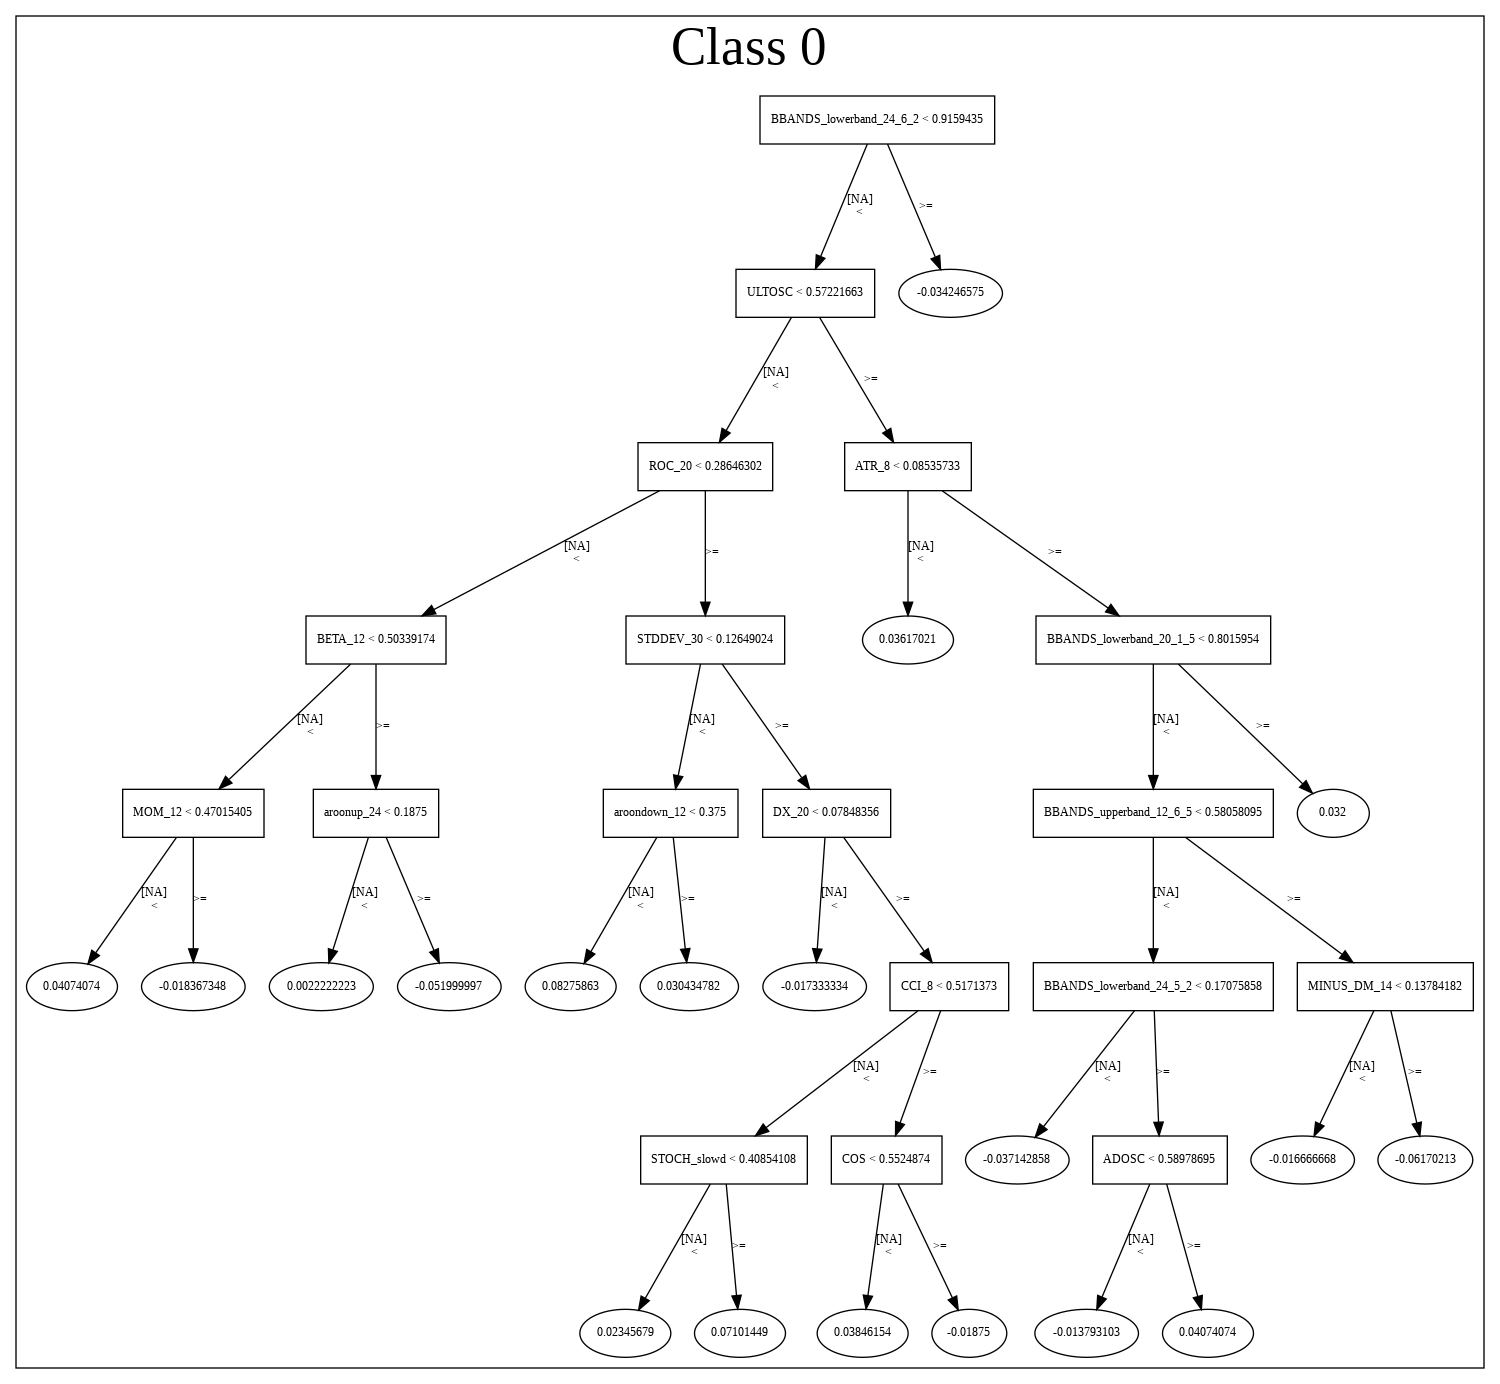

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_141343_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_141343_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'SIN',
 'SAREXT',
 'COS',
 'CDLDOJI',
 'HT_PHASOR_inphase',
 'day',
 'CDLLONGLEGGEDDOJI',
 'CORREL_14',
 'weekday',
 'aroonup_8',
 'is_quarter_start',
 'STOCHF_fastk',
 'BBANDS_upperband_8_8_5',
 'CDLTAKURI',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_upperband_24_6_2',
 'days_in_month',
 'HT_DCPERIOD',
 'CORREL_12',
 'BBANDS_upperband_8_6_4',
 'BBANDS_upperband_20_3_2',
 'CDLHOMINGPIGEON',
 'aroonup_12',
 'dayofweek',
 'CDL2CROWS',
 'BETA_12',
 'STOCHF_fastd',
 'BBANDS_upperband_20_3_5',
 'CDLINNECK',
 'BBANDS_lowerband_12_4_3',
 'CDLBELTHOLD',
 'MACDEXT_hist',
 'fama',
 'BBANDS_upperband_14_0_5',
 'aroondown_8',
 'CDLMORNINGSTAR',
 'CORREL_20',
 'CDLTHRUSTING',
 'MAVP_20_2',
 'T3_8_0',
 'MACDFIX_hist_24',
 'BBANDS_lowerband_8_5_5',
 'BBANDS_middleband_30_2_2',
 'CORREL_30',
 'VAR_12',
 'BBANDS_upperband_30_7_3',
 'STOCH_slowk',
 'BBANDS_lowerband_20_0_3',
 'LINEARREG_INTERCEPT_24',
 'STDDEV_30',
 'aroonup_14',
 'BBANDS_upperband_20_6_2',
 'MAVP_30_7',
 'TRIMA_20',
 'STOCHR

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_143612_model_1  0.499935  0.690509               0.49115  0.498656  0.248658

variable  relative_importance  scaled_importance    percentage
0                          day         7.167917e-03           1.000000  9.942456e-03
1                         SINH         6.770981e-03           0.944623  9.391874e-03
2                         COSH         6.758505e-03           0.942883  9.374570e-03
3                          EXP         6.753762e-03           0.942221  9.367991e-03
4          CDLXSIDEGAP3METHODS         6.701663e-03           0.934953  9.295725e-03
...                        ...                  ...                ...           ...
1038                   MA_20_6         8.213309e-08           0.000011  1.139250e-07
1039  BBANDS_middleband_20_0_2         6.144245e-08           0.000009  8.522544e-08
1040   BBANDS_upperband_14_1_2         1.355644e-08           0.000002  1.880383e-08
1041  BBANDS_middleband_20_6_4         0.000000e+00           0.000000  0.000000e+00
1042  BBANDS_middleband_20_6_5         0.000000e+00           0.000000  0.000000e+00

[1043 rows x 4 columns]

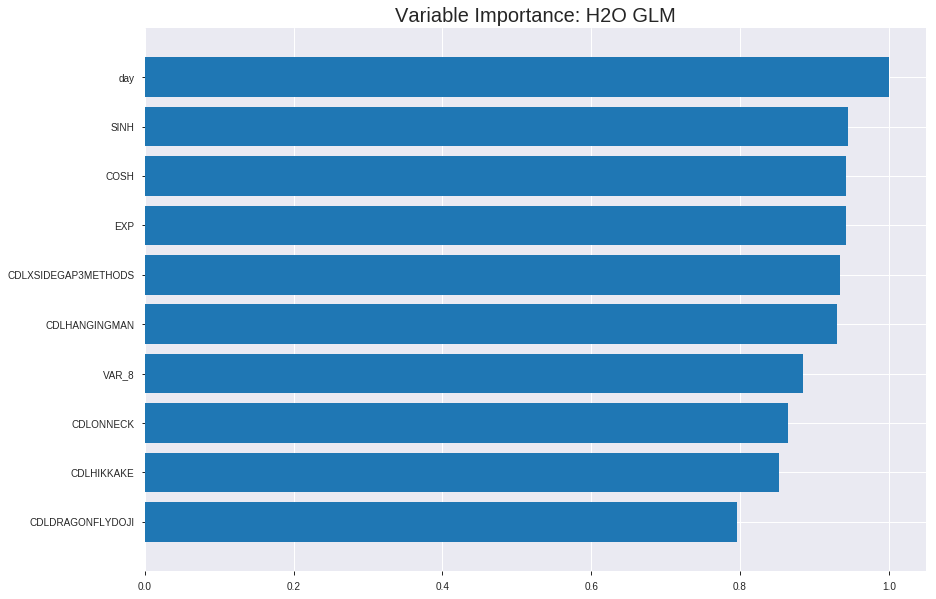

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_143612_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24380541336040074
RMSE: 0.49376655755569426
LogLoss: 0.6806227624518659
Null degrees of freedom: 1740
Residual degrees of freedom: 699
Null deviance: 2397.1076822559344
Residual deviance: 2369.928458857398
AIC: 4453.928458857397
AUC: 0.5796477625461279
pr_auc: 0.6248331830921411
Gini: 0.15929552509225586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4930233070959487: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   761   0.9682   (761.0/786.0)
1      8    947   0.0084   (8.0/955.0)
Total  33   1708  0.4417   (769.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493023     0.711228  375
max f2                       0.445675     0.859431  394
max f0point5                 0.508041     0.615427  340
max accuracy                 0.539418     0.575531  238
max precision                0.673525     1         0
max recall                   0.445675     1         394
max specificity              0.673525     1         0
max absolute_mcc             0.539418     0.141372  238
max min_per_class_accuracy   0.543816     0.559796  222
max mean_per_class_accuracy  0.539418     0.570537  238

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.62682            1.62048   1.62048            0.888889         0.638934  0.888889                    0.638934            0.0167539       0.0167539                  62.0477   62.0477
    2        0.0201034                   0.619709           1.39409   1.51052            0.764706         0.622919  0.828571                    0.631155            0.0136126       0.0303665                  39.4087   51.0516
    3        0.0304423                   0.614072           1.41792   1.47907            0.777778         0.616683  0.811321                    0.62624             0.0146597       0.0450262                  41.7917   47.9067
    4        0.0402068                   0.610501           1.17961   1.40634            0.647059         0.612368  0.771429                    0.622871            0.0115183       0.0565445                  17.9612   40.6343
    5        0.0505457                   0.607202           1.31664   1.38799            0.722222         0.608767  0.761364                    0.619986            0.0136126       0.0701571                  31.6638   38.7994
    6        0.100517                    0.597242           1.11059   1.25008            0.609195         0.602017  0.685714                    0.611053            0.0554974       0.125654                   11.0586   25.0082
    7        0.150488                    0.586732           1.13154   1.21072            0.62069          0.591272  0.664122                    0.604484            0.0565445       0.182199                   13.154    21.0719
    8        0.20046                     0.57912            1.06868   1.17531            0.586207         0.58218   0.644699                    0.598924            0.0534031       0.235602                   6.86767   17.531
    9        0.300402                    0.565784           0.94295   1.098              0.517241         0.572071  0.602294                    0.58999             0.0942408       0.329843                   -5.705    9.80049
    10       0.400345                    0.554106           1.13154   1.10638            0.62069          0.559218  0.606887                    0.582308            0.113089        0.442932                   13.154    10.6377
    11       0.500287                    0.544067           1.08963   1.10303            0.597701         0.548913  0.605052                    0.575637            0.108901        0.551832                   8.96311   10.3031
    12       0.60023                     0.535565           1.04772   1.09382            0.574713         0.54016   0.6                         0.56973             0.104712        0.656545                   4.77222   9.3822
    13       0.700172                    0.527767           0.911518  1.0678             0.5              0.531619  0.585726                    0.56429             0.0910995       0.747644                   -8.84817  6.78
    14       0.800115                    0.520026           0.880087  1.04435            0.482759         0.52387   0.572864                    0.559241            0.0879581       0.835602                   -11.9913  4.43527
    15       0.900057                    0.508357           0.94295   1.03309            0.517241         0.515007  0.566688                    0.554329            0.0942408       0.929843                   -5.705    3.30929
    16       1                           0.334539           0.701974  1                  0.385057         0.496358  0.548535                    0.548535            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.248144417989647
RMSE: 0.4981409619672398
LogLoss: 0.6894736392770515
Null degrees of freedom: 497
Residual degrees of freedom: -544
Null deviance: 686.5201497057026
Residual deviance: 686.7157447199432
AIC: 2770.7157447199434
AUC: 0.5176211453744494
pr_auc: 0.5538525092283239
Gini: 0.03524229074889873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200554536744977: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    224  0.9868   (224.0/227.0)
1      1    270  0.0037   (1.0/271.0)
Total  4    494  0.4518   (225.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.520055     0.705882   395
max f2                       0.511458     0.857052   398
max f0point5                 0.526972     0.605496   372
max accuracy                 0.542913     0.558233   308
max precision                0.585517     0.666667   46
max recall                   0.511458     1          398
max specificity              0.673072     0.995595   0
max absolute_mcc             0.526972     0.0823145  372
max min_per_class_accuracy   0.556201     0.515419   213
max mean_per_class_accuracy  0.544745     0.5336     299

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 55.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.647386           0.735055  0.735055           0.4              0.659202  0.4                         0.659202            0.00738007      0.00738007                 -26.4945   -26.4945
    2        0.0200803                   0.611646           1.10258   0.918819           0.6              0.622921  0.5                         0.641061            0.0110701       0.0184502                  10.2583    -8.11808
    3        0.0301205                   0.605129           1.47011   1.10258            0.8              0.607255  0.6                         0.629792            0.0147601       0.0332103                  47.0111    10.2583
    4        0.0401606                   0.602367           0.735055  1.0107             0.4              0.604208  0.55                        0.623396            0.00738007      0.0405904                  -26.4945   1.07011
    5        0.0502008                   0.598628           0.735055  0.955572           0.4              0.601356  0.52                        0.618988            0.00738007      0.0479705                  -26.4945   -4.4428
    6        0.100402                    0.585024           1.39661   1.17609            0.76             0.591636  0.64                        0.605312            0.0701107       0.118081                   39.6605    17.6089
    7        0.150602                    0.579486           0.882066  1.07808            0.48             0.581834  0.586667                    0.597486            0.0442804       0.162362                   -11.7934   7.80812
    8        0.200803                    0.574701           0.808561  1.0107             0.44             0.577089  0.55                        0.592387            0.0405904       0.202952                   -19.1439   1.07011
    9        0.301205                    0.568066           0.992325  1.00458            0.54             0.57163   0.546667                    0.585468            0.099631        0.302583                   -0.767528  0.457565
    10       0.399598                    0.560941           0.975073  0.997311           0.530612         0.564479  0.542714                    0.5803              0.095941        0.398524                   -2.49266   -0.268872
    11       0.5                         0.556224           1.13934   1.02583            0.62             0.558429  0.558233                    0.575908            0.114391        0.512915                   13.9336    2.58303
    12       0.600402                    0.551878           0.845314  0.995644           0.46             0.553834  0.541806                    0.572217            0.0848708       0.597786                   -15.4686   -0.435646
    13       0.698795                    0.548445           1.08758   1.00859            0.591837         0.550202  0.548851                    0.569117            0.107011        0.704797                   8.75819    0.858888
    14       0.799197                    0.541874           1.13934   1.02501            0.62             0.545001  0.557789                    0.566087            0.114391        0.819188                   13.9336    2.50144
    15       0.899598                    0.532168           0.918819  1.01316            0.5              0.537227  0.551339                    0.562866            0.0922509       0.911439                   -8.11808   1.31622
    16       1                           0.505587           0.882066  1                  0.48             0.525522  0.544177            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 14:36:15  0.000 sec   2            2.9       1042          1.36125           1.37895
    2019-08-28 14:36:18  2.278 sec   4            2.1       1042          1.35798           1.38033
    2019-08-28 14:36:20  4.552 sec   6            1.5       1042          1.35406           1.38213
    2019-08-28 14:36:22  6.745 sec   8            1.1       1042          1.34949           1.38448
    2019-08-28 14:36:24  8.952 sec   10           0.81      1042          1.34427           1.38751

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5582329317269076)

('F1', 0.7101827676240209)

('auc', 0.49993492972410203)

('logloss', 0.6905094168251207)

('mean_per_class_error', 0.47169442998438316)

('rmse', 0.498656288406052)

('mse', 0.2486580939668997)

glm prediction progress: |████████████████████████████████████████████████| 100%


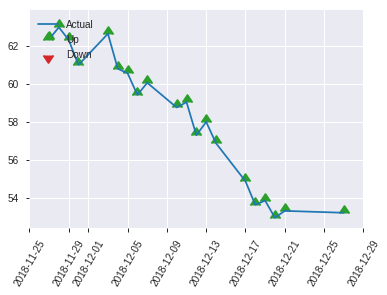


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2486580939668997
RMSE: 0.498656288406052
LogLoss: 0.6905094168251207
Null degrees of freedom: 248
Residual degrees of freedom: -793
Null deviance: 343.0653203047996
Residual deviance: 343.87368957891
AIC: 2427.8736895789098
AUC: 0.49993492972410203
pr_auc: 0.5287589542785202
Gini: -0.00013014055179594308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5260357401770123: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    136  0        (0.0/136.0)
Total  2    247  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526036     0.710183  246
max f2                       0.526036     0.859671  246
max f0point5                 0.540559     0.605     215
max accuracy                 0.540703     0.558233  213
max precision                0.565378     0.569767  85
max recall                   0.526036     1         246
max specificity              0.609906     0.99115   0
max absolute_mcc             0.598317     0.142233  9
max min_per_class_accuracy   0.558286     0.495575  124
max mean_per_class_accuracy  0.544101     0.528306  194

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 56.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.604836           0.610294  0.610294           0.333333         0.606618  0.333333                    0.606618            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.603335           0.915441  0.732353           0.5              0.604125  0.4                         0.605621            0.00735294      0.0147059                  -8.45588  -26.7647
    3        0.0321285                   0.600144           0         0.457721           0                0.602087  0.25                        0.604296            0               0.0147059                  -100      -54.2279
    4        0.0401606                   0.597736           0         0.366176           0                0.598627  0.2                         0.603162            0               0.0147059                  -100      -63.3824
    5        0.0522088                   0.595606           1.83088   0.704186           1                0.596728  0.384615                    0.601677            0.0220588       0.0367647                  83.0882   -29.5814
    6        0.100402                    0.5895             1.22059   0.952059           0.666667         0.592268  0.52                        0.597161            0.0588235       0.0955882                  22.0588   -4.79412
    7        0.15261                     0.582398           0.845023  0.915441           0.461538         0.585838  0.5                         0.593287            0.0441176       0.139706                   -15.4977  -8.45588
    8        0.200803                    0.576683           1.22059   0.988676           0.666667         0.5798    0.54                        0.59005             0.0588235       0.198529                   22.0588   -1.13235
    9        0.301205                    0.5689             1.02529   1.00088            0.56             0.572411  0.546667                    0.58417             0.102941        0.301471                   2.52941   0.0882353
    10       0.401606                    0.56212            0.878824  0.970368           0.48             0.56493   0.53                        0.57936             0.0882353       0.389706                   -12.1176  -2.96324
    11       0.502008                    0.558286           1.09853   0.996              0.6              0.560446  0.544                       0.575578            0.110294        0.5                        9.85294   -0.4
    12       0.598394                    0.553388           1.06801   1.0076             0.583333         0.555966  0.550336                    0.572419            0.102941        0.602941                   6.80147   0.759968
    13       0.698795                    0.549214           1.09853   1.02066            0.6              0.551174  0.557471                    0.569366            0.110294        0.713235                   9.85294   2.06643
    14       0.799197                    0.543668           1.02529   1.02125            0.56             0.545863  0.557789                    0.566414            0.102941        0.816176                   2.52941   2.12459
    15       0.899598                    0.538844           0.878824  1.00535            0.48             0.541369  0.549107                    0.563618            0.0882353       0.904412                   -12.1176  0.535058
    16       1                           0.522463           0.952059  1                  0.52             0.532822  0.546185                    0.56052

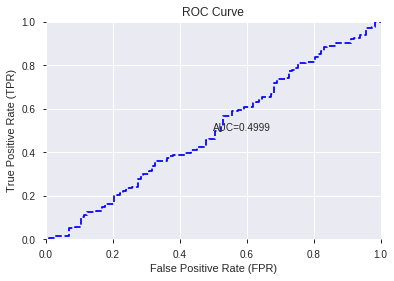

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


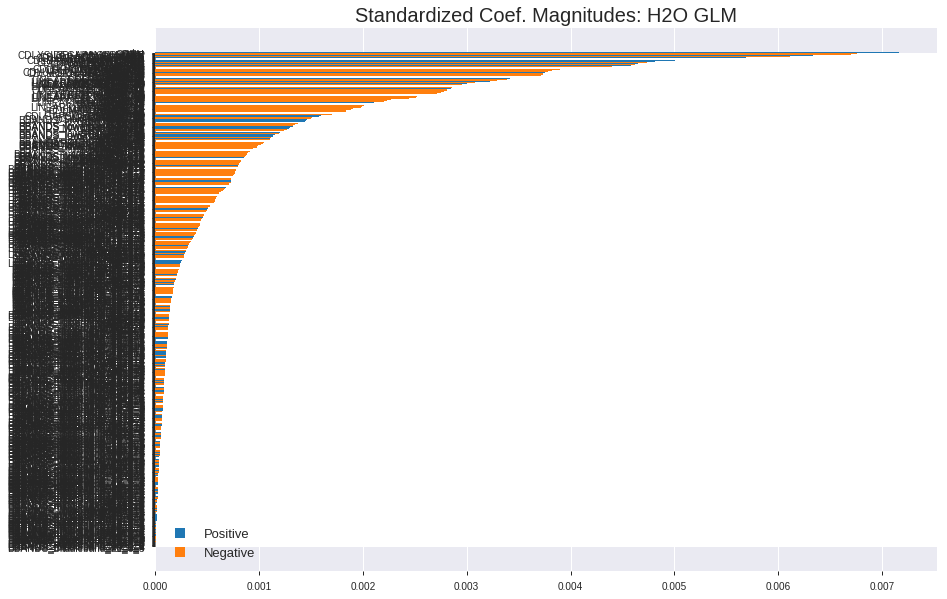

'log_likelihood'
--2019-08-28 14:36:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


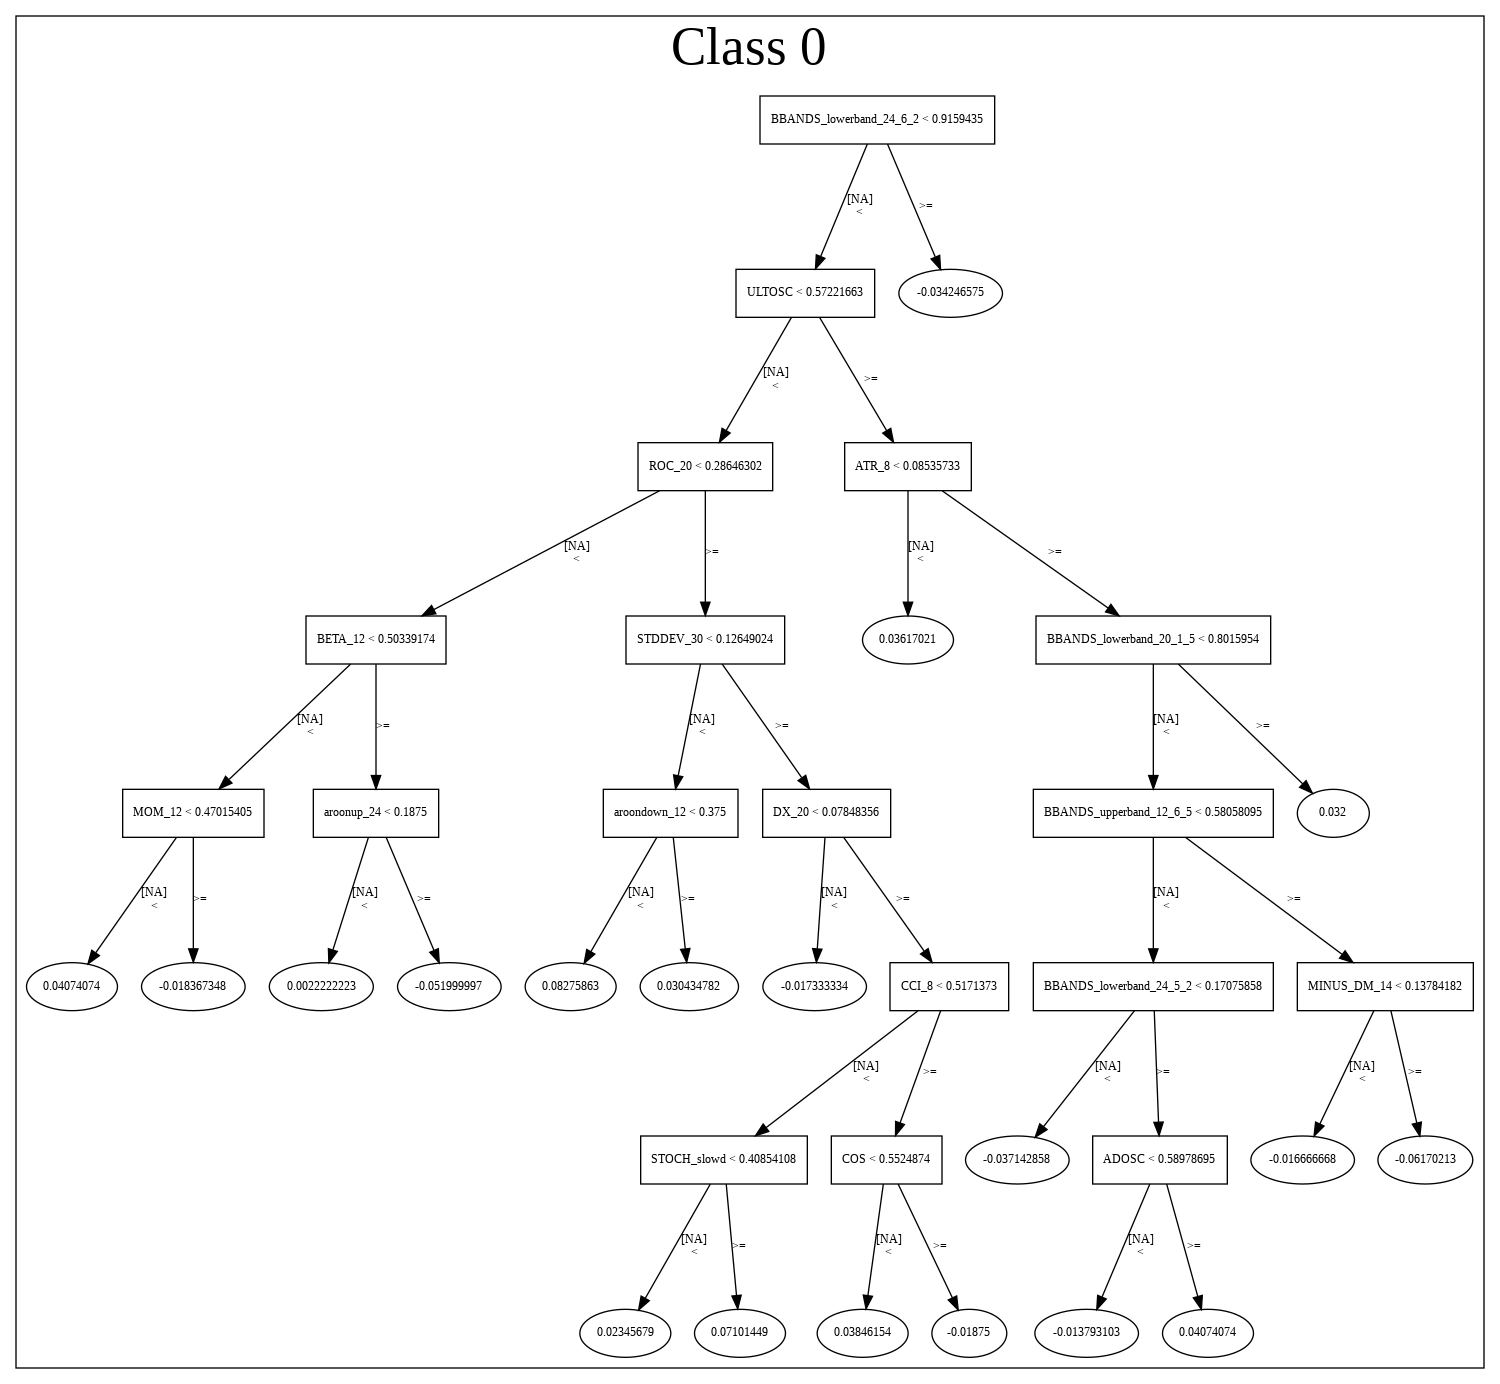

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_143612_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_143612_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['day',
 'SINH',
 'COSH',
 'EXP',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN',
 'VAR_8',
 'CDLONNECK',
 'CDLHIKKAKE',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLCOUNTERATTACK',
 'CDLENGULFING',
 'COS',
 'is_quarter_end',
 'CDLDARKCLOUDCOVER',
 'SIN',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDL3WHITESOLDIERS',
 'is_month_start',
 'TANH',
 'CDLUNIQUE3RIVER',
 'OBV',
 'MACDEXT_signal',
 'CDLTAKURI',
 'CDLINNECK',
 'ADOSC',
 'CDLHARAMI',
 'is_month_end',
 'weekday_name',
 'ULTOSC',
 'STDDEV_8',
 'CDLTASUKIGAP',
 'CDLGRAVESTONEDOJI',
 'CDLHOMINGPIGEON',
 'BETA_12',
 'aroondown_8',
 'TAN',
 'CORREL_30',
 'CDLUPSIDEGAP2CROWS',
 'CDLMORNINGDOJISTAR',
 'MOM_20',
 'CDLHARAMICROSS',
 'CMO_30',
 'ROCP_8',
 'ROC_8',
 'ROCR100_8',
 'ROCR_8',
 'RSI_30',
 'aroonup_20',
 'CDL3INSIDE',
 'CDLDOJISTAR',
 'CDLMARUBOZU',
 'BETA_8',
 'LINEARREG_SLOPE_24',
 'CDLSHORTLINE',
 'ADXR_8',
 'MOM_12',
 'MACDEXT_hist',
 'LINEARREG_ANGLE_24',
 'HT_DCPERIOD',
 'MINUS_DI_30',
 'CDLSTICKSANDWICH',
 'LINEARREG_SLOPE_30',
 'CDLLAD

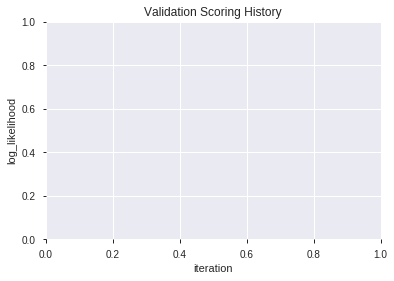

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190828_143659  0.534162  0.694536              0.495575  0.500340  0.250340
1               XGBoost_3_AutoML_20190828_143659  0.529347  0.691929              0.482301  0.499157  0.249158
2  XGBoost_grid_1_AutoML_20190828_143659_model_4  0.522775  0.692648              0.495575  0.499683  0.249683
3  XGBoost_grid_1_AutoML_20190828_143659_model_6  0.522319  0.694652              0.495575  0.500650  0.250650
4  XGBoost_grid_1_AutoML_20190828_143659_model_7  0.517829  0.706223              0.495575  0.505630  0.255662
5  XGBoost_grid_1_AutoML_20190828_143659_model_5  0.500846  0.731528              0.473451  0.515807  0.266057
6  XGBoost_grid_1_AutoML_20190828_143659_model_2  0.493103  0.702987              0.491150  0.504767  0.254790
7  XGBoost_grid_1_AutoML_20190828_143659_model_1  0.486986  0.702239              0.500000  0.504064  0.254080
8  XGBoost_grid_1_AutoML_20190828_143659_model_3  0.473777  0.706801              0.500000  0.506273  0.256313
9               XGBoost_1_AutoML_20190828_143659  0.462259  0.718893              0.495575  0.512129  0.262276

variable  relative_importance  scaled_importance  percentage
0                     ULTOSC           190.155640           1.000000    0.030510
1                        COS           141.387604           0.743536    0.022685
2                        TAN           135.159164           0.710782    0.021686
3                  STDDEV_30           110.386932           0.580508    0.017711
4       HT_PHASOR_quadrature           107.389740           0.564747    0.017230
..                       ...                  ...                ...         ...
268  BBANDS_upperband_14_3_4             3.327139           0.017497    0.000534
269  BBANDS_upperband_14_3_5             3.310650           0.017410    0.000531
270                    VAR_8             3.124544           0.016432    0.000501
271  BBANDS_lowerband_12_1_4             3.052596           0.016053    0.000490
272  BBANDS_lowerband_30_0_5             1.632563           0.008585    0.000262

[273 rows x 4 columns]

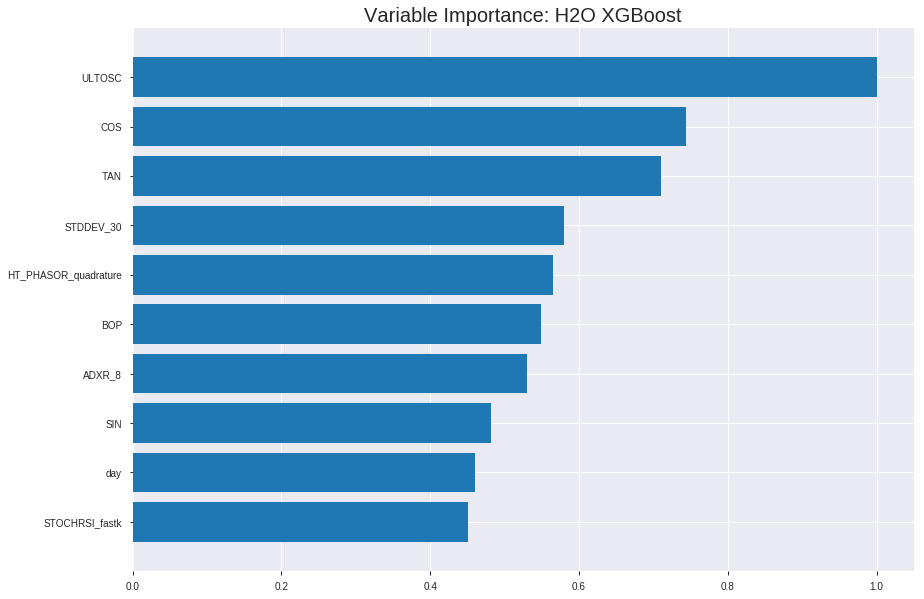

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190828_143659


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16984044436651388
RMSE: 0.41211702751344054
LogLoss: 0.5263907067537884
Mean Per-Class Error: 0.1310006261407084
AUC: 0.9361689514141455
pr_auc: 0.945415342995249
Gini: 0.8723379028282909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5380911529064178: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      692  94   0.1196   (94.0/786.0)
1      136  819  0.1424   (136.0/955.0)
Total  828  913  0.1321   (230.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.538091     0.876874  203
max f2                       0.448241     0.91455   279
max f0point5                 0.554099     0.892898  190
max accuracy                 0.538091     0.867892  203
max precision                0.823444     1         0
max recall                   0.392139     1         327
max specificity              0.823444     1         0
max absolute_mcc             0.538091     0.735391  203
max min_per_class_accuracy   0.532544     0.863874  208
max mean_per_class_accuracy  0.538091     0.868999  203

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.779551           1.82304   1.82304            1                0.795026  1                           0.795026            0.0188482       0.0188482                  82.3037   82.3037
    2        0.0201034                   0.767496           1.82304   1.82304            1                0.773344  1                           0.784495            0.017801        0.0366492                  82.3037   82.3037
    3        0.0304423                   0.758822           1.82304   1.82304            1                0.763324  1                           0.777305            0.0188482       0.0554974                  82.3037   82.3037
    4        0.0402068                   0.74956            1.82304   1.82304            1                0.752886  1                           0.771374            0.017801        0.0732984                  82.3037   82.3037
    5        0.0505457                   0.741039           1.82304   1.82304            1                0.744903  1                           0.76596             0.0188482       0.0921466                  82.3037   82.3037
    6        0.100517                    0.709522           1.82304   1.82304            1                0.724339  1                           0.745268            0.0910995       0.183246                   82.3037   82.3037
    7        0.150488                    0.683118           1.82304   1.82304            1                0.695844  1                           0.728856            0.0910995       0.274346                   82.3037   82.3037
    8        0.20046                     0.66471            1.71826   1.79692            0.942529         0.674329  0.985673                    0.715264            0.0858639       0.360209                   71.8264   79.6919
    9        0.300402                    0.62804            1.71826   1.77075            0.942529         0.645286  0.971319                    0.691982            0.171728        0.531937                   71.8264   77.0751
    10       0.400345                    0.585336           1.56111   1.71841            0.856322         0.60515   0.942611                    0.670305            0.156021        0.687958                   56.1106   71.8415
    11       0.500287                    0.547551           1.39347   1.6535             0.764368         0.566985  0.907003                    0.649665            0.139267        0.827225                   39.3471   65.3501
    12       0.60023                     0.504928           0.859132  1.52123            0.471264         0.525602  0.83445                     0.629008            0.0858639       0.913089                   -14.0868  52.1232
    13       0.700172                    0.458164           0.492429  1.37438            0.270115         0.479037  0.753897                    0.607601            0.0492147       0.962304                   -50.7571  37.4381
    14       0.800115                    0.41709            0.282885  1.23804            0.155172         0.438131  0.67911                     0.586432            0.0282723       0.990576                   -71.7115  23.8042
    15       0.900057                    0.37143            0.094295  1.11104            0.0517241        0.396022  0.609445                    0.565289            0.00942408      1                          -90.5705  11.104
    16       1                           0.234181           0         1                  0                0.331762  0.548535                    0.54195           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25208587183837433
RMSE: 0.5020815390336258
LogLoss: 0.6979295519769886
Mean Per-Class Error: 0.45651608498463836
AUC: 0.5224572069509241
pr_auc: 0.5619699749198701
Gini: 0.04491441390184825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34413576126098633: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344136     0.704811  399
max f2                       0.344136     0.856511  399
max f0point5                 0.506408     0.605278  288
max accuracy                 0.506408     0.564257  288
max precision                0.761228     1         0
max recall                   0.344136     1         399
max specificity              0.761228     1         0
max absolute_mcc             0.506408     0.098619  288
max min_per_class_accuracy   0.559987     0.506608  200
max mean_per_class_accuracy  0.506408     0.543484  288

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 56.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.743161           1.10258   1.10258            0.6              0.754779  0.6                         0.754779            0.0110701       0.0110701                  10.2583    10.2583
    2        0.0200803                   0.722765           1.10258   1.10258            0.6              0.735779  0.6                         0.745279            0.0110701       0.0221402                  10.2583    10.2583
    3        0.0301205                   0.718329           0.735055  0.980074           0.4              0.720265  0.533333                    0.736941            0.00738007      0.0295203                  -26.4945   -1.99262
    4        0.0401606                   0.705653           1.47011   1.10258            0.8              0.712693  0.6                         0.730879            0.0147601       0.0442804                  47.0111    10.2583
    5        0.0502008                   0.69757            1.47011   1.17609            0.8              0.701664  0.64                        0.725036            0.0147601       0.0590406                  47.0111    17.6089
    6        0.100402                    0.671532           0.955572  1.06583            0.52             0.6831    0.58                        0.704068            0.0479705       0.107011                   -4.4428    6.58303
    7        0.150602                    0.652938           1.24959   1.12708            0.68             0.660943  0.613333                    0.689693            0.0627306       0.169742                   24.9594    12.7085
    8        0.200803                    0.63791            0.808561  1.04745            0.44             0.643915  0.57                        0.678248            0.0405904       0.210332                   -19.1439   4.74539
    9        0.301205                    0.608991           0.882066  0.992325           0.48             0.622582  0.54                        0.659693            0.0885609       0.298893                   -11.7934   -0.767528
    10       0.399598                    0.584805           1.05008   1.00655            0.571429         0.595705  0.547739                    0.643937            0.103321        0.402214                   5.00791    0.654564
    11       0.5                         0.559987           1.06583   1.01845            0.58             0.573146  0.554217                    0.629722            0.107011        0.509225                   6.58303    1.84502
    12       0.600402                    0.540865           0.992325  1.01408            0.54             0.550698  0.551839                    0.616507            0.099631        0.608856                   -0.767528  1.40814
    13       0.698795                    0.516418           1.2751    1.05083            0.693878         0.528148  0.571839                    0.604066            0.125461        0.734317                   27.5096    5.08334
    14       0.799197                    0.485922           0.845314  1.02501            0.46             0.502579  0.557789                    0.591316            0.0848708       0.819188                   -15.4686   2.50144
    15       0.899598                    0.454361           0.918819  1.01316            0.5              0.470613  0.551339                    0.577845            0.0922509       0.911439                   -8.11808   1.31622
    16       1                           0.344136           0.882066  1                  0.48             0.417865  0.544177                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:37:04  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.451465                         0.5                0.693147              0.5               0                    1                  0.455823
    2019-08-28 14:37:05  0.880 sec   5                  0.487857         0.669091            0.760504        0.786992           1.72176          0.336588                         0.499283           0.691712              0.504787          0.548511             0.735055           0.455823
    2019-08-28 14:37:06  1.534 sec   10                 0.477195         0.648283            0.814279        0.836185           1.72176          0.282022                         0.498851           0.690838              0.497594          0.553545             1.83764            0.455823
    2019-08-28 14:37:06  2.181 sec   15                 0.467094         0.628808            0.846608        0.866373           1.72176          0.234922                         0.498681           0.690486              0.512492          0.56578              1.83764            0.455823
    2019-08-28 14:37:07  2.905 sec   20                 0.457532         0.610588            0.873371        0.889213           1.82304          0.211373                         0.500213           0.693586              0.497407          0.553848             1.47011            0.455823
    2019-08-28 14:37:08  3.574 sec   25                 0.449453         0.595371            0.892998        0.908167           1.82304          0.192993                         0.500222           0.693682              0.508876          0.555827             1.10258            0.455823
    2019-08-28 14:37:08  4.253 sec   30                 0.441032         0.579612            0.90359         0.919365           1.82304          0.190121                         0.50009            0.693557              0.519783          0.557251             1.10258            0.453815
    2019-08-28 14:37:09  4.958 sec   35                 0.43348          0.565515            0.910443        0.924967           1.82304          0.161401                         0.501743           0.697085              0.514768          0.552801             1.10258            0.455823
    2019-08-28 14:37:10  5.625 sec   40                 0.425559         0.550924            0.920914        0.934014           1.82304          0.166571                         0.501375           0.696413              0.518491          0.555664             1.10258            0.455823
    2019-08-28 14:37:10  6.259 sec   45                 0.418276         0.537627            0.929312        0.941333           1.82304          0.146468                         0.502599           0.699037              0.513825          0.555698             1.10258            0.455823
    2019-08-28 14:37:11  6.940 sec   50                 0.412117         0.526391            0.936169        0.945415           1.82304          0.132108                         0.502082           0.69793               0.522457          0.56197              1.10258            0.455823

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
ULTOSC                   190.1556396484375      1.0                   0.030509647042192736
COS                      141.38760375976562     0.7435362107648507    0.02268502735352502
TAN                      135.15916442871094     0.7107817821159297    0.021685701296377754
STDDEV_30                110.38693237304688     0.5805083276895275    0.017711104182861048
HT_PHASOR_quadrature     107.38973999023438     0.5647465422996556    0.01723021767386126
---                      ---                    ---                   ---
BBANDS_upperband_14_3_4  3.327139377593994      0.017496927168425075  0.0005338250722316018
BBANDS_upperband_14_3_5  3.310649871826172      0.017410211329766234  0.0005311794026011528
VAR_8                    3.124544382095337      0.016431510460967868  0.0005013195845342273
BBANDS_lowerband_12_1_4  3.052596092224121      0.01605314519131699   0.000489775793704155
BBANDS_lowerband_30_0_5  1.6325626373291016     0.008585402149246833  0.0002619375892888038


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5582329317269076)

('F1', 0.7083333333333333)

('auc', 0.5341618948464342)

('logloss', 0.6945355882655092)

('mean_per_class_error', 0.44143675169182717)

('rmse', 0.5003401683207284)

('mse', 0.2503402840352148)

xgboost prediction progress: |████████████████████████████████████████████| 100%


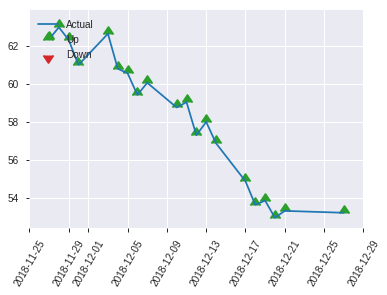


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2503402840352148
RMSE: 0.5003401683207284
LogLoss: 0.6945355882655092
Mean Per-Class Error: 0.44143675169182717
AUC: 0.5341618948464342
pr_auc: 0.5660109378955792
Gini: 0.06832378969286834
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37510713934898376: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    136  0        (0.0/136.0)
Total  1    248  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375107     0.708333  247
max f2                       0.375107     0.858586  247
max f0point5                 0.466211     0.605159  217
max accuracy                 0.468125     0.558233  215
max precision                0.615713     0.666667  56
max recall                   0.375107     1         247
max specificity              0.780337     0.99115   0
max absolute_mcc             0.604629     0.136351  59
max min_per_class_accuracy   0.551359     0.544118  124
max mean_per_class_accuracy  0.604629     0.558563  59

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 55.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.720631           0.610294  0.610294           0.333333         0.747751  0.333333                    0.747751            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.706461           0.915441  0.732353           0.5              0.714907  0.4                         0.734613            0.00735294      0.0147059                  -8.45588  -26.7647
    3        0.0321285                   0.697634           0.610294  0.686581           0.333333         0.703063  0.375                       0.722782            0.00735294      0.0220588                  -38.9706  -31.3419
    4        0.0401606                   0.689514           1.83088   0.915441           1                0.697298  0.5                         0.717685            0.0147059       0.0367647                  83.0882   -8.45588
    5        0.0522088                   0.687311           1.83088   1.1267             1                0.688297  0.615385                    0.710903            0.0220588       0.0588235                  83.0882   12.6697
    6        0.100402                    0.659716           0.762868  0.952059           0.416667         0.673699  0.52                        0.693045            0.0367647       0.0955882                  -23.7132  -4.79412
    7        0.15261                     0.63856            1.26753   1.05998            0.692308         0.648215  0.578947                    0.677709            0.0661765       0.161765                   26.7534   5.99845
    8        0.200803                    0.621746           1.52574   1.17176            0.833333         0.631315  0.64                        0.666574            0.0735294       0.235294                   52.5735   17.1765
    9        0.301205                    0.595902           1.02529   1.12294            0.56             0.60549   0.613333                    0.646213            0.102941        0.338235                   2.52941   12.2941
    10       0.401606                    0.574964           1.02529   1.09853            0.56             0.584774  0.6                         0.630853            0.102941        0.441176                   2.52941   9.85294
    11       0.502008                    0.551359           1.02529   1.08388            0.56             0.56364   0.592                       0.617411            0.102941        0.544118                   2.52941   8.38824
    12       0.598394                    0.53431            0.762868  1.03218            0.416667         0.543826  0.563758                    0.605558            0.0735294       0.617647                   -23.7132  3.21753
    13       0.698795                    0.51729            0.732353  0.989097           0.4              0.526163  0.54023                     0.594151            0.0735294       0.691176                   -26.7647  -1.09026
    14       0.799197                    0.488753           1.17176   1.01205            0.64             0.505377  0.552764                    0.582998            0.117647        0.808824                   17.1765   1.20455
    15       0.899598                    0.45942            0.952059  1.00535            0.52             0.473182  0.549107                    0.570742            0.0955882       0.904412                   -4.79412  0.535058
    16       1                           0.346404           0.952059  1                  0.52             0.420244  0.546185                    0.555632  

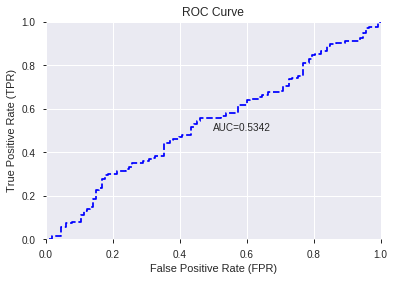

This function is available for GLM models only


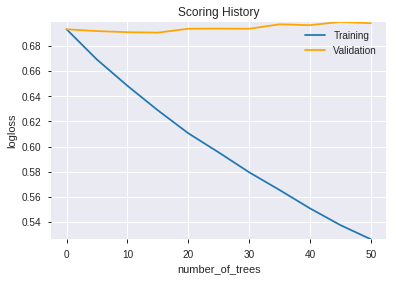

--2019-08-28 14:37:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


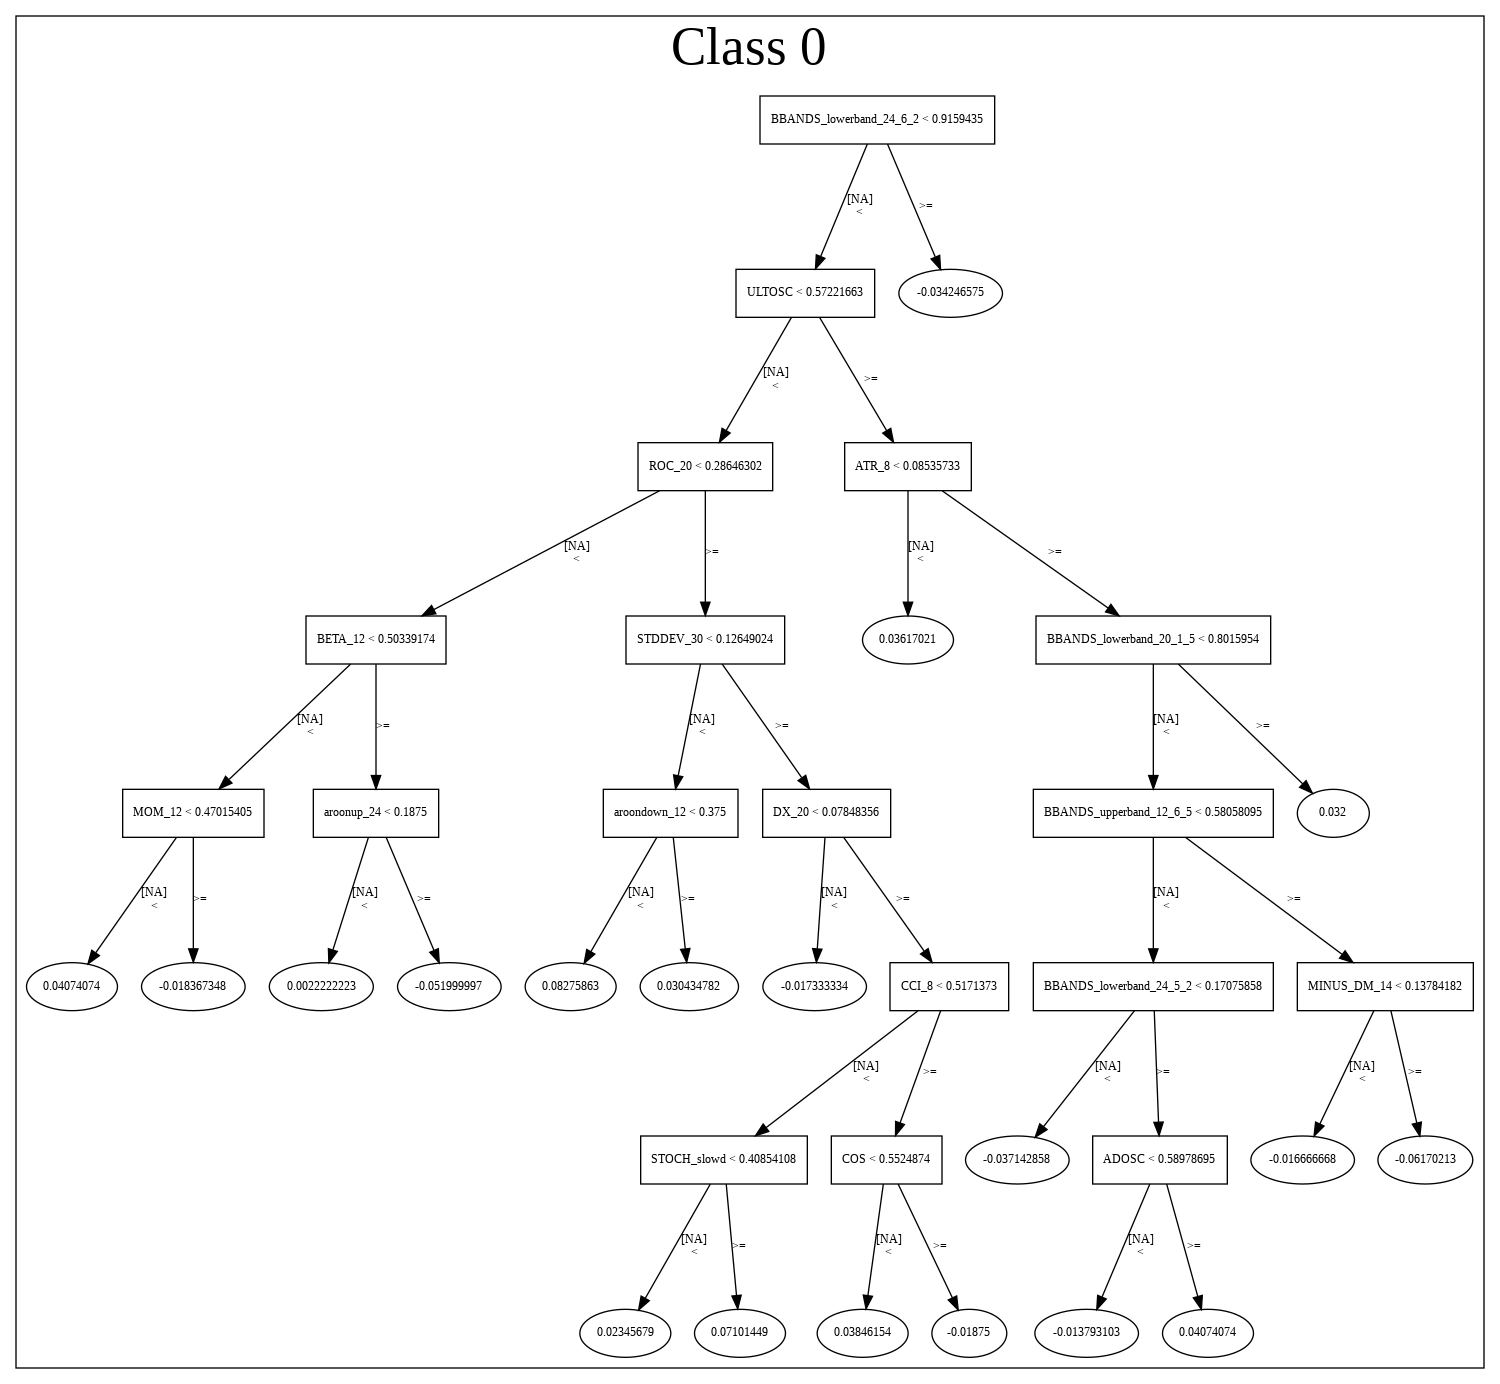

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190828_143659',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190828_143659',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a1f3',
   'type

['ULTOSC',
 'COS',
 'TAN',
 'STDDEV_30',
 'HT_PHASOR_quadrature',
 'BOP',
 'ADXR_8',
 'SIN',
 'day',
 'STOCHRSI_fastk',
 'CORREL_20',
 'BETA_12',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'DX_8',
 'dayofyear',
 'DX_12',
 'MFI_20',
 'ADOSC',
 'CCI_8',
 'ROC_20',
 'MACDFIX_signal_24',
 'MFI_8',
 'CORREL_30',
 'Volume',
 'MFI_12',
 'STDDEV_24',
 'DIV',
 'HT_PHASOR_inphase',
 'BETA_8',
 'MOM_24',
 'CORREL_8',
 'DX_24',
 'ADX_14',
 'PLUS_DI_8',
 'ADX_24',
 'MFI_14',
 'WILLR_30',
 'DX_14',
 'MINUS_DI_30',
 'DX_30',
 'MOM_12',
 'HT_DCPERIOD',
 'MFI_30',
 'ADXR_14',
 'BETA_20',
 'CORREL_12',
 'CMO_24',
 'CCI_12',
 'LINEARREG_SLOPE_30',
 'MINUS_DI_24',
 'MOM_20',
 'STDDEV_12',
 'STOCH_slowk',
 'SAREXT',
 'ADX_12',
 'NATR_20',
 'OBV',
 'ADX_8',
 'TRANGE',
 'MINUS_DM_14',
 'ADX_20',
 'BETA_30',
 'CCI_14',
 'CORREL_24',
 'MACDFIX_hist_8',
 'CCI_20',
 'CCI_30',
 'MFI_24',
 'CORREL_14',
 'ROC_30',
 'BETA_14',
 'CCI_24',
 'RSI_8',
 'MACDFIX_hist_24',
 'BBANDS_lowerband_24_6_5',
 'LINEARREG_ANGLE_12',
 'LIN

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

315

['BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperband_12_7_2',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_12_7_2',
 'BBANDS_upperband_12_7_3',
 'BBANDS_middleband_12_7_3',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_7_4',
 'BBANDS_middleband_12_7_4',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'EMA_14',
 'KAMA_14',
 'MIDPOINT_14',
 'MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'TEMA_14',
 'TRIMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MA_14_1',
 'MAVP_14_1',
 'BBANDS_middleband_14_1_2',
 'BBANDS_upperband_14_1_4',
 'BBANDS_midd

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_143918  0.526679  1.076950              0.500000  0.576666  0.332544
1  DeepLearning_grid_1_AutoML_20190828_143918_model_4  0.524662  0.893599              0.495575  0.562577  0.316493
2  DeepLearning_grid_1_AutoML_20190828_143918_model_5  0.509240  0.692205              0.490402  0.499514  0.249514
3  DeepLearning_grid_1_AutoML_20190828_143918_model_9  0.509175  0.688524              0.500000  0.497688  0.247694
4  DeepLearning_grid_1_AutoML_20190828_143918_model_2  0.503058  0.740668              0.490402  0.521026  0.271468
5  DeepLearning_grid_1_AutoML_20190828_143918_model_3  0.490174  0.752926              0.486726  0.525428  0.276075
6  DeepLearning_grid_1_AutoML_20190828_143918_model_6  0.489328  0.692195              0.500000  0.499528  0.249528
7  DeepLearning_grid_1_AutoML_20190828_143918_model_7  0.489133  0.760488              0.472703  0.524591  0.275196
8  DeepLearning_grid_1_AutoML_20190828_143918_model_8  0.487181  0.691082              0.500000  0.498967  0.248968
9  DeepLearning_grid_1_AutoML_20190828_143918_model_1  0.484969  1.473064              0.485977  0.610754  0.373021

variable  relative_importance  scaled_importance  percentage
0         CDLUPSIDEGAP2CROWS             1.000000           1.000000    0.005314
1                     CMO_24             0.900879           0.900879    0.004787
2                      ADOSC             0.883441           0.883441    0.004694
3                 PLUS_DI_12             0.875929           0.875929    0.004654
4    BBANDS_upperband_14_2_5             0.874751           0.874751    0.004648
..                       ...                  ...                ...         ...
310             aroondown_30             0.348347           0.348347    0.001851
311                MAVP_24_2             0.348226           0.348226    0.001850
312  BBANDS_upperband_14_7_2             0.310382           0.310382    0.001649
313               ROCR100_20             0.293747           0.293747    0.001561
314              CDLBELTHOLD             0.284982           0.284982    0.001514

[315 rows x 4 columns]

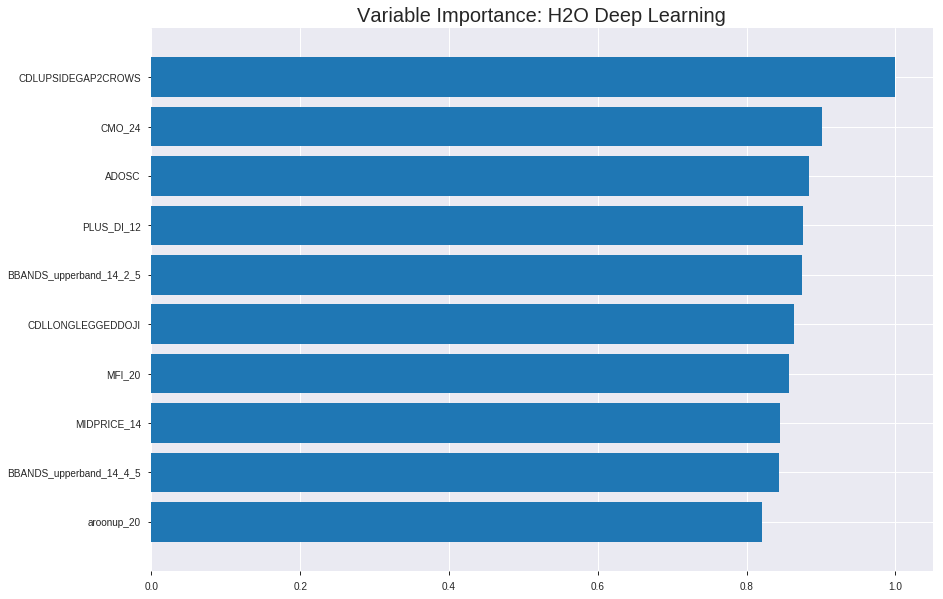

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_143918


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.32764690917406364
RMSE: 0.5724044978632362
LogLoss: 0.975596822432443
Mean Per-Class Error: 0.44210596432330174
AUC: 0.5722892770073139
pr_auc: 0.6223760178099684
Gini: 0.14457855401462782
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.028858002884082776: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   739   0.9402   (739.0/786.0)
1      21   934   0.022    (21.0/955.0)
Total  68   1673  0.4365   (760.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.028858     0.710807  386
max f2                       0.00757586   0.859122  398
max f0point5                 0.0533217    0.612159  368
max accuracy                 0.056998     0.56749   365
max precision                0.999946     1         0
max recall                   0.00757586   1         398
max specificity              0.999946     1         0
max absolute_mcc             0.506092     0.125419  158
max min_per_class_accuracy   0.268219     0.544503  249
max mean_per_class_accuracy  0.506092     0.557894  158

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 34.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.936736           1.62048   1.62048            0.888889         0.960417   0.888889                    0.960417            0.0167539       0.0167539                  62.0477   62.0477
    2        0.0201034                   0.904343           1.17961   1.40634            0.647059         0.91796    0.771429                    0.939795            0.0115183       0.0282723                  17.9612   40.6343
    3        0.0304423                   0.889523           1.62048   1.47907            0.888889         0.895908   0.811321                    0.92489             0.0167539       0.0450262                  62.0477   47.9067
    4        0.0402068                   0.867023           0.965137  1.35426            0.529412         0.877818   0.742857                    0.913459            0.00942408      0.0544503                  -3.4863   35.4256
    5        0.0505457                   0.841089           1.0128    1.28441            0.555556         0.851308   0.704545                    0.900746            0.0104712       0.0649215                  1.27981   28.4412
    6        0.100517                    0.752564           1.17345   1.22925            0.643678         0.792747   0.674286                    0.847055            0.0586387       0.12356                    17.3449   22.9248
    7        0.150488                    0.697011           1.23631   1.23159            0.678161         0.724772   0.675573                    0.806449            0.0617801       0.18534                    23.6312   23.1593
    8        0.20046                     0.630218           1.13154   1.20665            0.62069          0.661949   0.661891                    0.770428            0.0565445       0.241885                   13.154    20.6652
    9        0.300402                    0.506859           1.11059   1.17469            0.609195         0.573175   0.644359                    0.704802            0.110995        0.35288                    11.0586   17.4691
    10       0.400345                    0.398092           0.932473  1.11422            0.511494         0.453696   0.611191                    0.642116            0.0931937       0.446073                   -6.75272  11.4223
    11       0.500287                    0.269894           0.963904  1.08419            0.528736         0.331184   0.594719                    0.580001            0.0963351       0.542408                   -3.60956  8.4194
    12       0.60023                     0.181801           0.953427  1.06242            0.522989         0.223786   0.582775                    0.520689            0.095288        0.637696                   -4.65728  6.24204
    13       0.700172                    0.118956           0.921996  1.04238            0.505747         0.148578   0.57178                     0.467574            0.0921466       0.729843                   -7.80045  4.23762
    14       0.800115                    0.0795352          0.974382  1.03388            0.534483         0.0998227  0.567121                    0.421638            0.0973822       0.827225                   -2.56183  3.3883
    15       0.900057                    0.0491375          0.974382  1.02728            0.534483         0.0633574  0.563497                    0.381854            0.0973822       0.924607                   -2.56183  2.72759
    16       1                           0.0053272          0.75436   1                  0.413793         0.0304558  0.548535                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3145973425945561
RMSE: 0.5608897775807258
LogLoss: 0.9182933226955967
Mean Per-Class Error: 0.4626769835980298
AUC: 0.5249849635060228
pr_auc: 0.5524472454374153
Gini: 0.0499699270120455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.058685402799709276: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    222  0.978    (222.0/227.0)
1      0    271  0        (0.0/271.0)
Total  5    493  0.4458   (222.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0586854    0.709424  395
max f2                       0.0586854    0.859226  395
max f0point5                 0.0586854    0.604102  395
max accuracy                 0.0586854    0.554217  395
max precision                0.99358      0.666667  4
max recall                   0.0586854    1         395
max specificity              0.999003     0.995595  0
max absolute_mcc             0.0586854    0.110036  395
max min_per_class_accuracy   0.419708     0.531365  211
max mean_per_class_accuracy  0.431883     0.537323  206

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 47.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.993602           1.10258   1.10258            0.6              0.996865   0.6                         0.996865            0.0110701       0.0110701                  10.2583    10.2583
    2        0.0200803                   0.991889           0.735055  0.918819           0.4              0.992837   0.5                         0.994851            0.00738007      0.0184502                  -26.4945   -8.11808
    3        0.0301205                   0.983622           1.10258   0.980074           0.6              0.987798   0.533333                    0.9925              0.0110701       0.0295203                  10.2583    -1.99262
    4        0.0401606                   0.970932           0.735055  0.918819           0.4              0.978843   0.5                         0.989086            0.00738007      0.0369004                  -26.4945   -8.11808
    5        0.0502008                   0.953021           1.83764   1.10258            1                0.964028   0.6                         0.984074            0.0184502       0.0553506                  83.7638    10.2583
    6        0.100402                    0.869496           0.808561  0.955572           0.44             0.912385   0.52                        0.94823             0.0405904       0.095941                   -19.1439   -4.4428
    7        0.150602                    0.777838           0.955572  0.955572           0.52             0.823147   0.52                        0.906535            0.0479705       0.143911                   -4.4428    -4.4428
    8        0.200803                    0.733021           1.02908   0.973948           0.56             0.757105   0.53                        0.869178            0.0516605       0.195572                   2.90775    -2.60517
    9        0.301205                    0.630788           1.06583   1.00458            0.58             0.687117   0.546667                    0.808491            0.107011        0.302583                   6.58303    0.457565
    10       0.399598                    0.536231           1.2751    1.07119            0.693878         0.58222    0.582915                    0.752776            0.125461        0.428044                   27.5096    7.11862
    11       0.5                         0.42268            0.992325  1.05535            0.54             0.475848   0.574297                    0.697168            0.099631        0.527675                   -0.767528  5.53506
    12       0.600402                    0.345044           0.918819  1.03252            0.5              0.384362   0.561873                    0.644859            0.0922509       0.619926                   -8.11808   3.25192
    13       0.698795                    0.276669           0.937571  1.01915            0.510204         0.314485   0.554598                    0.598341            0.0922509       0.712177                   -6.24294   1.915
    14       0.799197                    0.211237           1.06583   1.02501            0.58             0.243012   0.557789                    0.553702            0.107011        0.819188                   6.58303    2.50144
    15       0.899598                    0.139501           0.918819  1.01316            0.5              0.174297   0.551339                    0.511357            0.0922509       0.911439                   -8.11808   1.31622
    16       1                           0.0367357          0.882066  1                  0.48             0.0994177  0.54417


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:39:18  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:39:18  0.163 sec   23849 obs/sec     1         1             1741       0.614014         1.33285             -0.522399      0.520821        0.572452           1.41792          0.451465                         0.573949           1.03663               -0.328039        0.548483          0.578712             1.10258            0.451807
    2019-08-28 14:39:19  0.820 sec   25231 obs/sec     10        10            17410      0.572404         0.975597            -0.323054      0.572289        0.622376           1.62048          0.436531                         0.56089            0.918293              -0.26829         0.524985          0.552447             1.10258            0.445783

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLUPSIDEGAP2CROWS       1.0                    1.0                  0.005313539901104577
CMO_24                   0.9008789658546448     0.9008789658546448   0.004786856331134483
ADOSC                    0.8834406137466431     0.8834406137466431   0.004694196951399105
PLUS_DI_12               0.8759291172027588     0.8759291172027588   0.004654284314796166
BBANDS_upperband_14_2_5  0.8747508525848389     0.8747508525848389   0.00464802355873479
---                      ---                    ---                  ---
aroondown_30             0.3483472466468811     0.3483472466468811   0.0018509569944981203
MAVP_24_2                0.34822583198547363    0.34822583198547363  0.0018503118528501528
BBANDS_upperband_14_7_2  0.31038153171539307    0.31038153171539307  0.0016492246533356969
ROCR100_20               0.29374685883522034    0.29374685883522034  0.001560835655245077
CDLBELTHOLD              0.284981906414032      0.284981906414032    0.0015142627308238094


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5582329317269076)

('F1', 0.7064935064935065)

('auc', 0.5266788131181677)

('logloss', 1.0769495891901542)

('mean_per_class_error', 0.45415799062988027)

('rmse', 0.5766661622765347)

('mse', 0.3325438627147467)

deeplearning prediction progress: |███████████████████████████████████████| 100%


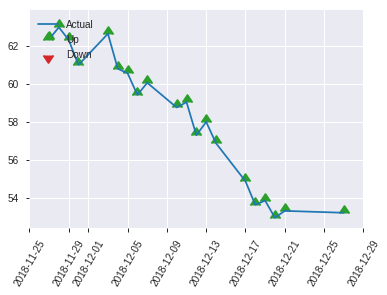


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3325438627147467
RMSE: 0.5766661622765347
LogLoss: 1.0769495891901542
Mean Per-Class Error: 0.45415799062988027
AUC: 0.5266788131181677
pr_auc: 0.560093925887108
Gini: 0.05335762623633533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.056722181382424: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    136  0        (0.0/136.0)
Total  0    249  0.4538   (113.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0567222    0.706494   248
max f2                       0.0567222    0.857503   248
max f0point5                 0.283046     0.604508   209
max accuracy                 0.2944       0.558233   205
max precision                0.955872     0.62963    53
max recall                   0.0567222    1          248
max specificity              0.998567     0.99115    0
max absolute_mcc             0.873732     0.0941613  93
max min_per_class_accuracy   0.71364      0.529412   124
max mean_per_class_accuracy  0.873732     0.545842   93

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 65.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.99671            0.610294  0.610294           0.333333         0.998182  0.333333                    0.998182            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.994008           1.83088   1.09853            1                0.995471  0.6                         0.997098            0.0147059       0.0220588                  83.0882   9.85294
    3        0.0321285                   0.9934             0.610294  0.915441           0.333333         0.993731  0.5                         0.995835            0.00735294      0.0294118                  -38.9706  -8.45588
    4        0.0401606                   0.992784           0.915441  0.915441           0.5              0.993242  0.5                         0.995316            0.00735294      0.0367647                  -8.45588  -8.45588
    5        0.0522088                   0.992301           1.22059   0.98586            0.666667         0.992673  0.538462                    0.994706            0.0147059       0.0514706                  22.0588   -1.41403
    6        0.100402                    0.981179           0.762868  0.878824           0.416667         0.986308  0.48                        0.990675            0.0367647       0.0882353                  -23.7132  -12.1176
    7        0.15261                     0.971215           1.26753   1.0118             0.692308         0.976697  0.552632                    0.985893            0.0661765       0.154412                   26.7534   1.18034
    8        0.200803                    0.959383           1.52574   1.13515            0.833333         0.965401  0.62                        0.980975            0.0735294       0.227941                   52.5735   13.5147
    9        0.301205                    0.91504            1.02529   1.09853            0.56             0.941508  0.6                         0.96782             0.102941        0.330882                   2.52941   9.85294
    10       0.401606                    0.844361           0.878824  1.0436             0.48             0.883773  0.57                        0.946808            0.0882353       0.419118                   -12.1176  4.36029
    11       0.502008                    0.71364            1.09853   1.05459            0.6              0.788832  0.576                       0.915213            0.110294        0.529412                   9.85294   5.45882
    12       0.598394                    0.565137           0.839154  1.01989            0.458333         0.619633  0.557047                    0.867603            0.0808824       0.610294                   -16.0846  1.98875
    13       0.698795                    0.446414           0.805588  0.989097           0.44             0.513612  0.54023                     0.816742            0.0808824       0.691176                   -19.4412  -1.09026
    14       0.799197                    0.339586           1.245     1.02125            0.68             0.398309  0.557789                    0.764175            0.125           0.816176                   24.5      2.12459
    15       0.899598                    0.210786           0.805588  0.997177           0.44             0.271551  0.544643                    0.709195            0.0808824       0.897059                   -19.4412  -0.2823
    16       1                           0.0567222          1.02529   1                  0.56             0.151976  0.546185                    0.653249   

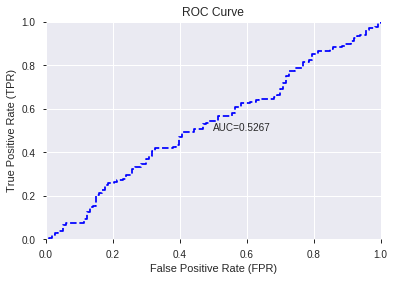

This function is available for GLM models only


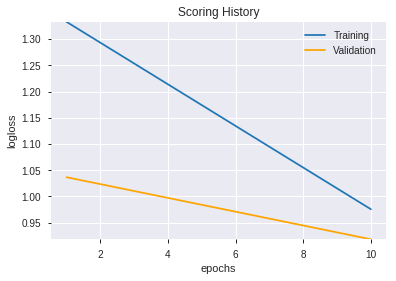

--2019-08-28 14:49:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


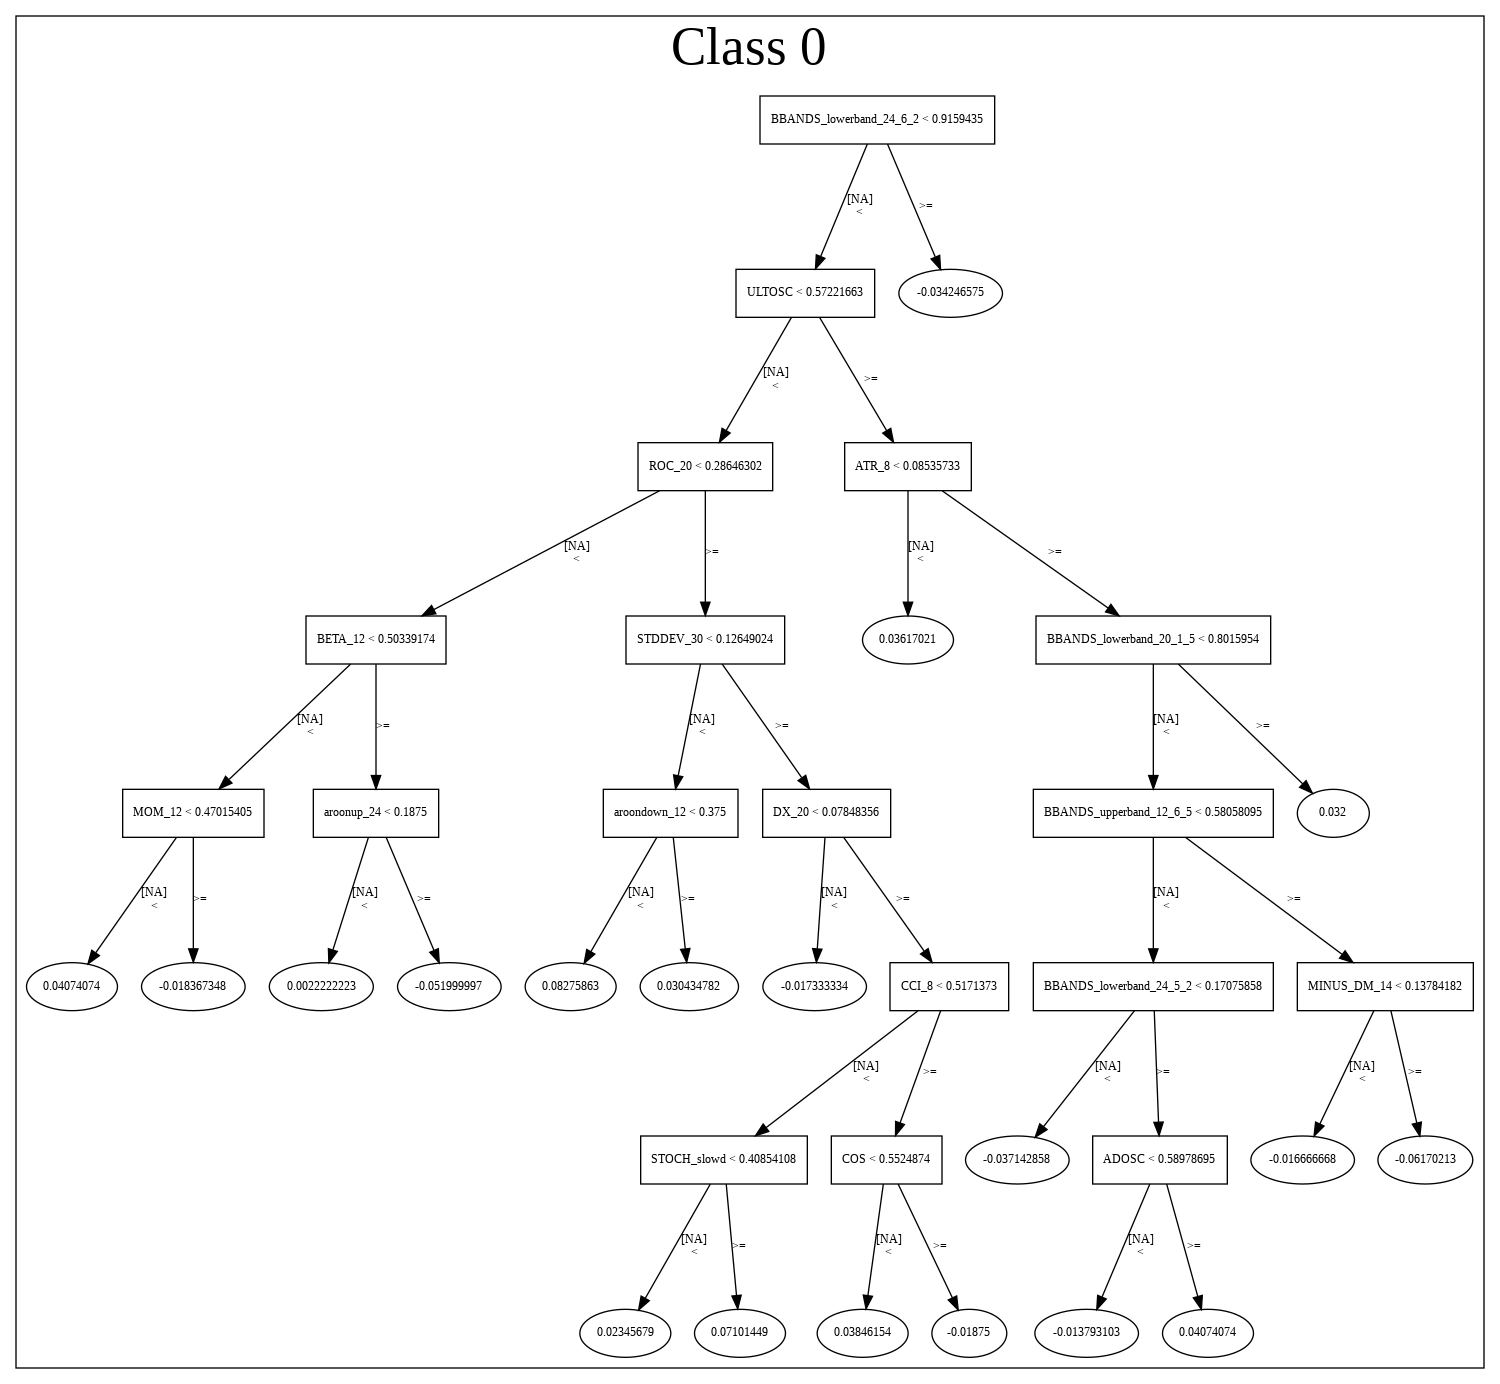

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_143918',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_143918',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_a1f3'

['CDLUPSIDEGAP2CROWS',
 'CMO_24',
 'ADOSC',
 'PLUS_DI_12',
 'BBANDS_upperband_14_2_5',
 'CDLLONGLEGGEDDOJI',
 'MFI_20',
 'MIDPRICE_14',
 'BBANDS_upperband_14_4_5',
 'aroonup_20',
 'MAVP_14_4',
 'MINUS_DM_20',
 'BETA_14',
 'MA_14_1',
 'BBANDS_lowerband_14_3_5',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_30_2_5',
 'BBANDS_upperband_14_5_4',
 'CMO_30',
 'DEMA_14',
 'BBANDS_middleband_20_5_3',
 'BBANDS_middleband_14_1_4',
 'ROCP_30',
 'CCI_30',
 'BBANDS_upperband_30_1_2',
 'aroonup_14',
 'ULTOSC',
 'LINEARREG_12',
 'CMO_20',
 'MFI_24',
 'ROCR100_12',
 'NATR_30',
 'BBANDS_middleband_20_2_5',
 'MACD_signal',
 'MIDPOINT_14',
 'WILLR_14',
 'CDLHOMINGPIGEON',
 'BBANDS_upperband_20_1_3',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'MOM_20',
 'BBANDS_middleband_24_1_2',
 'BBANDS_lowerband_14_3_4',
 'AROONOSC_12',
 'BBANDS_middleband_14_4_2',
 'ADX_12',
 'CDLRICKSHAWMAN',
 'BBANDS_upperband_24_7_3',
 'MACDFIX_24',
 'BBANDS_middleband_14_6_2',
 'NATR_8',
 'VAR_14',
 'TRIX_8',
 'MACDFIX_his

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_144958_model_1  0.511778  0.689116               0.49115  0.497977  0.247981

variable  relative_importance  scaled_importance  percentage
0      CDLHANGINGMAN             0.007068           1.000000    0.016451
1              VAR_8             0.006661           0.942401    0.015504
2         CDLHIKKAKE             0.006335           0.896358    0.014746
3          CDLHAMMER             0.005710           0.807935    0.013291
4    CDLUNIQUE3RIVER             0.004769           0.674753    0.011100
..               ...                  ...                ...         ...
310      MINUS_DI_14             0.000120           0.017021    0.000280
311        STDDEV_14             0.000113           0.015931    0.000262
312      MINUS_DM_20             0.000106           0.014980    0.000246
313           CCI_20             0.000039           0.005477    0.000090
314       PLUS_DM_14             0.000036           0.005039    0.000083

[315 rows x 4 columns]

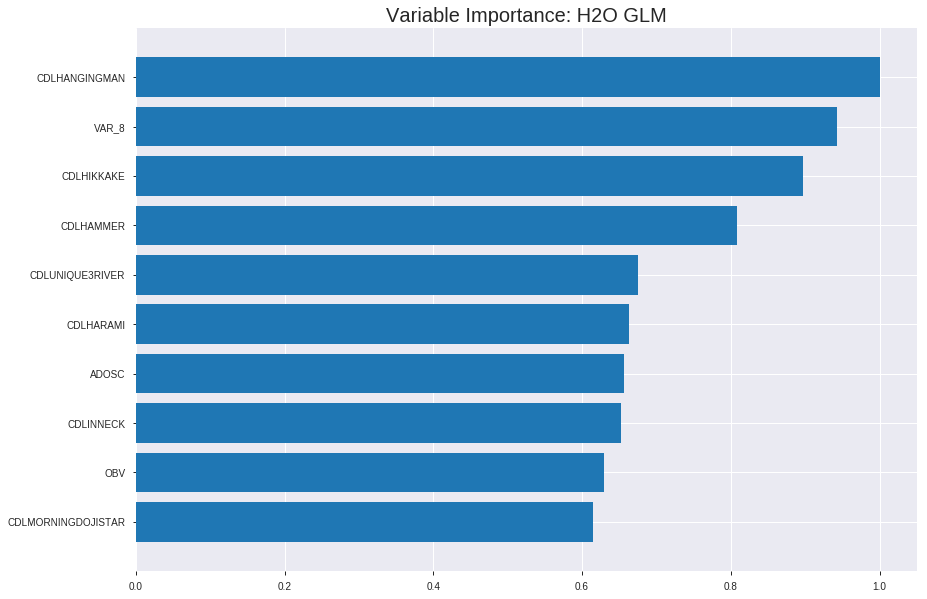

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_144958_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24528039521077755
RMSE: 0.49525790777207945
LogLoss: 0.6836221340582925
Null degrees of freedom: 1740
Residual degrees of freedom: 1425
Null deviance: 2397.1076822559344
Residual deviance: 2380.3722707909747
AIC: 3012.3722707909747
AUC: 0.5612771938238547
pr_auc: 0.6100270360369547
Gini: 0.12255438764770932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4885308033349024: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    784   0.9975   (784.0/786.0)
1      1    954   0.001    (1.0/955.0)
Total  3    1738  0.4509   (785.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488531     0.708504  397
max f2                       0.481767     0.858659  399
max f0point5                 0.522063     0.609183  314
max accuracy                 0.534567     0.564618  264
max precision                0.641981     1         0
max recall                   0.481767     1         399
max specificity              0.641981     1         0
max absolute_mcc             0.534567     0.106436  264
max min_per_class_accuracy   0.544313     0.541361  224
max mean_per_class_accuracy  0.538876     0.552539  244

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.617698           1.41792   1.41792            0.777778         0.627052  0.777778                    0.627052            0.0146597       0.0146597                  41.7917   41.7917
    2        0.0201034                   0.610883           1.28685   1.35426            0.705882         0.613418  0.742857                    0.620429            0.0125654       0.0272251                  28.6849   35.4256
    3        0.0304423                   0.607345           1.41792   1.37588            0.777778         0.609248  0.754717                    0.616632            0.0146597       0.0418848                  41.7917   37.5877
    4        0.0402068                   0.603443           1.50132   1.40634            0.823529         0.605023  0.771429                    0.613813            0.0146597       0.0565445                  50.1324   40.6343
    5        0.0505457                   0.60101            0.911518  1.30513            0.5              0.602256  0.715909                    0.611449            0.00942408      0.0659686                  -8.84817  30.5129
    6        0.100517                    0.591389           1.17345   1.23966            0.643678         0.595859  0.68                        0.603698            0.0586387       0.124607                   17.3449   23.9665
    7        0.150488                    0.582356           1.06868   1.18289            0.586207         0.586808  0.648855                    0.59809             0.0534031       0.17801                    6.86767   18.2886
    8        0.20046                     0.576339           1.13154   1.17009            0.62069          0.579278  0.641834                    0.5934              0.0565445       0.234555                   13.154    17.0087
    9        0.300402                    0.563432           0.880087  1.0736             0.482759         0.569859  0.58891                     0.585568            0.0879581       0.322513                   -11.9913  7.36048
    10       0.400345                    0.552309           1.03724   1.06453            0.568966         0.557788  0.583931                    0.578633            0.103665        0.426178                   3.7245    6.45279
    11       0.500287                    0.544372           1.12106   1.07582            0.614943         0.548013  0.590126                    0.572516            0.112042        0.53822                    12.1063   7.58219
    12       0.60023                     0.536634           1.06868   1.07463            0.586207         0.540228  0.589474                    0.56714             0.106806        0.645026                   6.86767   7.46321
    13       0.700172                    0.529971           0.921996  1.05284            0.505747         0.533465  0.577523                    0.562333            0.0921466       0.737173                   -7.80045  5.28448
    14       0.800115                    0.522413           0.921996  1.0365             0.505747         0.526196  0.568557                    0.557819            0.0921466       0.829319                   -7.80045  3.65004
    15       0.900057                    0.512909           0.869609  1.01797            0.477011         0.518216  0.558392                    0.553422            0.086911        0.91623                    -13.0391  1.79688
    16       1                           0.481767           0.838178  1                  0.45977          0.504529  0.548535                    0.548535         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2478241995917484
RMSE: 0.4978194447706401
LogLoss: 0.6888185544386383
Null degrees of freedom: 497
Residual degrees of freedom: 182
Null deviance: 686.5201497057026
Residual deviance: 686.0632802208838
AIC: 1318.0632802208838
AUC: 0.5231399450558382
pr_auc: 0.559169967589468
Gini: 0.046279890111676325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5219818908139899: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    219  0.9648   (219.0/227.0)
1      2    269  0.0074   (2.0/271.0)
Total  10   488  0.4438   (221.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.521982     0.708827  390
max f2                       0.515092     0.856511  399
max f0point5                 0.536016     0.615346  343
max accuracy                 0.538059     0.576305  333
max precision                0.571204     0.635417  90
max recall                   0.515092     1         399
max specificity              0.656741     0.995595  0
max absolute_mcc             0.536016     0.130442  343
max min_per_class_accuracy   0.553195     0.497797  209
max mean_per_class_accuracy  0.538059     0.545971  333

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 55.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.632675           0.735055  0.735055           0.4              0.651287  0.4                         0.651287            0.00738007      0.00738007                 -26.4945   -26.4945
    2        0.0200803                   0.59928            1.10258   0.918819           0.6              0.610156  0.5                         0.630722            0.0110701       0.0184502                  10.2583    -8.11808
    3        0.0301205                   0.595004           1.10258   0.980074           0.6              0.597558  0.533333                    0.619667            0.0110701       0.0295203                  10.2583    -1.99262
    4        0.0401606                   0.592613           1.10258   1.0107             0.6              0.593842  0.55                        0.613211            0.0110701       0.0405904                  10.2583    1.07011
    5        0.0502008                   0.589815           1.10258   1.02908            0.6              0.591334  0.56                        0.608835            0.0110701       0.0516605                  10.2583    2.90775
    6        0.100402                    0.57967            1.10258   1.06583            0.6              0.584324  0.58                        0.59658             0.0553506       0.107011                   10.2583    6.58303
    7        0.150602                    0.574655           1.24959   1.12708            0.68             0.577052  0.613333                    0.590071            0.0627306       0.169742                   24.9594    12.7085
    8        0.200803                    0.570693           1.17609   1.13934            0.64             0.572701  0.62                        0.585728            0.0590406       0.228782                   17.6089    13.9336
    9        0.301205                    0.564865           0.845314  1.04133            0.46             0.567402  0.566667                    0.57962             0.0848708       0.313653                   -15.4686   4.13284
    10       0.399598                    0.558081           0.862565  0.997311           0.469388         0.561408  0.542714                    0.575135            0.0848708       0.398524                   -13.7435   -0.268872
    11       0.5                         0.553133           0.992325  0.99631            0.54             0.555359  0.542169                    0.571164            0.099631        0.498155                   -0.767528  -0.369004
    12       0.600402                    0.54948            1.10258   1.01408            0.6              0.551189  0.551839                    0.567824            0.110701        0.608856                   10.2583    1.40814
    13       0.698795                    0.545318           1.01258   1.01387            0.55102          0.547539  0.551724                    0.564968            0.099631        0.708487                   1.25762    1.38694
    14       0.799197                    0.540432           1.10258   1.02501            0.6              0.542898  0.557789                    0.562195            0.110701        0.819188                   10.2583    2.50144
    15       0.899598                    0.53453            1.06583   1.02957            0.58             0.537606  0.560268                    0.559451            0.107011        0.926199                   6.58303    2.95697
    16       1                           0.515092           0.735055  1                  0.4              0.527752  0.544177             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 14:49:59  0.000 sec   2            2.8       316           1.36724           1.37764
    2019-08-28 14:49:59  0.171 sec   4            2         316           1.3656            1.37858
    2019-08-28 14:49:59  0.310 sec   6            1.5       316           1.36365           1.37978
    2019-08-28 14:50:00  0.454 sec   8            1.1       316           1.36136           1.38132
    2019-08-28 14:50:00  0.628 sec   10           0.78      316           1.35871           1.38322
    2019-08-28 14:50:00  0.814 sec   12           0.57      316           1.35575           1.38553

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542168674698795)

('F1', 0.7101827676240209)

('auc', 0.5117777199375325)

('logloss', 0.6891163748881772)

('mean_per_class_error', 0.4556546069755336)

('rmse', 0.4979771179004099)

('mse', 0.24798120995239875)

glm prediction progress: |████████████████████████████████████████████████| 100%


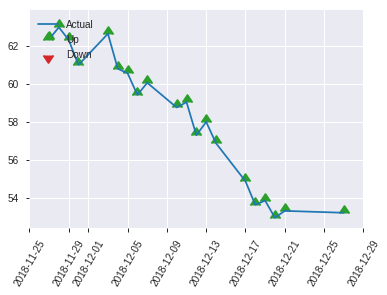


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24798120995239875
RMSE: 0.4979771179004099
LogLoss: 0.6891163748881772
Null degrees of freedom: 248
Residual degrees of freedom: -67
Null deviance: 343.0653203047996
Residual deviance: 343.17995469431224
AIC: 975.1799546943123
AUC: 0.5117777199375325
pr_auc: 0.5456496186883876
Gini: 0.023555439875065032
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5268997311178938: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    136  0        (0.0/136.0)
Total  2    247  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5269       0.710183  246
max f2                       0.5269       0.859671  246
max f0point5                 0.5269       0.604982  246
max accuracy                 0.535633     0.554217  236
max precision                0.569922     0.62963   53
max recall                   0.5269       1         246
max specificity              0.600758     0.99115   0
max absolute_mcc             0.587043     0.105069  16
max min_per_class_accuracy   0.55547      0.513274  124
max mean_per_class_accuracy  0.560296     0.544345  97

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 55.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.595324           0.610294  0.610294           0.333333         0.597483  0.333333                    0.597483            0.00735294      0.00735294                 -38.9706  -38.9706
    2        0.0200803                   0.594377           1.83088   1.09853            1                0.594696  0.6                         0.596368            0.0147059       0.0220588                  83.0882   9.85294
    3        0.0321285                   0.591386           0         0.686581           0                0.59267   0.375                       0.594981            0               0.0220588                  -100      -31.3419
    4        0.0401606                   0.589995           0.915441  0.732353           0.5              0.591201  0.4                         0.594225            0.00735294      0.0294118                  -8.45588  -26.7647
    5        0.0522088                   0.588071           1.22059   0.845023           0.666667         0.589217  0.461538                    0.593069            0.0147059       0.0441176                  22.0588   -15.4977
    6        0.100402                    0.584532           0.915441  0.878824           0.5              0.586082  0.48                        0.589716            0.0441176       0.0882353                  -8.45588  -12.1176
    7        0.15261                     0.575694           1.40837   1.05998            0.769231         0.580808  0.578947                    0.586668            0.0735294       0.161765                   40.8371   5.99845
    8        0.200803                    0.570886           1.22059   1.09853            0.666667         0.573282  0.6                         0.583455            0.0588235       0.220588                   22.0588   9.85294
    9        0.301205                    0.565256           0.878824  1.02529            0.48             0.568257  0.56                        0.578389            0.0882353       0.308824                   -12.1176  2.52941
    10       0.401606                    0.560098           1.245     1.08022            0.68             0.561992  0.59                        0.57429             0.125           0.433824                   24.5      8.02206
    11       0.502008                    0.55547            0.805588  1.02529            0.44             0.55743   0.56                        0.570918            0.0808824       0.514706                   -19.4412  2.52941
    12       0.598394                    0.551457           1.06801   1.03218            0.583333         0.553416  0.563758                    0.568099            0.102941        0.617647                   6.80147   3.21753
    13       0.698795                    0.54588            0.952059  1.02066            0.52             0.548507  0.557471                    0.565284            0.0955882       0.713235                   -4.79412  2.06643
    14       0.799197                    0.541462           0.659118  0.975244           0.36             0.543633  0.532663                    0.562564            0.0661765       0.779412                   -34.0882  -2.47561
    15       0.899598                    0.538576           1.09853   0.989003           0.6              0.540074  0.540179                    0.560054            0.110294        0.889706                   9.85294   -1.09966
    16       1                           0.520128           1.09853   1                  0.6              0.53405   0.546185                    0.557443  

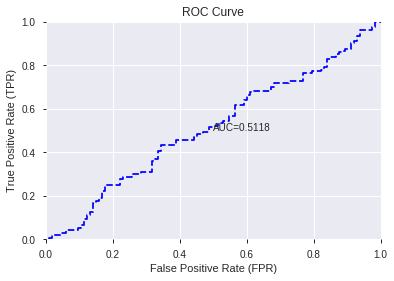

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


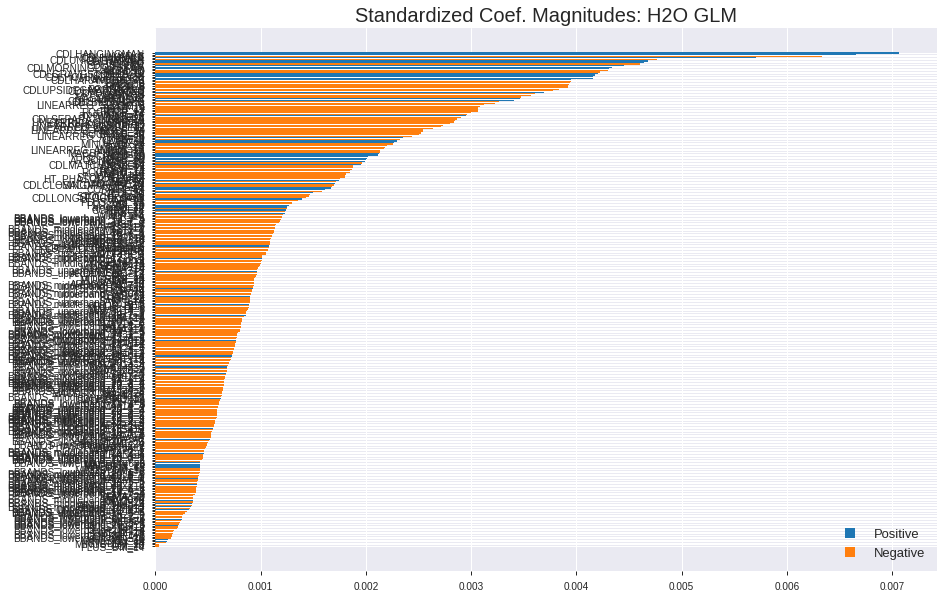

'log_likelihood'
--2019-08-28 14:50:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


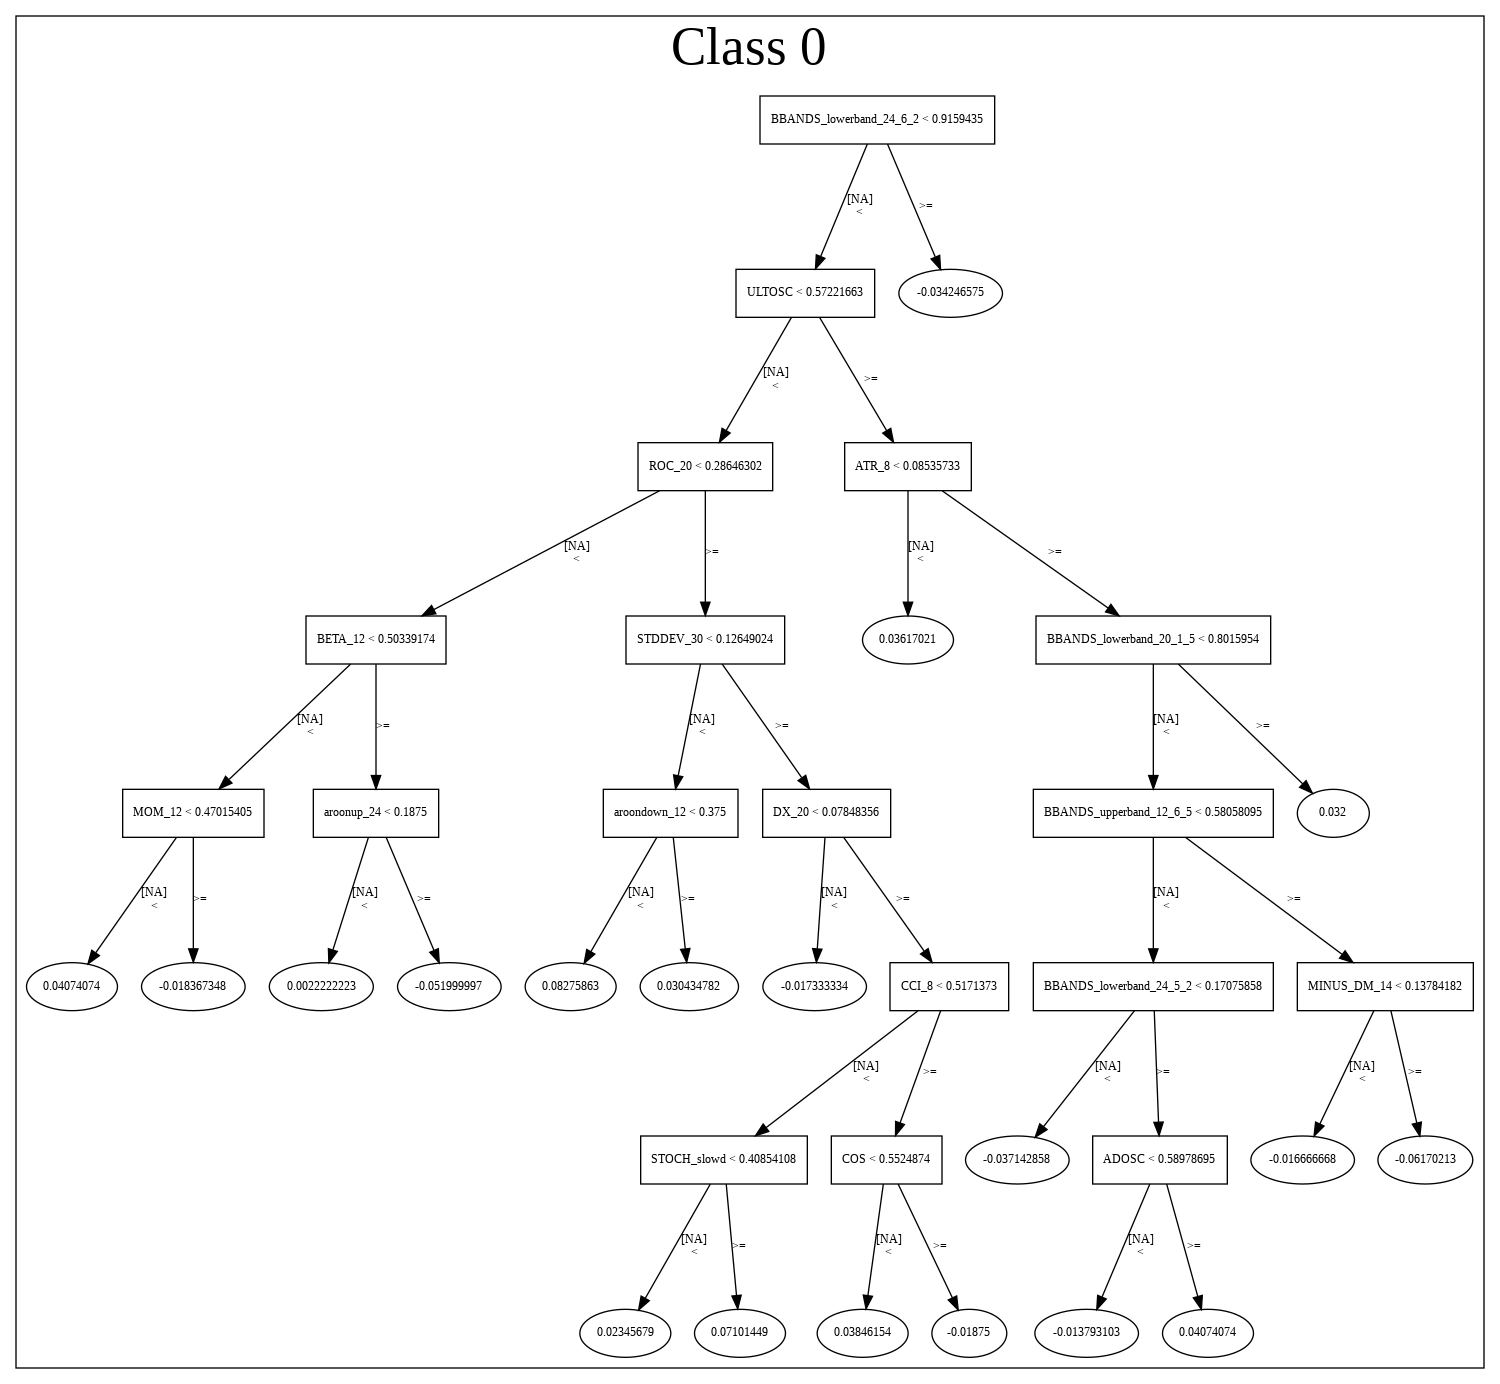

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_144958_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_144958_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLHANGINGMAN',
 'VAR_8',
 'CDLHIKKAKE',
 'CDLHAMMER',
 'CDLUNIQUE3RIVER',
 'CDLHARAMI',
 'ADOSC',
 'CDLINNECK',
 'OBV',
 'CDLMORNINGDOJISTAR',
 'MOM_20',
 'ULTOSC',
 'BETA_12',
 'CDLGRAVESTONEDOJI',
 'STDDEV_8',
 'CDLHOMINGPIGEON',
 'aroonup_20',
 'CDLHARAMICROSS',
 'CMO_30',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CDLUPSIDEGAP2CROWS',
 'CDLMARUBOZU',
 'CDLDOJISTAR',
 'BETA_8',
 'MOM_12',
 'MACDEXT_hist',
 'MACDEXT',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'LINEARREG_SLOPE_8',
 'MOM_8',
 'BETA_14',
 'ROC_12',
 'ROCP_12',
 'ROCR100_12',
 'aroondown_14',
 'WILLR_12',
 'NATR_8',
 'CMO_24',
 'CDLSEPARATINGLINES',
 'LINEARREG_SLOPE_14',
 'CDLRICKSHAWMAN',
 'PLUS_DI_30',
 'LINEARREG_SLOPE_12',
 'CDLLONGLINE',
 'LINEARREG_ANGLE_14',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'LINEARREG_ANGLE_8',
 'DX_30',
 'MFI_8',
 'CDLDOJI',
 'NATR_14',
 'MINUS_DI_24',
 'ADX_8',
 'TRIX_14',
 'WILLR_14',
 'LINEARREG_ANGLE_12',
 'CMO_20',
 'MACDFIX_hist_8',
 'ROC_20',
 'ROCR100_20',
 'NATR_30',
 'AROONOSC_2

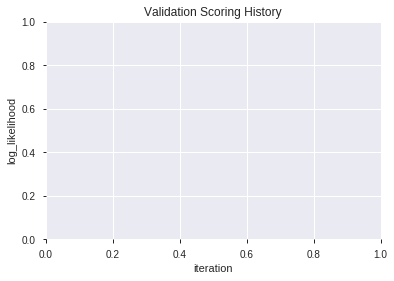

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_145020_model_5  0.526679  0.718776              0.491150  0.511769  0.261908
1  XGBoost_grid_1_AutoML_20190828_145020_model_4  0.525898  0.688901              0.490402  0.497898  0.247902
2               XGBoost_3_AutoML_20190828_145020  0.524401  0.692556              0.500000  0.499665  0.249665
3  XGBoost_grid_1_AutoML_20190828_145020_model_7  0.518740  0.699083              0.495575  0.502811  0.252819
4  XGBoost_grid_1_AutoML_20190828_145020_model_6  0.502928  0.694398              0.495575  0.500511  0.250511
5               XGBoost_2_AutoML_20190828_145020  0.499935  0.704229              0.491150  0.505171  0.255197
6               XGBoost_1_AutoML_20190828_145020  0.492061  0.710376              0.466033  0.507501  0.257558
7  XGBoost_grid_1_AutoML_20190828_145020_model_1  0.488678  0.698339              0.491150  0.502435  0.252441
8  XGBoost_grid_1_AutoML_20190828_145020_model_3  0.483798  0.703597              0.500000  0.505000  0.255025
9  XGBoost_grid_1_AutoML_20190828_145020_model_2  0.481780  0.699077              0.500000  0.502859  0.252867

variable  relative_importance  scaled_importance  percentage
0                         BOP           545.348999           1.000000    0.023095
1                       MFI_8           433.887238           0.795614    0.018374
2                       ADX_8           350.194214           0.642147    0.014830
3                      ULTOSC           348.485413           0.639014    0.014758
4     BBANDS_upperband_12_6_4           343.586304           0.630030    0.014550
..                        ...                  ...                ...         ...
278               CDL3OUTSIDE             1.951055           0.003578    0.000083
279        CDLSEPARATINGLINES             1.819661           0.003337    0.000077
280   BBANDS_upperband_14_5_4             1.612690           0.002957    0.000068
281  BBANDS_middleband_14_2_5             1.395017           0.002558    0.000059
282  BBANDS_middleband_14_3_5             0.382482           0.000701    0.000016

[283 rows x 4 columns]

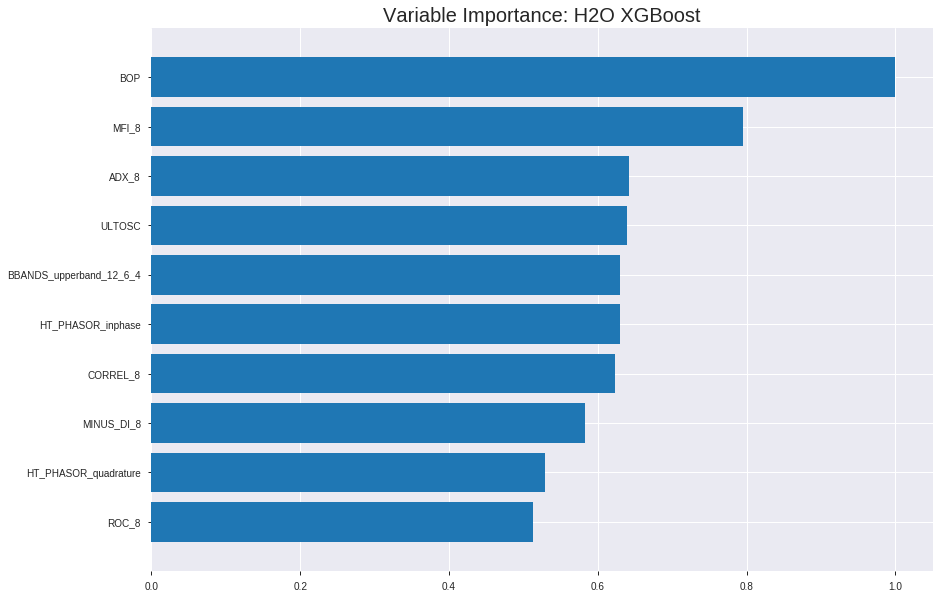

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_145020_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04325694599557134
RMSE: 0.20798304256734812
LogLoss: 0.22298342475610983
Mean Per-Class Error: 0.0011596925249457435
AUC: 0.99999200671436
pr_auc: 0.9989462950409531
Gini: 0.9999840134287199
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48354649543762207: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      784  2    0.0025   (2.0/786.0)
1      0    955  0        (0.0/955.0)
Total  784  957  0.0011   (2.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483546     0.998954  200
max f2                       0.483546     0.999581  200
max f0point5                 0.590922     0.998953  198
max accuracy                 0.590922     0.998851  198
max precision                0.930435     1         0
max recall                   0.483546     1         200
max specificity              0.930435     1         0
max absolute_mcc             0.483546     0.997683  200
max min_per_class_accuracy   0.590922     0.998728  198
max mean_per_class_accuracy  0.590922     0.99884   198

Gains/Lift Table: Avg response rate: 54.85 %, avg score: 54.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.911544           1.82304   1.82304            1                0.918971  1                           0.918971            0.0188482       0.0188482                  82.3037   82.3037
    2        0.0201034                   0.905733           1.82304   1.82304            1                0.907969  1                           0.913627            0.017801        0.0366492                  82.3037   82.3037
    3        0.0304423                   0.90038            1.82304   1.82304            1                0.903039  1                           0.910031            0.0188482       0.0554974                  82.3037   82.3037
    4        0.0402068                   0.897261           1.82304   1.82304            1                0.8987    1                           0.907279            0.017801        0.0732984                  82.3037   82.3037
    5        0.0505457                   0.894406           1.82304   1.82304            1                0.89584   1                           0.90494             0.0188482       0.0921466                  82.3037   82.3037
    6        0.100517                    0.876367           1.82304   1.82304            1                0.88452   1                           0.894788            0.0910995       0.183246                   82.3037   82.3037
    7        0.150488                    0.862295           1.82304   1.82304            1                0.869452  1                           0.886375            0.0910995       0.274346                   82.3037   82.3037
    8        0.20046                     0.846946           1.82304   1.82304            1                0.854786  1                           0.8785              0.0910995       0.365445                   82.3037   82.3037
    9        0.300402                    0.819784           1.82304   1.82304            1                0.832793  1                           0.863294            0.182199        0.547644                   82.3037   82.3037
    10       0.400345                    0.792093           1.82304   1.82304            1                0.806849  1                           0.849203            0.182199        0.729843                   82.3037   82.3037
    11       0.500287                    0.73065            1.82304   1.82304            1                0.764525  1                           0.832287            0.182199        0.912042                   82.3037   82.3037
    12       0.60023                     0.301957           0.880087  1.66603            0.482759         0.516814  0.913876                    0.779758            0.0879581       1                          -11.9913  66.6029
    13       0.700172                    0.234497           0         1.42822            0                0.261905  0.783429                    0.70584             0               1                          -100      42.822
    14       0.800115                    0.199232           0         1.24982            0                0.216392  0.685571                    0.644703            0               1                          -100      24.9821
    15       0.900057                    0.162815           0         1.11104            0                0.182096  0.609445                    0.593335            0               1                          -100      11.104
    16       1                           0.0913907          0         1                  0                0.137636  0.548535                    0.547791           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2573812227605296
RMSE: 0.5073275300636952
LogLoss: 0.7122655998069367
Mean Per-Class Error: 0.44466570216362955
AUC: 0.5504494692524018
pr_auc: 0.5836007519792012
Gini: 0.10089893850480358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18974386155605316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    227  1        (227.0/227.0)
1      0    271  0        (0.0/271.0)
Total  0    498  0.4558   (227.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.189744     0.704811  399
max f2                       0.189744     0.856511  399
max f0point5                 0.189744     0.598763  399
max accuracy                 0.493209     0.554217  270
max precision                0.733624     0.692308  48
max recall                   0.189744     1         399
max specificity              0.869635     0.995595  0
max absolute_mcc             0.683139     0.138637  85
max min_per_class_accuracy   0.574378     0.519824  195
max mean_per_class_accuracy  0.683139     0.555334  85

Gains/Lift Table: Avg response rate: 54.42 %, avg score: 56.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.839798           0.367528  0.367528           0.2              0.857356  0.2                         0.857356            0.00369004      0.00369004                 -63.2472  -63.2472
    2        0.0200803                   0.812532           1.10258   0.735055           0.6              0.824157  0.4                         0.840756            0.0110701       0.0147601                  10.2583   -26.4945
    3        0.0301205                   0.794361           1.10258   0.857565           0.6              0.803126  0.466667                    0.828213            0.0110701       0.0258303                  10.2583   -14.2435
    4        0.0401606                   0.7872             1.10258   0.918819           0.6              0.791845  0.5                         0.819121            0.0110701       0.0369004                  10.2583   -8.11808
    5        0.0502008                   0.770011           1.10258   0.955572           0.6              0.777272  0.52                        0.810751            0.0110701       0.0479705                  10.2583   -4.4428
    6        0.100402                    0.736288           1.54362   1.24959            0.84             0.752221  0.68                        0.781486            0.0774908       0.125461                   54.3616   24.9594
    7        0.150602                    0.708362           1.10258   1.20059            0.6              0.72205   0.653333                    0.761674            0.0553506       0.180812                   10.2583   20.059
    8        0.200803                    0.679762           1.39661   1.24959            0.76             0.692291  0.68                        0.744328            0.0701107       0.250923                   39.6605   24.9594
    9        0.301205                    0.640177           0.845314  1.11483            0.46             0.65866   0.606667                    0.715772            0.0848708       0.335793                   -15.4686  11.4834
    10       0.399598                    0.603561           0.975073  1.08042            0.530612         0.620467  0.58794                     0.692305            0.095941        0.431734                   -2.49266  8.04206
    11       0.5                         0.574699           0.845314  1.03321            0.46             0.59082   0.562249                    0.671926            0.0848708       0.516605                   -15.4686  3.32103
    12       0.600402                    0.533641           1.13934   1.05096            0.62             0.554187  0.571906                    0.652238            0.114391        0.630996                   13.9336   5.09571
    13       0.698795                    0.489463           0.975073  1.04027            0.530612         0.511828  0.566092                    0.632467            0.095941        0.726937                   -2.49266  4.02723
    14       0.799197                    0.439077           0.845314  1.01578            0.46             0.469071  0.552764                    0.61194             0.0848708       0.811808                   -15.4686  1.578
    15       0.899598                    0.377996           0.918819  1.00496            0.5              0.412135  0.546875                    0.58964             0.0922509       0.904059                   -8.11808  0.495849
    16       1                           0.189744           0.955572  1                  0.52             0.30898   0.544177                    0.561462       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:50:34  6.341 sec   0                  0.5              0.693147            0.5             0                  1                0.451465                         0.5                0.693147              0.5               0                    1                  0.455823
    2019-08-28 14:50:34  6.923 sec   5                  0.45201          0.601092            0.9661          0.969405           1.82304          0.0901781                        0.497681           0.6885                0.548743          0.582379             1.10258            0.451807
    2019-08-28 14:50:35  7.287 sec   10                 0.41055          0.527023            0.991372        0.992275           1.82304          0.0453762                        0.49777            0.688682              0.544906          0.579754             1.47011            0.453815
    2019-08-28 14:50:35  7.685 sec   15                 0.374287         0.466011            0.997784        0.997217           1.82304          0.0224009                        0.499905           0.693074              0.533877          0.57597              1.10258            0.455823
    2019-08-28 14:50:35  8.109 sec   20                 0.338564         0.408851            0.999238        0.998292           1.82304          0.00861574                       0.500541           0.694809              0.546703          0.586091             0.735055           0.455823
    2019-08-28 14:50:36  8.532 sec   25                 0.307696         0.361864            0.99923         0.998122           1.82304          0.00516944                       0.499236           0.692408              0.55813           0.588676             1.10258            0.455823
    2019-08-28 14:50:36  8.941 sec   30                 0.285472         0.328953            0.9995          0.998482           1.82304          0.0034463                        0.49952            0.693426              0.56434           0.594495             1.10258            0.455823
    2019-08-28 14:50:37  9.329 sec   35                 0.263825         0.297968            0.99978         0.998766           1.82304          0.00229753                       0.502348           0.699682              0.554205          0.589267             0.367528           0.455823
    2019-08-28 14:50:37  9.775 sec   40                 0.242623         0.268835            0.999897        0.998867           1.82304          0.00114877                       0.503208           0.701976              0.553327          0.584515             0.735055           0.455823
    2019-08-28 14:50:37  10.198 sec  45                 0.225898         0.246404            0.999965        0.998924           1.82304          0.00114877                       0.504696           0.70579               0.555749          0.589696             0.367528           0.455823
    2019-08-28 14:50:38  10.681 sec  50                 0.207983         0.222983            0.999992        0.998946           1.82304          0.00114877                       0.507328           0.712266              0.550449          0.583601             0.367528           0.455823

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
BOP                       545.3489990234375      1.0                    0.023094664114160064
MFI_8                     433.8872375488281      0.7956138882179941     0.01837443551295546
ADX_8                     350.1942138671875      0.642146982013874      0.014830168861532003
ULTOSC                    348.48541259765625     0.6390135733662168     0.014757803841281955
BBANDS_upperband_12_6_4   343.5863037109375      0.6300301354292412     0.014550334359537103
---                       ---                    ---                    ---
CDL3OUTSIDE               1.951054573059082      0.003577625660912291   8.262406296496927e-05
CDLSEPARATINGLINES        1.8196611404418945     0.003336691079841316   7.705975974164923e-05
BBANDS_upperband_14_5_4   1.6126902103424072     0.002957170936831771   6.829486951428579e-05
BBANDS_middleband_14_2_5  1.3950166702270508     0.002558025544605606   5.907674074810784e-05
BBANDS_middleband_14_3_5  0.38248226046562195    0.0007013531906183694  1.619751636272572e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542168674698795)

('F1', 0.7101827676240209)

('auc', 0.5266788131181677)

('logloss', 0.7187760301041892)

('mean_per_class_error', 0.44211998958875587)

('rmse', 0.5117690958856638)

('mse', 0.2619076075036297)

xgboost prediction progress: |████████████████████████████████████████████| 100%


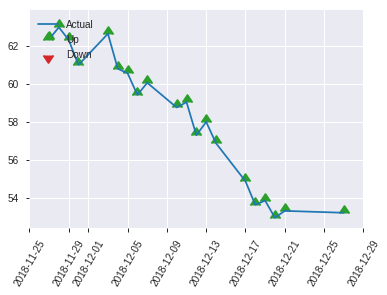


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2619076075036297
RMSE: 0.5117690958856638
LogLoss: 0.7187760301041892
Mean Per-Class Error: 0.44211998958875587
AUC: 0.5266788131181677
pr_auc: 0.6105593635515842
Gini: 0.05335762623633533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2994556725025177: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    136  0        (0.0/136.0)
Total  2    247  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299456     0.710183  246
max f2                       0.299456     0.859671  246
max f0point5                 0.299456     0.604982  246
max accuracy                 0.299456     0.554217  246
max precision                0.844521     1         0
max recall                   0.299456     1         246
max specificity              0.844521     1         0
max absolute_mcc             0.771408     0.161001  17
max min_per_class_accuracy   0.613674     0.492647  123
max mean_per_class_accuracy  0.70825      0.55788   50

Gains/Lift Table: Avg response rate: 54.62 %, avg score: 59.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.823317           1.83088   1.83088            1                0.832154  1                           0.832154            0.0220588       0.0220588                  83.0882   83.0882
    2        0.0200803                   0.805082           1.83088   1.83088            1                0.818135  1                           0.826546            0.0147059       0.0367647                  83.0882   83.0882
    3        0.0321285                   0.802046           1.22059   1.60202            0.666667         0.804339  0.875                       0.818219            0.0147059       0.0514706                  22.0588   60.2022
    4        0.0401606                   0.790326           1.83088   1.64779            1                0.795087  0.9                         0.813592            0.0147059       0.0661765                  83.0882   64.7794
    5        0.0522088                   0.781631           1.22059   1.54921            0.666667         0.78744   0.846154                    0.807557            0.0147059       0.0808824                  22.0588   54.9208
    6        0.100402                    0.766775           1.06801   1.31824            0.583333         0.772859  0.72                        0.790902            0.0514706       0.132353                   6.80147   31.8235
    7        0.15261                     0.732832           0.704186  1.10817            0.384615         0.748364  0.605263                    0.77635             0.0367647       0.169118                   -29.5814  10.8166
    8        0.200803                    0.708344           1.67831   1.245              0.916667         0.719451  0.68                        0.762694            0.0808824       0.25                       67.8309   24.5
    9        0.301205                    0.677651           0.878824  1.12294            0.48             0.694013  0.613333                    0.7398              0.0882353       0.338235                   -12.1176  12.2941
    10       0.401606                    0.643264           0.878824  1.06191            0.48             0.659808  0.58                        0.719802            0.0882353       0.426471                   -12.1176  6.19118
    11       0.502008                    0.611008           0.659118  0.981353           0.36             0.628054  0.536                       0.701453            0.0661765       0.492647                   -34.0882  -1.86471
    12       0.598394                    0.577398           1.06801   0.995312           0.583333         0.592655  0.543624                    0.683928            0.102941        0.595588                   6.80147   -0.468812
    13       0.698795                    0.538708           0.878824  0.978575           0.48             0.556258  0.534483                    0.665585            0.0882353       0.683824                   -12.1176  -2.14249
    14       0.799197                    0.478873           1.245     1.01205            0.68             0.508709  0.552764                    0.645877            0.125           0.808824                   24.5      1.20455
    15       0.899598                    0.404681           0.732353  0.98083            0.4              0.438151  0.535714                    0.622693            0.0735294       0.882353                   -26.7647  -1.91702
    16       1                           0.273656           1.17176   1                  0.64             0.355207  0.546185                    0.595837       

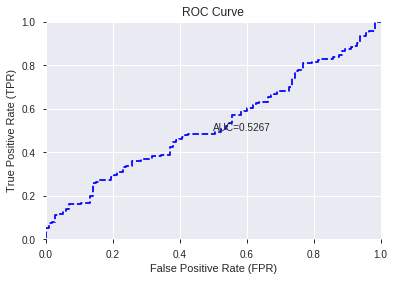

This function is available for GLM models only


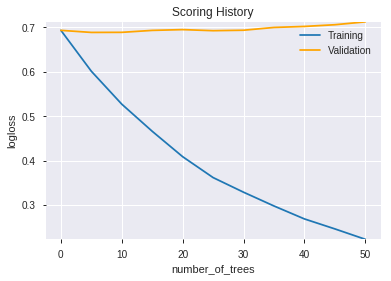

--2019-08-28 14:50:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

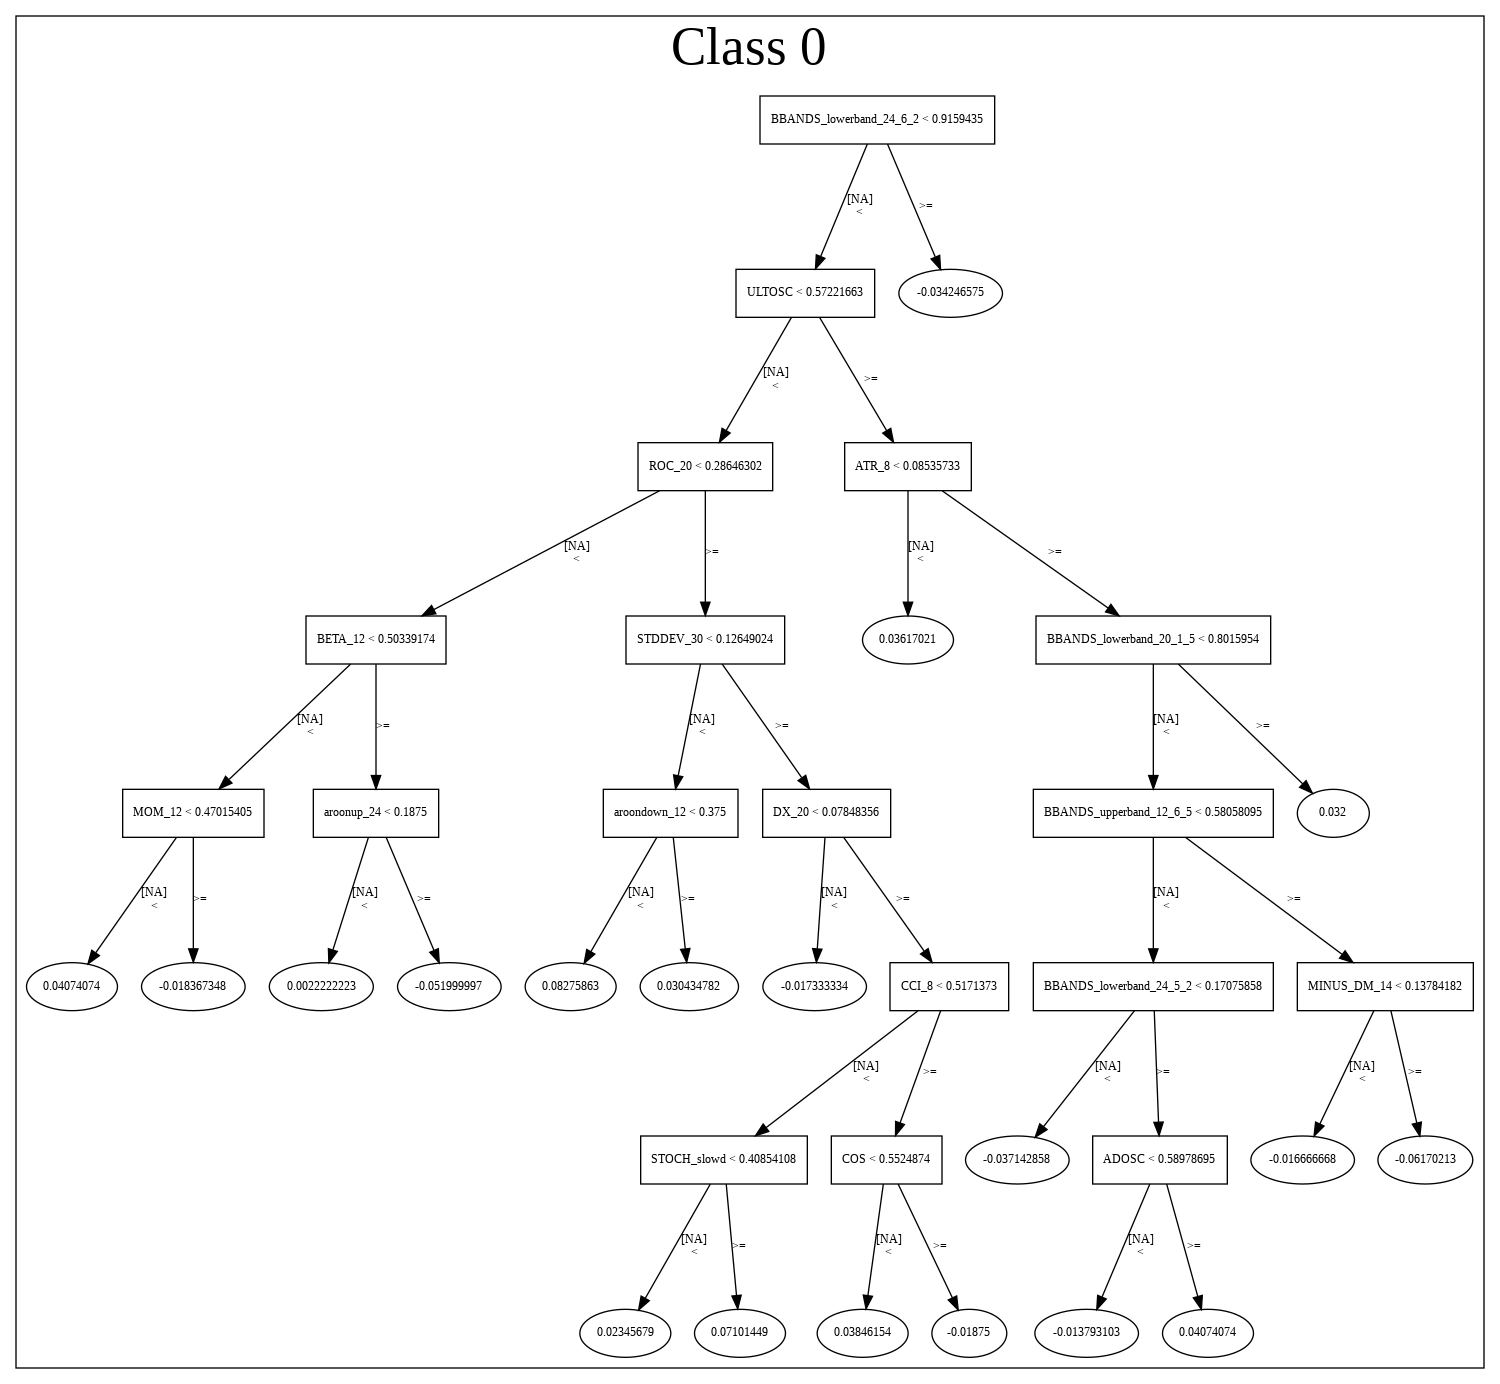

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_145020_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_145020_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a1f3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'MFI_8',
 'ADX_8',
 'ULTOSC',
 'BBANDS_upperband_12_6_4',
 'HT_PHASOR_inphase',
 'CORREL_8',
 'MINUS_DI_8',
 'HT_PHASOR_quadrature',
 'ROC_8',
 'MFI_14',
 'STOCH_slowk',
 'BETA_12',
 'DX_12',
 'ADXR_12',
 'RSI_8',
 'CORREL_14',
 'ADOSC',
 'MOM_8',
 'ADX_24',
 'TRANGE',
 'MFI_12',
 'STOCHF_fastk',
 'MFI_20',
 'BBANDS_middleband_12_6_4',
 'BETA_14',
 'BBANDS_lowerband_12_6_4',
 'PLUS_DI_8',
 'ROC_20',
 'ADXR_14',
 'NATR_8',
 'MACDFIX_hist_8',
 'MOM_20',
 'WILLR_12',
 'STOCH_slowd',
 'MOM_14',
 'MACDFIX_hist_24',
 'ADX_12',
 'DX_30',
 'ROC_12',
 'CMO_12',
 'PLUS_DI_12',
 'CORREL_12',
 'MFI_24',
 'CCI_14',
 'CCI_12',
 'MOM_24',
 'PLUS_DI_30',
 'BETA_8',
 'BBANDS_lowerband_30_1_4',
 'ROC_24',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_12',
 'NATR_14',
 'MFI_30',
 'STDDEV_8',
 'MOM_12',
 'MINUS_DI_24',
 'STOCHRSI_fastk',
 'ROC_14',
 'MACDEXT',
 'MINUS_DM_14',
 'LINEARREG_ANGLE_12',
 'DX_14',
 'PPO',
 'AROONOSC_12',
 'OBV',
 'STDDEV_14',
 'MOM_30',
 'TRIX_8',
 'PLUS_DM_12',
 'MACDEXT_hist'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.602
GLM             0.558
XGBoost         0.598
dtype: float64

DeepLearning    GLM  XGBoost
All          0.590  0.558    0.558
DLF          0.550  0.550    0.598
Fwe          0.602  0.558    0.558
RFE          0.558  0.554    0.554
XGBF         0.554  0.550    0.598





F1


DeepLearning    0.724
GLM             0.710
XGBoost         0.710
dtype: float64

DeepLearning    GLM  XGBoost
All          0.711  0.710    0.708
DLF          0.707  0.706    0.710
Fwe          0.724  0.710    0.708
RFE          0.706  0.710    0.710
XGBF         0.709  0.706    0.710





auc


DeepLearning    0.570
GLM             0.512
XGBoost         0.568
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.500    0.534
DLF          0.523  0.506    0.568
Fwe          0.548  0.500    0.534
RFE          0.527  0.512    0.527
XGBF         0.515  0.506    0.568





logloss


DeepLearning    1.097
GLM             0.691
XGBoost         0.719
dtype: float64

DeepLearning    GLM  XGBoost
All          0.688  0.691    0.695
DLF          0.690  0.689    0.691
Fwe          0.912  0.691    0.695
RFE          1.077  0.689    0.719
XGBF         1.097  0.689    0.691





mean_per_class_error


DeepLearning    0.464
GLM             0.472
XGBoost         0.442
dtype: float64

DeepLearning    GLM  XGBoost
All          0.413  0.472    0.441
DLF          0.448  0.444    0.406
Fwe          0.432  0.472    0.441
RFE          0.454  0.456    0.442
XGBF         0.464  0.444    0.406





rmse


DeepLearning    0.590
GLM             0.499
XGBoost         0.512
dtype: float64

DeepLearning    GLM  XGBoost
All          0.497  0.499    0.500
DLF          0.498  0.498    0.498
Fwe          0.549  0.499    0.500
RFE          0.577  0.498    0.512
XGBF         0.590  0.498    0.498





mse


DeepLearning    0.348
GLM             0.249
XGBoost         0.262
dtype: float64

DeepLearning    GLM  XGBoost
All          0.247  0.249    0.250
DLF          0.248  0.248    0.248
Fwe          0.301  0.249    0.250
RFE          0.333  0.248    0.262
XGBF         0.348  0.248    0.248

{'F1':       DeepLearning    GLM  XGBoost
 All          0.711    NaN      NaN
 DLF          0.707    NaN      NaN
 DLF            NaN  0.706      NaN
 DLF            NaN    NaN    0.710
 All            NaN  0.710      NaN
 All            NaN    NaN    0.708
 XGBF         0.709    NaN      NaN
 XGBF           NaN  0.706      NaN
 XGBF           NaN    NaN    0.710
 Fwe          0.724    NaN      NaN
 Fwe            NaN  0.710      NaN
 Fwe            NaN    NaN    0.708
 RFE          0.706    NaN      NaN
 RFE            NaN  0.710      NaN
 RFE            NaN    NaN    0.710,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.590    NaN      NaN
 DLF          0.550    NaN      NaN
 DLF            NaN  0.550      NaN
 DLF            NaN    NaN    0.598
 All            NaN  0.558      NaN
 All            NaN    NaN    0.558
 XGBF         0.554    NaN      NaN
 XGBF           NaN  0.550      NaN
 XGBF           NaN    NaN    0.598
 Fwe          0.602    NaN      NaN
 Fwe     